In [2]:
#environment 3Dtrackplot Python 3.9.15
import mpl_toolkits
from mpl_toolkits import mplot3d




In [10]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math as mt
import datetime
from datetime import datetime, timedelta, time

from mpl_toolkits.mplot3d import axes3d

import os
import statistics
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [232]:
#if movies are in lots of different folders
file_list=[]
# folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output'
# folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/old_movie_output'
# folderpath='/Volumes/mas515/home/CP_MOVIE2/movie_output'
folderpath='/Volumes/mas515/home/CP_MOVIE2/movie_output230717'
for root,dirs, files in os.walk(folderpath):
    for file in files:
        if file.endswith('DP.csv'):
            # file_list.append(os.path.join(root,file))
            data=pd.read_csv(os.path.join(root,file), index_col=None, header=0)
            file_list.append(data)

dataDP=pd.concat(file_list, axis =0, ignore_index=True)
dataDP['Hoxb5_status']='DP'
print(dataDP)

file_list=[]
# folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output'
# folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/old_movie_output'
# folderpath='/Volumes/mas515/home/CP_MOVIE2/movie_output'
folderpath='/Volumes/mas515/home/CP_MOVIE2/movie_output230717'
for root,dirs, files in os.walk(folderpath):
    for file in files:
        if file.endswith('SP.csv'):
            # file_list.append(os.path.join(root,file))
            data=pd.read_csv(os.path.join(root,file), index_col=None, header=0)
            file_list.append(data)

dataSP=pd.concat(file_list, axis =0, ignore_index=True)
dataSP['Hoxb5_status']='SP'

    ImageNumber ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0          1779            1                 NaN                    NaN   
1          1782            1                 NaN                    NaN   
2          1419            1                 NaN                    NaN   
3          1420            1                 NaN                    NaN   
4          1015            1                 NaN                    NaN   
..          ...          ...                 ...                    ...   
615         211            1                 NaN                    NaN   
616         212            1                 NaN                    NaN   
617         213            1                 NaN                    NaN   
618         214            1                 NaN                    NaN   
619         215            1                 NaN                    NaN   

     Metadata_Format1  Metadata_Format2 Metadata_Frame Metadata_Series  \
0                 NaN    

In [240]:
data=pd.concat([dataSP, dataDP], axis=0, ignore_index=True)
print(data)
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/movie_full.csv') 
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/old_movie_full.csv')
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/230725_movie_some.csv')
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/230728_cp_movies.csv')

      ImageNumber ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0             274            1                 NaN                    NaN   
1             274            2                 NaN                    NaN   
2             275            1                 NaN                    NaN   
3             275            2                 NaN                    NaN   
4             275            3                 NaN                    NaN   
...           ...          ...                 ...                    ...   
13822         211            1                 NaN                    NaN   
13823         212            1                 NaN                    NaN   
13824         213            1                 NaN                    NaN   
13825         214            1                 NaN                    NaN   
13826         215            1                 NaN                    NaN   

       Metadata_Format1  Metadata_Format2 Metadata_Frame Metadata_Series  \

In [241]:
#back up #importing the metadata
#make sure that date is in reverse format for both imaging date and acquisition date 23-07-17
# metadata=pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv')
metadata=pd.read_csv('/Users/secchim/Documents/230713merged_metadata_and_mice.csv')

metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
data=pd.merge(data, metadata[:], on = 'Metadata_VWF')
print(data)
# data.to_csv('/Users/secchim/Documents/221104TEST.csv')
data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/230728_cp_movies.csv')

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2919454780.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')


      ImageNumber ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0             274            1                 NaN                    NaN   
1             274            2                 NaN                    NaN   
2             275            1                 NaN                    NaN   
3             275            2                 NaN                    NaN   
4             275            3                 NaN                    NaN   
...           ...          ...                 ...                    ...   
13604        1422            1                 NaN                    NaN   
13605        1423            1                 NaN                    NaN   
13606        1424            1                 NaN                    NaN   
13607        1425            1                 NaN                    NaN   
13608        1426            1                 NaN                    NaN   

       Metadata_Format1  Metadata_Format2 Metadata_Frame Metadata_Series  \

In [242]:
#TRACK ID IS UNIQUE PER CELL PER MOVIE

data['Track_ID'] = 'X'
#the + only work with strings
data['Track_ID']=(data['Metadata_VWF']) +'_'+((data['Intensity_MaxIntensity_track']).astype(str))
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/KuOTrackingRemovedObjectsSPbin.csv', index=False)

#Normalize to stage position 
#because lacking imgWidth and imgHeight, normalizing to center of the image as 0 
# (meaning the absolute positions will be off by half the image size)

## Convert xPos and yPos to stage coordinates
def convertToStagePos(xPos, yPos,  imageCenterStageX, imageCenterStageY, data_name):
    CenterAsStageX = imageCenterStageX + xPos
    CenterAsStageY = imageCenterStageY + yPos
    # return CenterAsStageX, CenterAsStageY
    # print(CenterAsStageX, CenterAsStageY)
    data_name['corrected_x']=CenterAsStageX
    data_name['corrected_y']=CenterAsStageY

convertToStagePos(data['Location_Center_X'], data['Location_Center_Y'], data['Position_X'], data['Position_Y'], data)
# data['corrected_x']=CenterAsStageX
# data['corrected_y']=CenterAsStageY

print(data['corrected_x'])

0        65878.060104
1        65859.725974
2        65877.644444
3        65860.838514
4        65754.692754
             ...     
13604   -14268.654682
13605   -14267.740000
13606   -14269.497054
13607   -14269.554195
13608   -14269.383333
Name: corrected_x, Length: 13609, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3229446747.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Track_ID'] = 'X'
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3229446747.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_name['corrected_x']=CenterAsStageX
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3229446747.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [243]:
#REMOVE CELLS THAT WERE NOT TRACKED IN TRACKMATE
print(data.index)
data= data[data['Intensity_MaxIntensity_track'] != 0] #worked
print(data.index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607,
            13608],
           dtype='int64', length=13609)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607,
            13608],
           dtype='int64', length=13607)


In [244]:
#time per timepoint
from datetime import datetime
from datetime import timedelta
# print(str(data['AcquisitionDate']),str(data['AcquisitionTime']))
#https://docs.python.org/3/library/datetime.html#timedelta-objects

data['Timeframe_Time']=data['AcquisitionTime']
for i in data.index:
    # tpt=data['Metadata_Timepoint'][i]
    # print(tpt)
    # data['Timeframe_Time']=data['AcquisitionTime'][i]+ datetime.timedelta(minutes=tpt *3)
    # print(data['Timeframe_Time'])
    # print(datetime.time(data['AcquisitionTime'][i]))
    #worked
    data.loc[i, 'Timeframe_Time']=(datetime.fromisoformat(str(data.loc[i, 'AcquisitionDate']+' '+data.loc[i, 'AcquisitionTime'])))+timedelta(minutes=int(3*(data.loc[i, 'Metadata_Timepoint'])))
    # data.loc[i, 'Treat_Time']=(datetime.fromisoformat(str(data.loc[i, 'AcquisitionDate']+' '+data.loc[i, 'Time of treatment'])))
    # print(data.loc[i, 'Timeframe_Time'])
    #didnt work
    # data['Timeframe_Time']=(data['Timeframe_Time'][i])+timedelta(minutes=int(3*(data['Metadata_Timepoint'][i])))
    #worked
    #  data['Timeframe_Time']=(time.fromisoformat(data['AcquisitionTime'][i]))
    #didnt work 
    # data['Timeframe_Time']=(data['Timeframe_Time'][i])+(timedelta(minutes=int(3*(data['Metadata_Timepoint'][i]))))

# print(data['Timeframe_Time'])



#relative time per timepoint

data['Relative_treatment_Time']=data['Time of treatment']
for i in data.index:
    # print(type(data.loc[i,'Time of treatment']))
    if type(data.loc[i,'Time of treatment'])!=float:
        if data.loc[i, 'Time of treatment']=='na':
            data.loc[i, 'Relative_treatment_Time']=0
        else:
            # data.loc[i, 'Relative_treatment_Time']=(timedelta.total_seconds((data.loc[i, 'Timeframe_Time'])-(datetime.fromisoformat(str(data.loc[i, 'AcquisitionDate']+' '+data.loc[i, 'Time of treatment'])))))/60
            # print(timedelta.total_seconds((data.loc[i, 'Timeframe_Time'])-(datetime.fromisoformat(data.loc[i, 'Treat_Time']))))
            # data.loc[i, 'Relative_treatment_Time']=(timedelta.total_seconds(((data.loc[i, 'Timeframe_Time'])-(datetime.fromisoformat(str(data.loc[i, 'AcquisitionDate']+' '+data.loc[i, 'Time of treatment']))))))/60
            if data.loc[i,'Treatment']=='24h_depletion':
                data.loc[i, 'Relative_treatment_Time']=(timedelta.total_seconds(((data.loc[i, 'Timeframe_Time'])-(datetime.fromisoformat(data.loc[i, 'AcquisitionDate']+' '+(data.loc[i, 'Time of treatment']))))+timedelta(days=1)))/60
            else:
                data.loc[i, 'Relative_treatment_Time']=(timedelta.total_seconds((data.loc[i, 'Timeframe_Time'])-(datetime.fromisoformat(data.loc[i,'AcquisitionDate']+' '+(data.loc[i,'Time of treatment'])))))/60
    else:
        data.loc[i, 'Relative_treatment_Time']=0
# print(data['Relative_treatment_Time'])
# print(data)
# print(datetime.fromisoformat(data['AcquisitionDate'][i]+' '+data['Timeframe_Time'][i]))

# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/CP_output/movie_half.csv')

In [19]:
#CONNECT TRACKS 
#BE CAREFUL NOT TO CONNECT TRACKS THAT ARE IN THE SAME MOVIE
#shouldn't happen because looking at last and first 
#having a condition: time acquisition being different => went for that one
#or having a condition: metadata_vwf being different

data['Cell_group']=data['FileID']+'_'+data['Cell_name']
# data['Final_Cell_ID']=data['Cell_group']+'_'+str(data['Intensity_MaxIntensity_track'])#not working
data['Final_Cell_ID']=data['Track_ID']

grouped=data.groupby(['Cell_group'])

stored_X=0
stored_Y=0
list_of_index=[]
dflist=[]
for i, newdf in grouped:
    print(i)
    if newdf.shape[0]>1:
        print(type(newdf))
        # print(i)
        # grouped2=newdf.groupby('AcquisitionTime')
        # for i, newdf2 in grouped2:
            # min, max=newdf2['Metadata_Timepoint'].idxmin(), newdf2['Metadata_Timepoint'].idxmax()
        min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
        # min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].index.min(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].index.max()
        #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
        t = []
        for mi, ma in zip(min, max):
            t += [mi, ma]
        t
        for i in range(1, len(t)-1, 2):
            # print(t[i], t[i+1])
            stored_X=data['corrected_x'][t[i]]
            stored_X1=data['corrected_x'][t[i+1]]
            stored_Y=data['corrected_x'][t[i]]
            stored_Y1=data['corrected_x'][t[i+1]]
            stored_T=data['AcquisitionTime'][t[i]]
            stored_T1=data['AcquisitionTime'][t[i+1]]
            # print(t[i], stored_X, t[i+1], stored_X1)
            if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
                newdf['Final_Cell_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]
                # print(newdf[‘Final_Cell_ID’])
        dflist.append(newdf)
data=pd.concat(dflist)
print(data['Final_Cell_ID'])
# print(data)
#data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/checkFinalCellID.csv', index=False)

# for i in list(data['Final_Cell_ID'].unique()):
#     datai=data[data['Final_Cell_ID']==i]
#     min, max = datai.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), datai.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()



#CONNECTING TRACK BUT KEEPING HOMEOSTASIS AND DEPLETION SEPARATE? 
data['Treatment_ID']=data['Final_Cell_ID']
grouped=data[data['Relative_treatment_Time']<= 0].groupby(['Cell_group'])
stored_X=0
stored_Y=0
list_of_index=[]
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>1:
        # print(i)
        min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
        #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
        t = []
        for mi, ma in zip(min, max):
            t += [mi, ma]
        t
        for i in range(1, len(t)-1, 2):
            # print(t[i], t[i+1])
            stored_X=data['corrected_x'][t[i]]
            stored_X1=data['corrected_x'][t[i+1]]
            stored_Y=data['corrected_x'][t[i]]
            stored_Y1=data['corrected_x'][t[i+1]]
            stored_T=data['AcquisitionTime'][t[i]]
            stored_T1=data['AcquisitionTime'][t[i+1]]
            # print(t[i], stored_X, t[i+1], stored_X1)
            if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
                newdf['Treatment_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]+'Homeostasis'
                # print(newdf[‘Final_Cell_ID’])
        dflist.append(newdf)

grouped=data[data['Relative_treatment_Time']>0].groupby(['Cell_group'])
stored_X=0
stored_Y=0
list_of_index=[]
for i, newdf in grouped:
    if newdf.shape[0]>1:
        # print(i)
        min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
        #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
        t = []
        for mi, ma in zip(min, max):
            t += [mi, ma]
        t
        for i in range(1, len(t)-1, 2):
            # print(t[i], t[i+1])
            stored_X=data['corrected_x'][t[i]]
            stored_X1=data['corrected_x'][t[i+1]]
            stored_Y=data['corrected_x'][t[i]]
            stored_Y1=data['corrected_x'][t[i+1]]
            stored_T=data['AcquisitionTime'][t[i]]
            stored_T1=data['AcquisitionTime'][t[i+1]]
            # print(t[i], stored_X, t[i+1], stored_X1)
            if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
                newdf['Treatment_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]+'Depletion'
        dflist.append(newdf)
data=pd.concat(dflist)
print(data['Treatment_ID'])

#correcting treatment 

data['Treatment_corrected']=data['Treatment']
for i in data.index:
    if data.loc[i, 'Treatment']=='homeostasis' and data.loc[i, 'Relative_treatment_Time']<=0:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    elif data.loc[i, 'Treatment']=='plt_depletion' and data.loc[i, 'Relative_treatment_Time']>0:
        data.loc[i, 'Treatment_corrected']='Depletion'
    elif data.loc[i, 'Treatment']=='plt_depletion' and data.loc[i, 'Relative_treatment_Time']<=0:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    elif data.loc[i, 'Treatment']=='homeostasis' and data.loc[i, 'Relative_treatment_Time']>0:
        data.loc[i, 'Treatment_corrected']='Depletion'
    else:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    print(data.loc[i, 'Treatment_corrected'], data.loc[i, 'Relative_treatment_Time'], data.loc[i, 'Treatment'])



VWF_043_MS211118_M1_P11
<class 'pandas.core.frame.DataFrame'>


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_58829/400495286.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


TypeError: reduction operation 'argmin' not allowed for this dtype

In [95]:
#CONNECT TRACKS
#BE CAREFUL NOT TO CONNECT TRACKS THAT ARE IN THE SAME MOVIE
#shouldn't happen because looking at last and first 
#having a condition: time acquisition being different => went for that one
#or having a condition: metadata_vwf being different

data['Cell_group']=data['FileID']+'_'+data['Cell_name']
# data['Final_Cell_ID']=data['Cell_group']+'_'+str(data['Intensity_MaxIntensity_track'])#not working
data['Final_Cell_ID']=data['Track_ID']

grouped=data.groupby(['Cell_group'])
stored_X=0
stored_Y=0
list_of_index=[]
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>1:
        # print(newdf['Timeframe_Time'].min())        
        # print(i)
        min, max = newdf['Timeframe_Time'].index.min(), newdf['Timeframe_Time'].index.max()
        # print(min, max, newdf['Cell_group'])
        # min, max = newdf['Timeframe_Time'].idxmin(), newdf['Timeframe_Time'].idxmax()
        # mini= newdf['Timeframe_Time'].min()
        # minixi=newdf['Timeframe_Time']
        # maxi= newdf['Timeframe_Time'].max()
        # min, max = minixi[minixi==mini].index[0], minixi[minixi==maxi].index[0]
        # print(minixi[minixi==mini].index[0], minixi[minixi==maxi].index[0])
        # min, max = np.argmin(newdf['Timeframe_Time']), np.argmax(newdf['Timeframe_Time'])
        #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
        t = []
        for mi, ma in zip(min, max):
            t += [mi, ma]
        t
        for i in range(1, len(t)-1, 2):
            # print(t[i], t[i+1])
            stored_X=data['corrected_x'][t[i]]
            stored_X1=data['corrected_x'][t[i+1]]
            stored_Y=data['corrected_x'][t[i]]
            stored_Y1=data['corrected_x'][t[i+1]]
            stored_T=data['AcquisitionTime'][t[i]]
            stored_T1=data['AcquisitionTime'][t[i+1]]
            # print(t[i], stored_X, t[i+1], stored_X1)
            if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
                newdf['Final_Cell_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]
                # print(newdf[‘Final_Cell_ID’])
        dflist.append(newdf)
data=pd.concat(dflist)
print(data['Final_Cell_ID'])
# print(data)
#data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/checkFinalCellID.csv', index=False)

# #CONNECTING TRACK BUT KEEPING HOMEOSTASIS AND DEPLETION SEPARATE? 
# data['Treatment_ID']=data['Final_Cell_ID']
# grouped=data[data['Relative_treatment_Time']<= 0].groupby(['Cell_group'])
# stored_X=0
# stored_Y=0
# list_of_index=[]
# dflist=[]
# for i, newdf in grouped:
#     if newdf.shape[0]>1:
#         # print(i)
#         min, max = newdf['Timeframe_Time'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
#         #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
#         t = []
#         for mi, ma in zip(min, max):
#             t += [mi, ma]
#         t
#         for i in range(1, len(t)-1, 2):
#             # print(t[i], t[i+1])
#             stored_X=data['corrected_x'][t[i]]
#             stored_X1=data['corrected_x'][t[i+1]]
#             stored_Y=data['corrected_x'][t[i]]
#             stored_Y1=data['corrected_x'][t[i+1]]
#             stored_T=data['AcquisitionTime'][t[i]]
#             stored_T1=data['AcquisitionTime'][t[i+1]]
#             # print(t[i], stored_X, t[i+1], stored_X1)
#             if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
#                 newdf['Treatment_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]+'Homeostasis'
#                 # print(newdf[‘Final_Cell_ID’])
#         dflist.append(newdf)

# grouped=data[data['Relative_treatment_Time']>0].groupby(['Cell_group'])
# stored_X=0
# stored_Y=0
# list_of_index=[]
# for i, newdf in grouped:
#     if newdf.shape[0]>1:
#         # print(i)
#         min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
#         #if grouped['AcquisitionTime'][min] != grouped['AcquisitionTime'][max]:
#         t = []
#         for mi, ma in zip(min, max):
#             t += [mi, ma]
#         t
#         for i in range(1, len(t)-1, 2):
#             # print(t[i], t[i+1])
#             stored_X=data['corrected_x'][t[i]]
#             stored_X1=data['corrected_x'][t[i+1]]
#             stored_Y=data['corrected_x'][t[i]]
#             stored_Y1=data['corrected_x'][t[i+1]]
#             stored_T=data['AcquisitionTime'][t[i]]
#             stored_T1=data['AcquisitionTime'][t[i+1]]
#             # print(t[i], stored_X, t[i+1], stored_X1)
#             if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20 and stored_T!=stored_T1:
#                 newdf['Treatment_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]+'Depletion'
#         dflist.append(newdf)
# data=pd.concat(dflist)
# print(data['Treatment_ID'])



423 1896 1896    VWF_043_MS211118_M1_P11
1879    VWF_043_MS211118_M1_P11
1880    VWF_043_MS211118_M1_P11
1881    VWF_043_MS211118_M1_P11
1882    VWF_043_MS211118_M1_P11
1883    VWF_043_MS211118_M1_P11
1884    VWF_043_MS211118_M1_P11
1885    VWF_043_MS211118_M1_P11
1886    VWF_043_MS211118_M1_P11
1887    VWF_043_MS211118_M1_P11
1889    VWF_043_MS211118_M1_P11
1892    VWF_043_MS211118_M1_P11
1888    VWF_043_MS211118_M1_P11
1891    VWF_043_MS211118_M1_P11
1890    VWF_043_MS211118_M1_P11
1893    VWF_043_MS211118_M1_P11
1894    VWF_043_MS211118_M1_P11
1895    VWF_043_MS211118_M1_P11
423     VWF_043_MS211118_M1_P11
424     VWF_043_MS211118_M1_P11
425     VWF_043_MS211118_M1_P11
426     VWF_043_MS211118_M1_P11
427     VWF_043_MS211118_M1_P11
428     VWF_043_MS211118_M1_P11
429     VWF_043_MS211118_M1_P11
430     VWF_043_MS211118_M1_P11
Name: Cell_group, dtype: object


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_39916/1519500375.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


TypeError: 'numpy.int64' object is not iterable

In [245]:
#correcting treatment 

data['Treatment_corrected']=data['Treatment']
for i in data.index:
    if data.loc[i, 'Treatment']=='homeostasis' and data.loc[i, 'Relative_treatment_Time']<=0:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    elif data.loc[i, 'Treatment']=='plt_depletion' and data.loc[i, 'Relative_treatment_Time']>0:
        data.loc[i, 'Treatment_corrected']='Depletion'
    elif data.loc[i, 'Treatment']=='plt_depletion' and data.loc[i, 'Relative_treatment_Time']<=0:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    elif data.loc[i, 'Treatment']=='homeostasis' and data.loc[i, 'Relative_treatment_Time']>0:
        data.loc[i, 'Treatment_corrected']='Depletion'
    else:
        data.loc[i, 'Treatment_corrected']='Homeostasis'
    print(data.loc[i, 'Treatment_corrected'], data.loc[i, 'Relative_treatment_Time'], data.loc[i, 'Treatment'])

#NORMALIZING POSITIONS TO THE FIRST COORDINATES
#do on the unique Cell_ID rather than Track_ID
#PROBLEM OF I DONT HAVE THE Z FOR THE STAGE POSITION
data['corrected_x_2']=data['Location_Center_X']
data['corrected_y_2']=data['Location_Center_Y']
data['corrected_z_2']=data['Location_Center_Z']
data['norm_x']=0
grouped=data.groupby(['Track_ID'])

dflist=[]
print(grouped)
for i, newdf in grouped:
    newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]#or '0'?
    norm_x=newdf2['Location_Center_X'].values
    norm_y=newdf2['Location_Center_Y'].values
    norm_z=newdf2['Location_Center_Z'].values

    newdf['norm_x']=[norm_x[0]]*len(newdf)#you could create pd.Series
    # print(newdf['norm_x'])
    newdf['corrected_x_2']=((newdf['Location_Center_X']-newdf['norm_x'])*(newdf['Scale_X'])*1000000)
    # print(newdf['corrected_x_2'])
    newdf['norm_y']=[norm_y[0]]*len(newdf)#you could create pd.Series
    newdf['corrected_y_2']=((newdf['Location_Center_Y']-newdf['norm_y'])*(newdf['Scale_Y'])*1000000)
    newdf['norm_z']=[norm_z[0]]*len(newdf)#you could create pd.Series
    newdf['corrected_z_2']=((newdf['Location_Center_Z']-newdf['norm_z'])*(newdf['Scale_Z'])*1000000)
    dflist.append(newdf)
data=pd.concat(dflist)
print(data)

Depletion 12.216666666666667 plt_depletion
Depletion 12.216666666666667 plt_depletion
Depletion 15.216666666666667 plt_depletion
Depletion 15.216666666666667 plt_depletion
Depletion 15.216666666666667 plt_depletion
Depletion 15.216666666666667 plt_depletion
Homeostasis 1496.6333333333334 24h_depletion
Homeostasis 1496.6333333333334 24h_depletion
Homeostasis 1499.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1502.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1505.6333333333334 24h_depletion
Homeostasis 1508.6333333333334 24h_depletion
Homeostasis 1511.63333

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/1689507055.py:28: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


      ImageNumber ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
13539         161            1                 NaN                    NaN   
13537         158            2                 NaN                    NaN   
13536         158            1                 NaN                    NaN   
13538         160            1                 NaN                    NaN   
13247         163            2                 NaN                    NaN   
...           ...          ...                 ...                    ...   
6724         3663            2                 NaN                    NaN   
6733         3671            1                 NaN                    NaN   
6725         3663            3                 NaN                    NaN   
6732         3670            1                 NaN                    NaN   
6742         3679            2                 NaN                    NaN   

       Metadata_Format1  Metadata_Format2 Metadata_Frame Metadata_Series  \

In [246]:
#added these lines when not calculating FINAL CELL ID
data['Cell_group']=data['FileID']+'_'+data['Cell_name']
data['Final_Cell_ID']=data['Track_ID']
######
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf=newdf.sort_values(by=['Timeframe_Time'])
    print(newdf['Timeframe_Time'])
    dflist.append(newdf)
data=pd.concat(dflist)   

#shift takes the next row(?) and puts it in the current row
data["corrected_x_2_next"] = data["corrected_x_2"].shift(-1)
data["corrected_y_2_next"] = data["corrected_y_2"].shift(-1)
data["corrected_z_2_next"] = data["corrected_z_2"].shift(-1)
print(data["corrected_x_2_next"], data ["corrected_x_2"])

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3334285257.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13539    2021-11-25 13:21:46
Name: Timeframe_Time, dtype: object
13537    2021-11-25 13:12:46
Name: Timeframe_Time, dtype: object
13536    2021-11-25 13:12:46
Name: Timeframe_Time, dtype: object
13538    2021-11-25 13:18:46
Name: Timeframe_Time, dtype: object
13247    2021-11-25 13:09:46
13250    2021-11-25 13:12:46
Name: Timeframe_Time, dtype: object
13246    2021-11-25 13:09:46
13251    2021-11-25 13:15:46
13252    2021-11-25 13:18:46
13253    2021-11-25 13:21:46
13254    2021-11-25 13:24:46
Name: Timeframe_Time, dtype: object
13248    2021-11-25 13:12:46
Name: Timeframe_Time, dtype: object
13249    2021-11-25 13:12:46
Name: Timeframe_Time, dtype: object
12883    2021-11-25 15:03:54
12892    2021-11-25 15:06:54
12895    2021-11-25 15:09:54
12905    2021-11-25 15:15:54
12909    2021-11-25 15:18:54
Name: Timeframe_Time, dtype: object
12894    2021-11-25 15:09:54
12900    2021-11-25 15:12:54
Name: Timeframe_Time, dtype: object
12906    2021-11-25 15:15:54
12910    2021-11-25 15:18:54
12

In [247]:
import math #if import math not loaded this cell won't work

#annotate the last timeframe 
data["Last_timepoint"]=True
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, "Timeframe_Time"])== (newdf['Timeframe_Time'].max()):
                newdf.loc[b, "Last_timepoint"]=True
            else:
                newdf.loc[b, "Last_timepoint"]=False
        dflist.append(newdf)
data=pd.concat(dflist)              
# print(data)

# calculate distance between timeframes
data['distance']= None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False: 
                # print(b, newdf.loc[b, "Timeframe_Time"], newdf.loc[b,'Final_Cell_ID'], newdf.loc[b,'Metadata_Timepoint'], newdf.shape[0]-1)
                # try:
                newdf.loc[b, "distance"]=(math.sqrt((newdf.loc[b, "corrected_x_2"]-newdf.loc[b, "corrected_x_2_next"])**2+(newdf.loc[b, "corrected_y_2"]-newdf.loc[b, "corrected_y_2_next"])**2+(newdf.loc[b, "corrected_z_2"]-newdf.loc[b, "corrected_z_2_next"])**2))
                    # newdf["distance"]=(math.sqrt((newdf["corrected_x_2"][r]-newdf["corrected_x_2"][r+1])**2+(newdf["corrected_y_2"][r]-newdf["corrected_y_2"][r+1])**2+(newdf["corrected_z_2"][r]-newdf["corrected_z_2"][r+1])**2))
                # except:
                    # print(i, b, "error")
                    # newdf.loc[b, "distance"]='NaN'
                    # pass
        # print(newdf["distance"])
    # dflist.append(newdf)
        dflist.append(newdf)
data=pd.concat(dflist)
print(data['distance'])
#.sort_values(by=['Timeframe_Time']).reset_index()




/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/917083608.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/917083608.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247      3.2785
13250        None
13246    2.551047
13251    0.746216
13252     1.05935
           ...   
6746     0.431016
6747     0.520181
6748         None
6722     0.861926
6724         None
Name: distance, Length: 9717, dtype: object


In [248]:
#Calculate track length
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf.dropna()
    newdf['track_length']=newdf['distance'].sum()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['track_length'])   

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2701469315.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247     3.278500
13250     3.278500
13246     4.742191
13251     4.742191
13252     4.742191
           ...    
6746     23.885961
6747     23.885961
6748     23.885961
6722      0.861926
6724      0.861926
Name: track_length, Length: 9717, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3581189133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['test']=x['Final_Cell_ID']+x['Timeframe_Time'].astype(str)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3581189133.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


In [249]:
#calculate displacement for every timepoint
data['displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    #The lines below used to work and stopped working because somehome so df ended up with more than 1 value stored
    # stored_X0=newdf['corrected_x_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    # stored_Y0=newdf['corrected_y_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    # stored_Z0=newdf['corrected_z_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    #This fixes it as all normalized positions should start with 0
    stored_X0=0
    stored_Y0=0
    stored_Z0=0
    # print(type(newdf['corrected_x_2']))
    # newdf['corrected_x_2']=newdf['corrected_x_2'].astype(float)
    # print(type(newdf['corrected_x_2']))
    # newdf['corrected_y_2']=newdf['corrected_y_2'].astype(float)
    # newdf['corrected_z_2']=newdf['corrected_z_2'].astype(float)
    for b, r in newdf.iterrows():
        # newdf.loc[b,'corrected_x_2']=newdf.loc[b,'corrected_x_2'].astype(float)
        # newdf.loc[b,'corrected_y_2']=newdf.loc[b,'corrected_y_2'].astype(float)
        # newdf.loc[b,'corrected_z_2']=newdf.loc[b,'corrected_z_2'].astype(float)
        # newdf.loc[b, "displacement"]=math.sqrt((newdf["corrected_x_2"][b]-stored_X0)**2+(newdf["corrected_y_2"][b]-stored_Y0)**2+(newdf["corrected_z_2"][b]-stored_Z0)**2)
        newdf.loc[b, "displacement"]=math.sqrt((newdf.loc[b,"corrected_x_2"]-stored_X0)**2+(newdf.loc[b,"corrected_y_2"]-stored_Y0)**2+(newdf.loc[b,"corrected_z_2"]-stored_Z0)**2)
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['displacement'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/4240245523.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247         0.0
13250      3.2785
13246         0.0
13251    2.551047
13252    2.943406
           ...   
6746     6.972178
6747     7.304455
6748     7.215858
6722          0.0
6724     0.861926
Name: displacement, Length: 9717, dtype: object


In [250]:
#maximum displacement
data['max_displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['max_displacement']=newdf['displacement'].max()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['max_displacement'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3757265841.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247    3.278500
13250    3.278500
13246    3.855261
13251    3.855261
13252    3.855261
           ...   
6746     7.304455
6747     7.304455
6748     7.304455
6722     0.861926
6724     0.861926
Name: max_displacement, Length: 9717, dtype: float64


In [251]:
#mean speed in um/sec
#potentially wrong
#gives NaN for cells that have only one timepoint so these cells were removed in the if statement


data['mean_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        mean_speed=newdf['track_length']/((newdf['Timeframe_Time'].max()-newdf['Timeframe_Time'].min()).total_seconds())
        newdf['mean_speed']=mean_speed
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['mean_speed'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3691026993.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247    0.018214
13250    0.018214
13246    0.005269
13251    0.005269
13252    0.005269
           ...   
6746     0.006032
6747     0.006032
6748     0.006032
6722     0.004788
6724     0.004788
Name: mean_speed, Length: 9717, dtype: float64


In [253]:
data['Timeframe_Time_next']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        # newdf=newdf.drop_duplicates()
        newdf["Timeframe_Time_next"] = newdf["Timeframe_Time"].shift(-1)
        dflist.append(newdf)
data=pd.concat(dflist)
print(data[["Timeframe_Time_next","Timeframe_Time"]])

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/294060620.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


       Timeframe_Time_next       Timeframe_Time
13247  2021-11-25 13:12:46  2021-11-25 13:09:46
13250                 None  2021-11-25 13:12:46
13246  2021-11-25 13:15:46  2021-11-25 13:09:46
13251  2021-11-25 13:18:46  2021-11-25 13:15:46
13252  2021-11-25 13:21:46  2021-11-25 13:18:46
...                    ...                  ...
6746   2023-06-19 21:25:57  2023-06-19 21:22:57
6747   2023-06-19 21:28:57  2023-06-19 21:25:57
6748                  None  2023-06-19 21:28:57
6722   2023-06-19 20:25:57  2023-06-19 20:22:57
6724                  None  2023-06-19 20:25:57

[9717 rows x 2 columns]


In [254]:
#frame speed
data=data.drop_duplicates() #why do I have duplicates?
data['frame_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False :#and ((newdf.loc[b,'Timeframe_Time']-newdf.loc[(b),'Timeframe_Time_next']).total_seconds())!=0: 
                #used to work, now I don't understand why the time of the next frame can be equal to the time of the current frame, could it be segmented by CP as 2 KuO but 1 track
                newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/((newdf.loc[b,'Timeframe_Time']-newdf.loc[(b),'Timeframe_Time_next']).total_seconds()))
            #if newdf.loc[b,'displacement']>0 and newdf.loc[b+1, 'displacement']>0:
            # try:
                # newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/((newdf.loc[b,'Timeframe_Time']-newdf.loc[(b),'Timeframe_Time_next']).total_seconds()))
            # except:
                # newdf.loc[b, "frame_speed"]='NaN'
            # print(b, newdf["frame_speed"])
                # pass
            # else:
                # print(b, 'error')
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['frame_speed'])

#TROUBLESHOOTING THE WHY I HAVE DUPLICATES
# x=data[['Final_Cell_ID','Timeframe_Time']]
# x['test']=x['Final_Cell_ID']+x['Timeframe_Time'].astype(str)
# df_list=[]
# grouped=x.groupby(['test'])
# for i, newdf in grouped:
#     if newdf.shape[0]>1:
#         df_list.append(newdf['test'])
# pb=pd.concat(df_list)
# pb.to_csv('/Users/secchim/Documents/pb.csv')

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/3771565794.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


ZeroDivisionError: float division by zero

In [255]:
#linearity coefficient

data['linearity_coefficient']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['linearity_coefficient']=newdf['max_displacement']/newdf['track_length']
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['linearity_coefficient'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/170172036.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247    1.000000
13250    1.000000
13246    0.812970
13251    0.812970
13252    0.812970
           ...   
6746     0.305805
6747     0.305805
6748     0.305805
6722     1.000000
6724     1.000000
Name: linearity_coefficient, Length: 9717, dtype: float64


In [256]:
#arrest coefficient
#speed<2/60um/sec

# data=data.dropna(axis=0)
#First classifying timeframes as arrested or not
data['arrested']=False
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    for b, r in newdf.iterrows():
        # print((newdf.loc[b,'mean_speed']),2/60, b)
        # print(newdf.loc[b])
        if (newdf.loc[b,'frame_speed'])!=None and (newdf.loc[b,'frame_speed'])<(2/60): #different from NaN
            newdf.loc[b,'arrested']=True
        else :
            newdf.loc[b,'arrested']=False
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrested'])

# LOTS OF DUPLICATES CREATED? WHEN ? #I think because of df list in the wrong place
datax=data.drop_duplicates()

data['arrest_coefficient']=False
data=data.drop_duplicates()
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf2=newdf[newdf['arrested']==True]
    newdf3=newdf[newdf['arrested']==False]
    # print(newdf2['arrested'].shape[0],newdf3['arrested'].shape[0])
    if ((newdf2.shape[0])+(newdf3.shape[0]))>1:
        newdf['arrest_coefficient']=(newdf2.shape[0])/((newdf2.shape[0])+(newdf3.shape[0]))
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrest_coefficient'])



# #   for b, r in newdf.iterrows(): 
# #         # print(b)
# #         try:
# #             newdf.loc[b, "distance"]=(math.sqrt((newdf["corrected_x_2"][b]-newdf["corrected_x_2"][b+1])**2+(newdf["corrected_y_2"][b]-newdf["corrected_y_2"][b+1])**2+(newdf["corrected_z_2"][b]-newdf["corrected_z_2"][b+1])**2))
# #             # newdf["distance"]=(math.sqrt((newdf["corrected_x_2"][r]-newdf["corrected_x_2"][r+1])**2+(newdf["corrected_y_2"][r]-newdf["corrected_y_2"][r+1])**2+(newdf["corrected_z_2"][r]-newdf["corrected_z_2"][r+1])**2))
        

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2591952358.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247    False
13250    False
13246    False
13251    False
13252    False
         ...  
6746     False
6747     False
6748     False
6722     False
6724     False
Name: arrested, Length: 9717, dtype: bool


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2591952358.py:28: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


13247    0.0
13250    0.0
13246    0.0
13251    0.0
13252    0.0
        ... 
6746     0.0
6747     0.0
6748     0.0
6722     0.0
6724     0.0
Name: arrest_coefficient, Length: 9717, dtype: float64


In [21]:
number_of_cells=data['Final_Cell_ID'].unique()
print(len(number_of_cells))

597


In [22]:
#exporting data

# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv')
data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv')

In [ ]:
###### CHECKING MISSING MOVIES because the second CP pipeline failed
# import os

correct_file=[]
missing_file=[]

filepath='/Users/secchim/Downloads/movie_output'

for root, dirs, files in os.walk(filepath): # will open up all the folders, dirs is all the name of the folder it finds, files will contain all the filenames it finds
    for file in files:        
        if file.endswith("Experiment.csv"):
            nfile=os.path.join(root,file)
            nfile=nfile[38:-22]
            if nfile not in correct_file:
                # print(nfile)
                correct_file.append(nfile)

for root, dirs, files in os.walk(filepath): # will open up all the folders, dirs is all the name of the folder it finds, files will contain all the filenames it finds
    for file in files:
            if file.endswith(".tiff"):
                xfile=os.path.join(root,file)
                xfile=xfile[38:-(len(file)+1)]
                if xfile not in missing_file and xfile not in correct_file:
                    # print(xfile)
                    missing_file.append(xfile)


# print('correct_file', correct_file)
print('file_missing from downstream folders', missing_file)


In [257]:
#Checking the number of movies that have 2 cells in one frame

grouped=data.groupby(['Metadata_VWF'])
multiple_cells_movie=[]
for i, newdf in grouped:
    newdf= newdf[['Track_ID', 'Metadata_Timepoint']].drop_duplicates()
    for tmpt in newdf['Metadata_Timepoint']:
        newdf2=newdf[newdf['Metadata_Timepoint']==tmpt]
        if newdf2.shape[0]>1 and i not in multiple_cells_movie:
            multiple_cells_movie.append(i) 

print(len(multiple_cells_movie), multiple_cells_movie)

#for manual file:
#majuscule
#rename VWF_065 VWF_066
# df['FileID']=df['file'].str[0:19].str.upper()
#df['FileID].str.replace(r'VWF_065','VWF_066')
#x,y,z
#if filename - czi in 

#/Users/secchim/Downloads/CellProfiler/movie_processing/230102_movie_output/trackcorrect.csv
#/Users/secchim/Downloads/manual_tracks230711.csv

#grouped=df.groupby('Final_Cell_ID)
#for i, newdf in grouped:
###for i in df['Final_Cell_ID'].unique():
#    storedX=newdf[newdf['Metadata_Timepoint]==0]['x']
    #storedY=newdf[newdf['Metadata_Timepoint]==0]['y']
    #storedID=newdf[newdf['Metadata_Timepoint']==0]['FileID']
    #autodf=data[data['FileID]==storedID]
    #for b,r in autodf.iterrows():
        #if autodf.loc[b,'Location_Center_X]in range(storedX-10,storedX+10)and autodf.loc[b,'Location_Center_Y]in range(storedY-10,storedY+10):
            #newdf['manu_ID]=autodf.loc[b,'Final_Cell_ID']
#    


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2787587694.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


167 ['VWF_043_MS211125_m3-homeostasis_movie2_P4', 'VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+', 'VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+', 'VWF_043_MS211125_m3-homeostasis_movie_M1', 'VWF_043_MS211125_m3-homeostasis_movie_P4', 'VWF_043_MS211126_m4-homeostasismovie_2_P12+', 'VWF_043_MS211126_m4-homeostasismovie_2_P7++', 'VWF_043_MS211126_m4-pltdepletionmovie2_P7++', 'VWF_043_MS211126_m4-pltdepletionmovie3_P17+', 'VWF_043_MS211126_m4-pltdepletionmovie3_P7++', 'VWF_045_MS211208_M2_movie3_P22', 'VWF_045_MS211208_M2_movie6_P24', 'VWF_048_MS220118_M3_movie2homeostasis_P12+', 'VWF_048_MS220118_M3_movie2homeostasis_P13+', 'VWF_048_MS220118_M3_movie2homeostasis_P14+', 'VWF_048_MS220118_M3_movie3plt_P6DP+', 'VWF_048_MS220118_M3_movie4plt_P27+', 'VWF_048_MS220118_M3_movie4plt_P6DP+', 'VWF_048_MS220118_M3_movie5plt_P22+', 'VWF_048_MS220118_M3_movie5plt_P27+', 'VWF_048_MS220118_M3_movie5plt_P6DP+', 'VWF_048_MS220119_M1_homeostasis_movie_2_P17DP', 'VWF_048_MS220119_M1_homeostasis_movi

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2541676582.py:10: DtypeWarning: Columns (498,502,507,508,509,510,512,513,533) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2541676582.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


['VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P10spot_0.0001525902189314'
 'VWF_060_MS220408_M1_MOVIE3_P1DP_3.051804378628731e-05'
 'VWF_060_MS220408_M1_MOVIE5_P16_4.577706567943096e-05'
 'VWF_060_MS220408_M1_MOVIE5_P16_7.629510946571827e-05'
 'VWF_062_MS220421_M5_MOVIE2_P19_4.577706567943096e-05'
 'VWF_066_MS220522_M1_movie2_P10DP_1.5259021893143654e-05'
 'VWF_066_MS220522_M4_pmovie2_P2kuomk_1.5259021893143654e-05'
 'VWF_091_MS230402_M1_movie_P2_3.051804378628731e-05'
 'VWF_091_MS230402_M2_movie_depletion_P8DP_1.5259021893143654e-05'
 'VWF_091_MS230402_M2_movie_depletion_P8DP_3.051804378628731e-05'
 'VWF_091_MS230402_M2_movie_depletion_P8_0.000106813153252'
 'VWF_091_MS230402_M2_movie_depletion_P8_1.5259021893143654e-05'
 'VWF_091_MS230402_M2_movie_depletion_P8_7.629510946571827e-05'
 'VWF_091_MS230402_M2_movie_homeostasis_P8DP_0.0001220721751451'
 'VWF_091_MS230402_M2_movie_homeostasis_P8DP_1.5259021893143654e-

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/2541676582.py:89: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='track_length'>

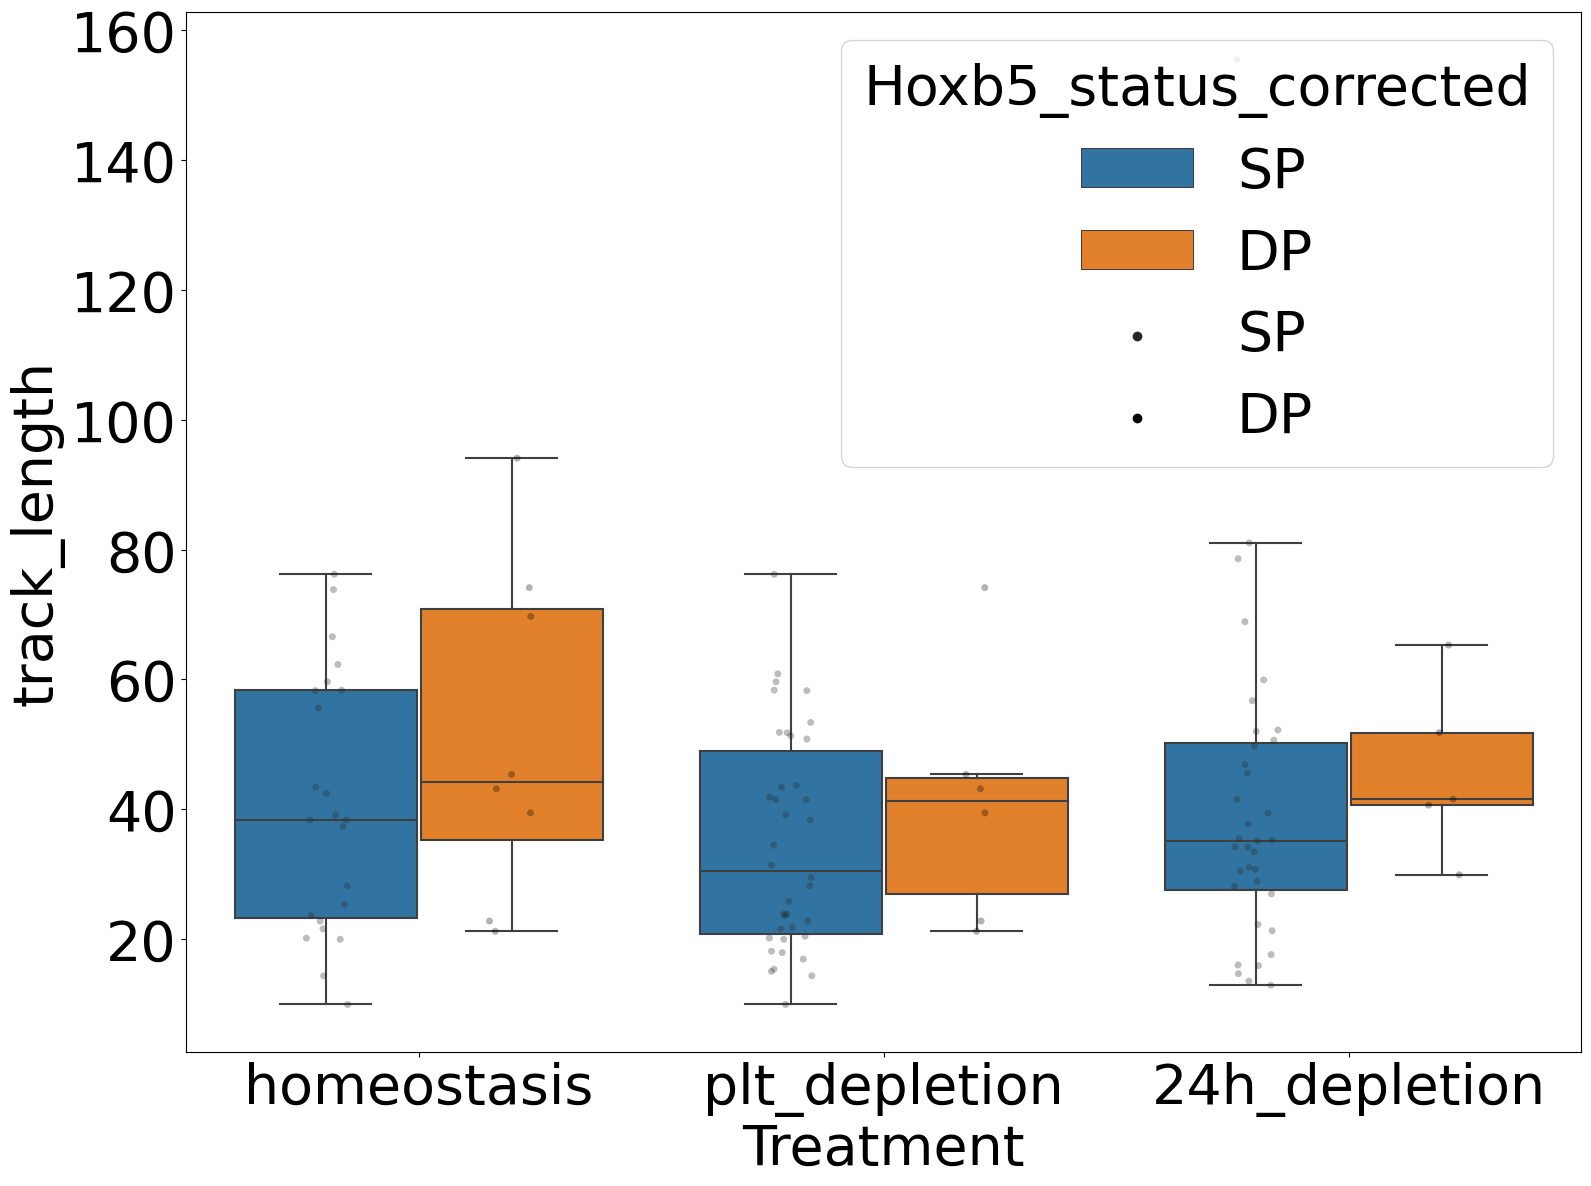

In [263]:
#PLOTTING RESULTS of track length
# 

#Either:
# datax=data
#Or
# data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)
data.dropna()
count_DP=0

#DP/SP Hoxb5_status
Hoxb5_cells=[]
Hoxb5Vwf_cells=[]

# print(len(data))
#CONSIDERS CELLS TO BE DP IF LABELLED AS DP IN 3 FRAMES MINIMUM
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
grouped=data.groupby(['Final_Cell_ID'])
# print(grouped)
for i, newdf in grouped:
    newdf=newdf[newdf['Hoxb5_status'] == 'DP']
    # newdf=newdf[newdf['MK_distance']>2] #ADD THIS NEW LINE!!!!!!
    count_DP=newdf.shape[0]
    # print(count_DP)
    # if count_DP > (len(newdf.index))/2:
    if count_DP > 5:#was 3
        Hoxb5Vwf_cells.append(i) #137
# # print(Hoxb5Vwf_cells)
    # dflist.append(newdf)
# datax=pd.concat(dflist)

Hoxb5Vwf_list=np.unique(Hoxb5Vwf_cells)
print(Hoxb5Vwf_list)


datax=data
datax['Hoxb5_status_corrected']='SP'
for i in datax.index:
    if datax.loc[i,'Final_Cell_ID'] in Hoxb5Vwf_list:
        datax.loc[i,'Hoxb5_status_corrected']='DP'
        # print('DP', i)
    # else:
        # datax.loc[i,'Hoxb5_status_corrected']='SP'
        # print('SP', i)
# print(datax)
# print(len(datax))
# dx=datax.drop_duplicates()
# print(len(dx))
# print(dx['Relative_treatment_Time']=='na')



#IS THIS THE RIGHT PLACE FOR IT?
# #CONSIDERS CELLS TO BE DP IF LABELLED AS DP IN 3 FRAMES MINIMUM
# #SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
# grouped=data.groupby(['Final_Cell_ID'])
# # print(grouped)
# for i, newdf in grouped:
#     newdf=newdf[newdf['Hoxb5_status'] == 'DP']
#     # newdf=newdf[newdf['MK_distance']>2] #ADD THIS NEW LINE!!!!!!
#     count_DP=newdf.shape[0]
#     # print(count_DP)
#     # if count_DP > (len(newdf.index))/2:
#     if count_DP > 3:
#         Hoxb5Vwf_cells.append(i) #137
# # # print(Hoxb5Vwf_cells)

# Hoxb5Vwf_list=np.unique(Hoxb5Vwf_cells)
# # print(Hoxb5Vwf_list)

# grouped=data.groupby(['Final_Cell_ID'])
# for i, newdf in grouped:
#     if i in Hoxb5Vwf_list:
#         newdf['Hoxb5_status_corrected']='DP'
#     else:
#         newdf['Hoxb5_status_corrected']='SP'
#     dflist.append(newdf)
# data=pd.concat(dflist)

# https://datavizpyr.com/boxplots-with-points-using-seaborn-in-python/
#https://seaborn.pydata.org/generated/seaborn.stripplot.html
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'track_length']]#or datax

df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=18:#was 11
        df_list.append(newdf)
        print(i)
datab=pd.concat(df_list)
# print(len(datab))


dx=datab.drop_duplicates()
dx=dx[dx['track_length']!=0]

# print(dx)
sns.boxplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="track_length", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/780754991.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/780754991.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P7++_1.5259021893143654e-05
VWF_045_MS211208_M2_movie3_P21_1.5259021893143654e-05
VWF_045_MS211208_M2_movie6_P24_1.5259021893143654e-05
VWF_048_MS220118_M3_movie2homeostasis_P12+_1.5259021893143654e-05
VWF_048_MS22

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='Track_length_in_timepoint'>

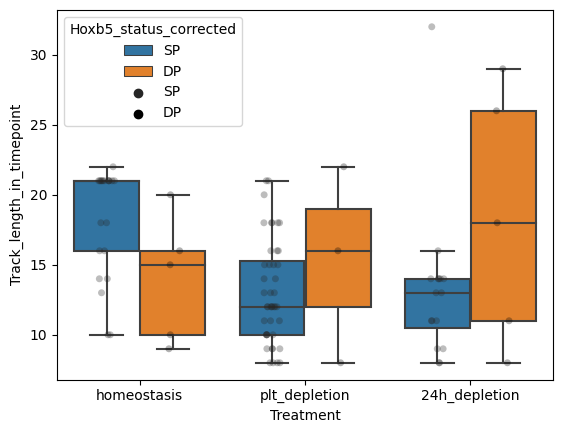

In [5]:
#ONLY RUN ONCE OTHERWISE TRACKED COEFFICIENT CHANGES!!!

datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'Nframes']]
# print(len(datab))

df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=8:#was 11
        df_list.append(newdf)
        print(i)
datab=pd.concat(df_list)

df_list =[]
datab['Tracked_coefficient']=None
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    newdf['Track_length_in_timepoint']=newdf.shape[0]
    for r in newdf.index:
        newdf.loc[r, 'Tracked_coefficient']=newdf.loc[r,'Track_length_in_timepoint']/newdf.loc[r,'Nframes']
    df_list.append(newdf)
datab=pd.concat(df_list)
# print(len(datab))
# datay=datax.groupby("Final_Cell_ID").agg([np.mean,np.std])
# print(datay)
# print(datab['Tracked_coefficient'])

# dx=datax.groupby(['Final_Cell_ID'])
# print(dx)
# for grouping_item, grouped_df in dx:
    # sns.boxplot(x=("Treatment"), hue='Hoxb5_status', y="track_length", data=grouped_df)
    # sns.stripplot(x=("Treatment"),hue='Hoxb5_status', y="track_length", data=grouped_df, dodge=True, color='black', alpha=0.3)

dx=datab.drop_duplicates()
# print(dx)
sns.boxplot(x=("Treatment"), hue='Hoxb5_status_corrected', y='Track_length_in_timepoint', data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y='Track_length_in_timepoint', data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


# sns.boxplot(x=("Treatment"), hue='Hoxb5_status_corrected', y='Tracked_coefficient', data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y='Tracked_coefficient', data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/470526284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/470526284.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/470526284.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of lengt

VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P7++_1.5259021893143654e-05
VWF_045_MS211208_M2_movie3_P21_1.5259021893143654e-05
VWF_045_MS211208_M2_movie6_P24_1.5259021893143654e-05
VWF_048_MS220118_M3_movie2homeostasis_P12+_1.5259021893143654e-05
VWF_048_MS22

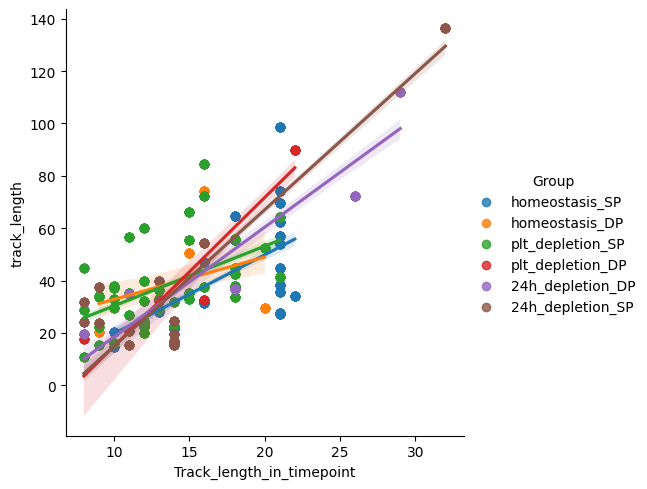

In [15]:
#PRINT TRACK LENGTH AS A FUNCTION OF TIME LENGTH 

datax=datax[datax['track_length']!=0]
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'Nframes', 'track_length']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
# print(len(datab))
datab.dropna()
df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=8:#was 11
        df_list.append(newdf)
        print(i)
datab=pd.concat(df_list)

df_list =[]
datab['Tracked_coefficient']=None
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    newdf['Track_length_in_timepoint']=newdf.shape[0]
    df_list.append(newdf)
datab=pd.concat(df_list)

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(12,9))#6,4.5
# g=sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab, hue='Hoxb5_status_corrected', style='Treatment')
# sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab, hue='Hoxb5_status_corrected', style='Treatment')

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
# sns.lineplot(data=datab, x="Track_length_in_timepoint", y="track_length", hue='Hoxb5_status_corrected', style='Treatment')
sns.lmplot(data=datab, x='Track_length_in_timepoint', y='track_length', hue='Group', col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, 
            hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, 
            seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, 
            facet_kws=None)
# g.set(ylim=(0, 200))


      cell_ID    condition  cell_type frame  max_distance
0         1.1  homeostasis      hoxb5     1      6.498524
21        1.2  homeostasis  Hoxb5_vwf     1      6.749050
42        1.3  homeostasis  Hoxb5_vwf     1      7.963815
63        2.1    depletion  Hoxb5_vwf     1     15.282667
104       3.1  homeostasis      hoxb5     1     17.671498
...       ...          ...        ...   ...           ...
1365     21.6       ageing      hoxb5     1     26.762669
1382     21.7       ageing  Hoxb5_vwf     1      6.943155
1403     21.8       ageing      hoxb5     1      6.216671
1424     21.9       ageing      hoxb5     1      5.921015
1445     22.1       ageing      hoxb5     1     12.491273

[62 rows x 5 columns]


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


sum_sq    df         F    PR(>F)
C(cell_type)                800.377438   1.0  7.736839  0.007436
C(condition)                326.676244   3.0  1.052604  0.376911
C(cell_type):C(condition)   164.394655   3.0  0.529706  0.663810
Residual                   5586.310229  54.0       NaN       NaN

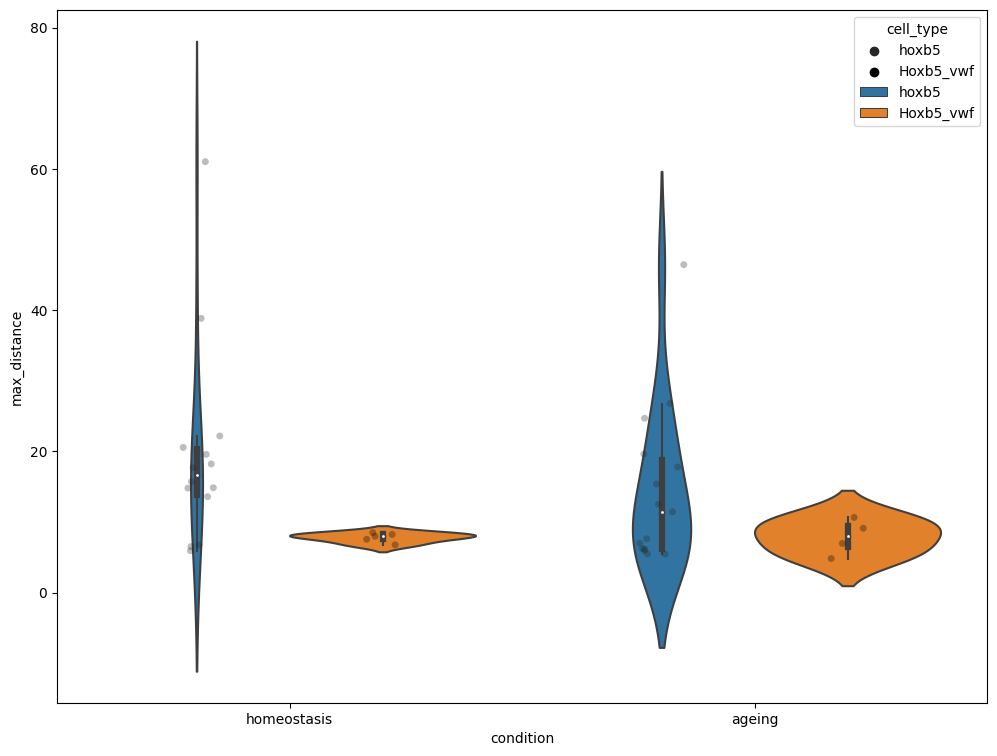

VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_1.5259021893143654e-05
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P5_1.5259021893143654e-05
VWF_043_MS211118_m1-p5_11_12_pltdepletionmovie_P5_1.5259021893143654e-05
VWF_043_MS211118_m1-p5_11_12_pltdepletionmovie_P5_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P7++_1.5259021893143654e-05
VWF_

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_58829/1780164711.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='max_displacement'>

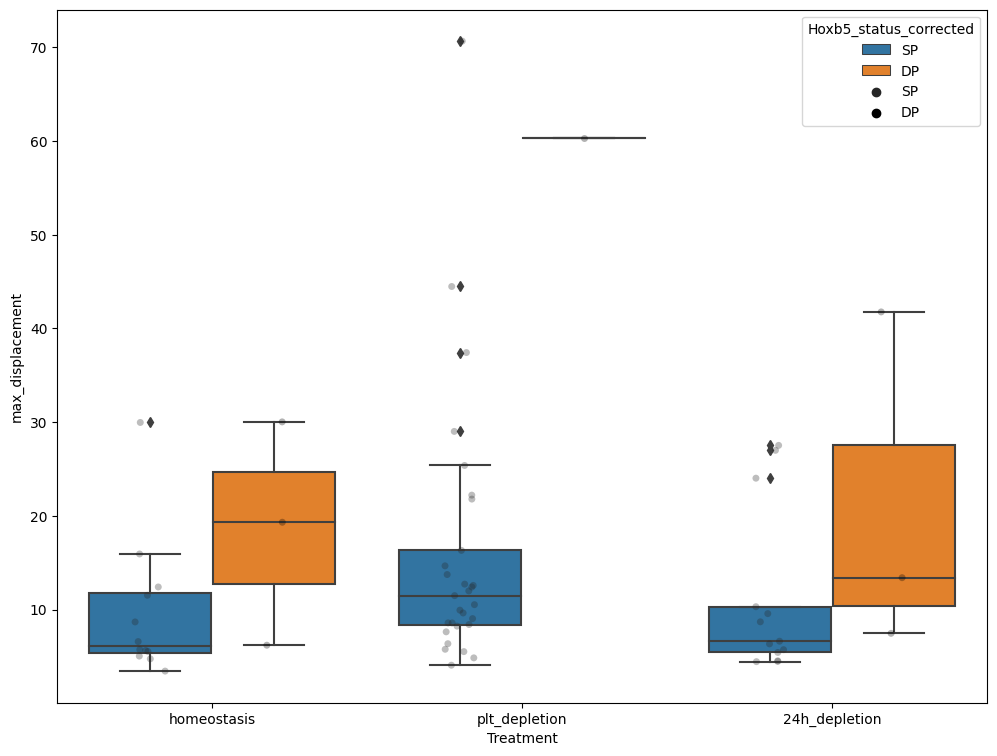

In [146]:
#PRINT MAXIMUM DISPLACEMENT

datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement']]
# print(len(datab))

df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=11:
        print(i)
        df_list.append(newdf)
datab=pd.concat(df_list)
# print(len(datab))
# datay=datax.groupby("Final_Cell_ID").agg([np.mean,np.std])
# print(datay)
# print(datab)

# dx=datax.groupby(['Final_Cell_ID'])
# print(dx)
# for grouping_item, grouped_df in dx:
    # sns.boxplot(x=("Treatment"), hue='Hoxb5_status', y="track_length", data=grouped_df)
    # sns.stripplot(x=("Treatment"),hue='Hoxb5_status', y="track_length", data=grouped_df, dodge=True, color='black', alpha=0.3)

dx=datab.drop_duplicates()
dx=dx[dx['max_displacement']!=0]
# print(dx)
sns.boxplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="max_displacement", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="max_displacement", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/3510204334.py:18: DtypeWarning: Columns (498,502,507,508,509,510,512,513,533) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/3510204334.py:25: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped: #new df is grouped data franes


VWF_043_MS211125_m3-homeostasis_movie.czi_M1
VWF_043_MS211125_m3-homeostasis_movie.czi_P4
VWF_043_MS211125_m3-homeostasis_movie2.czi_P4
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P18+
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P23+
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P32+
VWF_048_MS220118_M3_movie2homeostasis.czi_P12+
VWF_048_MS220118_M3_movie2homeostasis.czi_P13+
VWF_048_MS220118_M3_movie2homeostasis.czi_P14+
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P10spot
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P12DP
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P14touchMK
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P152kuo
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P9kuo2
VWF_053_MS220209_M1_movie2homeostasis.czi_P16DP
VWF_053_MS220209_M1_movie2homeostasis.czi_P26kuovascu
VWF_060_MS220408_M1_MOVIE1.czi_P11DP
VWF_060_MS220408_M1_MOVIE1.czi_P1DP
VWF_060_MS220408_M1_MOVIE1.czi_P8
VWF_060_MS220408_M1_MOVIE2.czi_P4GREENVESSEL
VWF_060_MS220408_M1_MOVIE3.czi_P10


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/3510204334.py:53: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/3510204334.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/3510204334.py:72: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of l

512     0
513     0
521     0
522     0
523     0
       ..
9697    0
9698    0
9699    0
9700    0
9701    0
Name: count_P, Length: 1706, dtype: int64


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


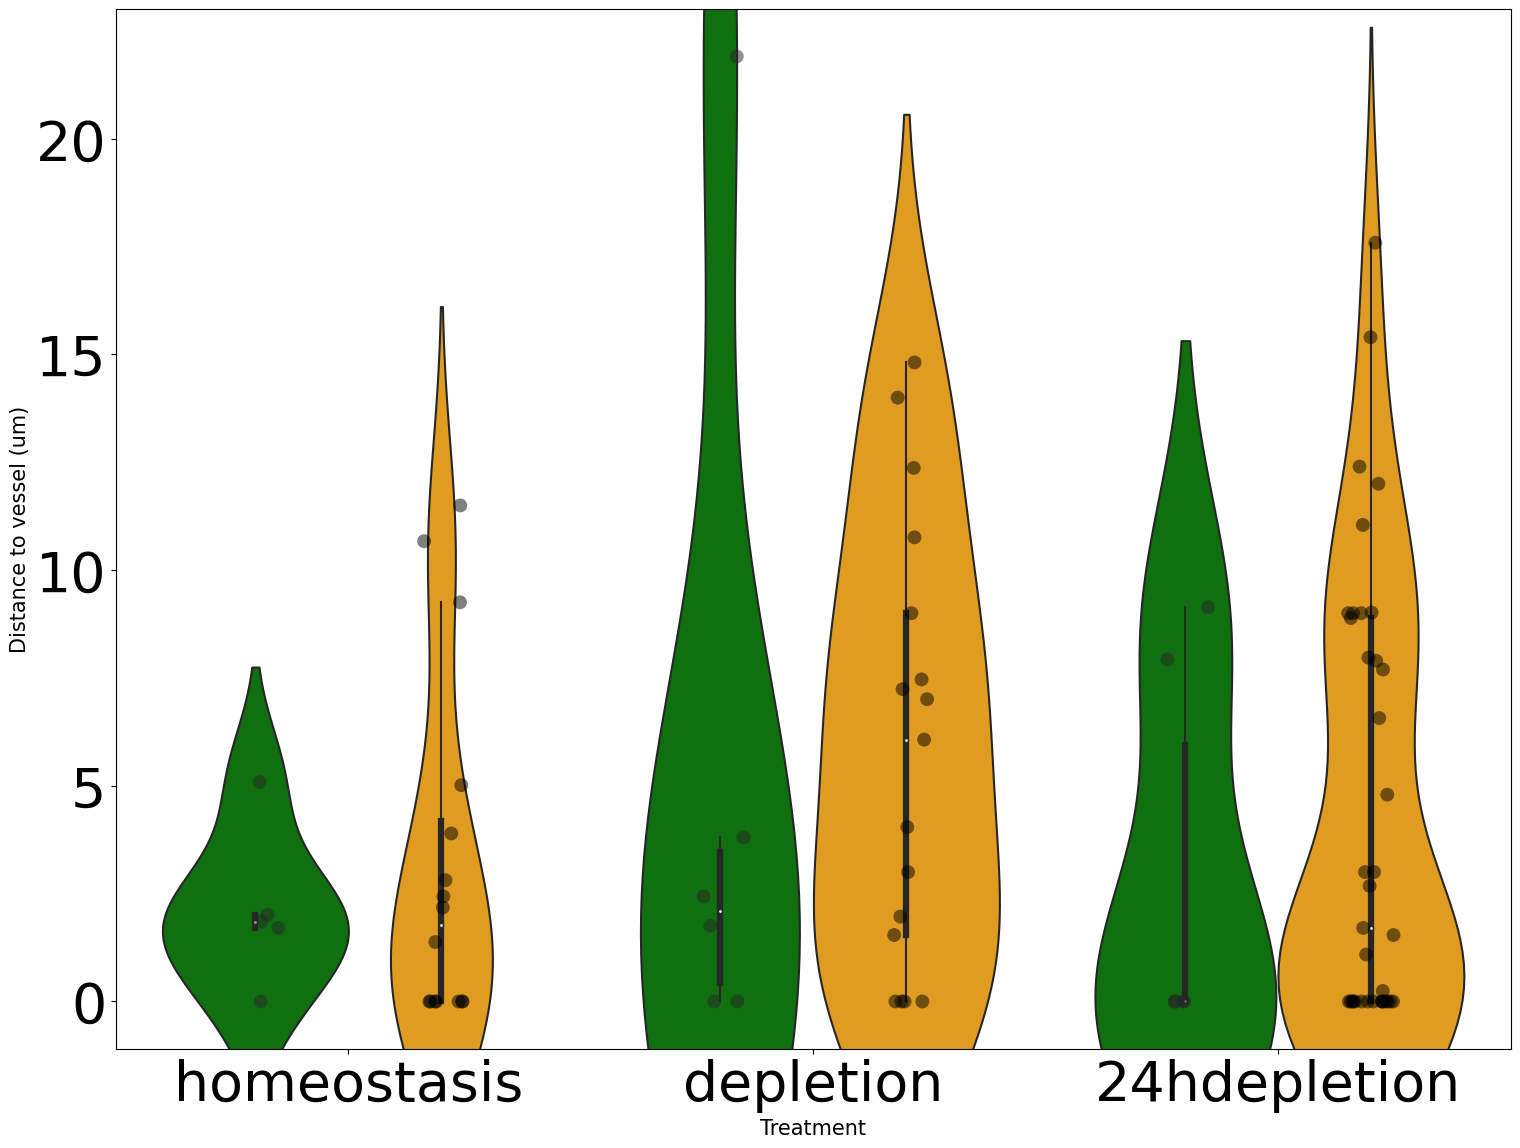

In [168]:
#NEIGHBOURHOOD ANALYSIS

# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 13.5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["font.size"]=40
# print ("New size:", fig_size)

data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)

data.drop_duplicates()
data['TrueTreatment']="none"
grouped=data.groupby(['Position_Name'])
grouped #list of dataframes
dflist=[]
for i, newdf in grouped: #new df is grouped data franes
    if newdf.shape[0]>1:
        # print(i)
        try: 
            trmttime=newdf[newdf['Treatment']=='plt_depletion']['Time of treatment'].values[0]#numpy array, get the first value
            newdf['TrueTreatment']=np.where(newdf['AcquisitionTime']<trmttime, 'Thomeostasis', 'Tdepletion')
        except:
            print(i)
    dflist.append(newdf)
data=pd.concat(dflist)

data=data[
    ((data['Treatment']=='homeostasis') & (data['TrueTreatment']=='Thomeostasis'))|
    ((data['Treatment']=='plt_depletion') & (data['TrueTreatment']=='Tdepletion'))|
    (data['TrueTreatment']=='none')
    ]
# print(len(data))

# data.dropna()

#DP/SP Hoxb5_status
Hoxb5Vwf_cells=['VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_1.5259021893143654e-05', 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_0.0001220721751451','VWF_053_MS220209_M1_movie3depletion_P16DP_1.5259021893143654e-05','VWF_053_MS220209_M1_movie2homeostasis_P16DP_9.155413135886192e-05','VWF_048_MS220119_M1_homeostasis_movie_3_P16DP_3.051804378628731e-05','VWF_048_MS220119_M1_homeostasis_movie_3_P17DP_3.051804378628731e-05','VWF_048_MS220118_M3_movie4plt_P6DP+_1.5259021893143654e-05','VWF_060_MS220408_M1_MOVIE5_P1_dp2_1.5259021893143654e-05','VWF_060_MS220408_M1_MOVIE5_P16_4.577706567943096e-05','VWF_066_MS220519_M2_movie2_P9DP_1.5259021893143654e-05','VWF_066_MS220522_M4_pmovie2_P4_dp_0.0001220721751451','VWF_091_MS230402_M2_movie_homeostasis_P8DP_1.5259021893143654e-05','VWF_091_MS230402_M2_movie_depletion_P8DP_1.5259021893143654e-05','VWF_102_MS230520_M3_24hdep_movie_P10_4.577706567943096e-05','VWF_102_MS230520_M3_24hdep_movie_P10_6.103608757257462e-05','VWF_102_MS230520_M4_24hdep_movie_P6_3.051804378628731e-05','VWF_109_MS230619_M1_movie_P3_7.629510946571827e-05','VWF_109_MS230619_M2_movie_P6dp_9.155413135886192e-05','VWF_109_MS230619_M2_movie_P7kuo_1.5259021893143654e-05']
dflist=[]
#DP STATUS MANUALLY CHECKED
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
data['Hoxb5_status_corrected']='SP'
grouped=data.groupby(['Final_Cell_ID'])
# print(grouped)
for i, newdf in grouped:
    if i in Hoxb5Vwf_cells:
        newdf['Hoxb5_status_corrected'] ='DP'
        # print(i)
        dflist.append(newdf)
    elif i not in Hoxb5Vwf_cells and len(newdf.index) >=18:
        # print(i)
        dflist.append(newdf)
datax=pd.concat(dflist)    
# print(datax[datax['Hoxb5_status_corrected']=='DP'])

datax=datax[datax['track_length']!=0]
# dx=dx[dx['Treatment'!=ageing]]
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'Intensity_MinIntensity_DistanceTransformMK','Intensity_MinIntensity_DistanceTransforprog', 'Intensity_MinIntensity_DistanceTransformAF647','Intensity_MinIntensity_DistanceTransforplt','Neighbors_FirstClosestDistance_RemovedObjectsSP_200','Scale_X','Neighbors_NumberOfNeighbors_RemovedObjectsSP_200' ]]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

#FOR NUMBER OF NEIGHBOURS ONLY
grouped=datax.groupby(['FileName_GFP']) #group by Metadata_VWF didn't work because sometimes track split and that creates more neighbours
dflist=[]
for i, newdf in grouped:
    newdf2=newdf['Final_Cell_ID']
    newdf2.drop_duplicates()
    newdf['count_P']=(newdf2.shape[0])-1
    newdf['Group']=newdf['Treatment']+'_'+newdf['Hoxb5_status_corrected']
    dflist.append(newdf)
datab=pd.concat(dflist)


datab['MK_median']=None
datab['AF647_median']=None
datab['SP_median']=None
grouped=datab.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['MK_median']=(newdf['Intensity_MinIntensity_DistanceTransformMK'].median())*(newdf['Scale_X'].median()*1000000)
    newdf['AF647_median']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()*(newdf['Scale_X'].median()*1000000)
    # newdf['DP_median']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()*(newdf['Scale_X'].median()*1000000)
    newdf['SP_median']=newdf['Neighbors_FirstClosestDistance_RemovedObjectsSP_200'].median()*(newdf['Scale_X'].median()*1000000)
    newdf['SP_nb']= newdf['Neighbors_NumberOfNeighbors_RemovedObjectsSP_200'].median()
    newdf['count_P_median']=newdf['count_P'].median()
    dflist.append(newdf)
datab=pd.concat(dflist)
print(datab['count_P'])



# for i, b in datab.iterrows():
    # if datab['SP_nb']

# dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'MK_median','Group']]
dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'AF647_median','Group']]
# dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'SP_median','Group']]
# dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'SP_nb','Group']]
# dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'count_P_median','Group']]
dx=dx.drop_duplicates()
# dx=dx.dropna()
# print(dx['MK_median'])
# print(dx['AF647_median'])

# #MK
dx['Treatment']=dx['Treatment'].str.replace(r'plt_depletion','depletion')
dx['Treatment']=dx['Treatment'].str.replace(r'24h_depletion','24hdepletion')
# print(dx['Treatment'])
# g=( sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="MK_median", data=dx, showfliers = False, palette=['green','orange'], hue_order=('DP','SP'), order=('homeostasis','depletion','24hdepletion')),sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="MK_median", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('DP','SP'), order =['homeostasis','depletion','24hdepletion']))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Distance to MK (um)')
# plt.show(g)
# model = ols('MK_median ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['MK_median'], dx['Treatment'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['MK_median'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['MK_median'], dx['Group'], alpha=0.05).summary()

# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="AF647_median", data=dx, showfliers = False, palette=['green','orange'], hue_order=('DP','SP'), order=('homeostasis','depletion','24hdepletion'))

##vessel

g=(sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="AF647_median", data=dx, showfliers = False, palette=['green','orange'], hue_order=('DP','SP'), order=('homeostasis','depletion','24hdepletion')), sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="AF647_median", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('DP','SP'), order =['homeostasis','depletion','24hdepletion']))
plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Distance to vessel (um)')
plt.show(g)
# model = ols('AF647_median ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['AF647_median'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['AF647_median'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['AF647_median'], dx['Group'], alpha=0.05).summary()

# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransformAF647", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransformAF647", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

#SP

# g=( sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="SP_median", data=dx, showfliers = False, palette=['green','orange'], hue_order=('DP','SP'), order=('homeostasis','plt_depletion','24h_depletion')),sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="SP_median", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('DP','SP'), order =['homeostasis','plt_depletion','24h_depletion']))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Distance to Kuo+ (um)')
# plt.show(g)
# model = ols('SP_median ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['SP_median'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['SP_median'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['SP_median'], dx['Group'], alpha=0.05).summary()

#PIE CHART WITH PROPORTION WITHOUT NEIGHBOURS AND WITH
# pied=(len(dx[dx['SP_nb']== '1']))
# print(pied)
# pied=(len(dx[dx['SP_nb']== '2']))
# print(pied)
# print(len(dx))
# plt.pie(, labels='Group', autopct='%.0f%%')
# plt.show()

# g=( sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="count_P_median", data=dx, showfliers = False, palette=['green','orange'], hue_order=('DP','SP'), order=('homeostasis','plt_depletion','24h_depletion')),sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="count_P_median", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('DP','SP'), order =['homeostasis','plt_depletion','24h_depletion']))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Number of Kuo+ neighbours')
# plt.show(g)

##plt
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforplt", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforplt", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

##MKP
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])





In [382]:
#export for morpheus

data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)

data.drop_duplicates()
data['TrueTreatment']="none"
grouped=data.groupby(['Position_Name'])
grouped #list of dataframes
dflist=[]
for i, newdf in grouped: #new df is grouped data franes
    if newdf.shape[0]>1:
        # print(i)
        try: 
            trmttime=newdf[newdf['Treatment']=='plt_depletion']['Time of treatment'].values[0]#numpy array, get the first value
            newdf['TrueTreatment']=np.where(newdf['AcquisitionTime']<trmttime, 'Thomeostasis', 'Tdepletion')
        except:
            print(i)
    dflist.append(newdf)
data=pd.concat(dflist)

data=data[
    ((data['Treatment']=='homeostasis') & (data['TrueTreatment']=='Thomeostasis'))|
    ((data['Treatment']=='plt_depletion') & (data['TrueTreatment']=='Tdepletion'))|
    (data['TrueTreatment']=='none')
    ]
# print(len(data))

# data.dropna()

#DP/SP Hoxb5_status
Hoxb5Vwf_cells=['VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_1.5259021893143654e-05', 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_0.0001220721751451','VWF_053_MS220209_M1_movie3depletion_P16DP_1.5259021893143654e-05','VWF_053_MS220209_M1_movie2homeostasis_P16DP_9.155413135886192e-05','VWF_048_MS220119_M1_homeostasis_movie_3_P16DP_3.051804378628731e-05','VWF_048_MS220119_M1_homeostasis_movie_3_P17DP_3.051804378628731e-05','VWF_048_MS220118_M3_movie4plt_P6DP+_1.5259021893143654e-05','VWF_060_MS220408_M1_MOVIE5_P1_dp2_1.5259021893143654e-05','VWF_060_MS220408_M1_MOVIE5_P16_4.577706567943096e-05','VWF_066_MS220519_M2_movie2_P9DP_1.5259021893143654e-05','VWF_066_MS220522_M4_pmovie2_P4_dp_0.0001220721751451','VWF_091_MS230402_M2_movie_homeostasis_P8DP_1.5259021893143654e-05','VWF_091_MS230402_M2_movie_depletion_P8DP_1.5259021893143654e-05','VWF_102_MS230520_M3_24hdep_movie_P10_4.577706567943096e-05','VWF_102_MS230520_M3_24hdep_movie_P10_6.103608757257462e-05','VWF_102_MS230520_M4_24hdep_movie_P6_3.051804378628731e-05','VWF_109_MS230619_M1_movie_P3_7.629510946571827e-05','VWF_109_MS230619_M2_movie_P6dp_9.155413135886192e-05','VWF_109_MS230619_M2_movie_P7kuo_1.5259021893143654e-05']
dflist=[]
#DP STATUS MANUALLY CHECKED
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
data['Hoxb5_status_corrected']='SP'
grouped=data.groupby(['Final_Cell_ID'])
# print(grouped)
for i, newdf in grouped:
    if i in Hoxb5Vwf_cells:
        newdf['Hoxb5_status_corrected'] ='DP'
        # print(i)
        dflist.append(newdf)
    elif i not in Hoxb5Vwf_cells and len(newdf.index) >=3:
        # print(i)
        dflist.append(newdf)
datax=pd.concat(dflist)    

# datax.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728_morpheus.csv')

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/1423274146.py:3: DtypeWarning: Columns (498,502,507,508,509,510,512,513,533) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/track_param_cp_230728.csv", header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/1423274146.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped: #new df is grouped data franes


VWF_043_MS211125_m3-homeostasis_movie.czi_M1
VWF_043_MS211125_m3-homeostasis_movie.czi_P4
VWF_043_MS211125_m3-homeostasis_movie2.czi_P4
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P18+
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P23+
VWF_043_MS211125_m3-homeostasis_movie5_1.5x.czi_P32+
VWF_048_MS220118_M3_movie2homeostasis.czi_P12+
VWF_048_MS220118_M3_movie2homeostasis.czi_P13+
VWF_048_MS220118_M3_movie2homeostasis.czi_P14+
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P10spot
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P12DP
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P14touchMK
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P152kuo
VWF_049_MS220201_M1_Snap_movie4homeostasis.czi_P9kuo2
VWF_053_MS220209_M1_movie2homeostasis.czi_P16DP
VWF_053_MS220209_M1_movie2homeostasis.czi_P26kuovascu
VWF_060_MS220408_M1_MOVIE1.czi_P11DP
VWF_060_MS220408_M1_MOVIE1.czi_P1DP
VWF_060_MS220408_M1_MOVIE1.czi_P8
VWF_060_MS220408_M1_MOVIE2.czi_P4GREENVESSEL
VWF_060_MS220408_M1_MOVIE3.czi_P10


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/1423274146.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/240048576.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3446/240048576.py:31: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


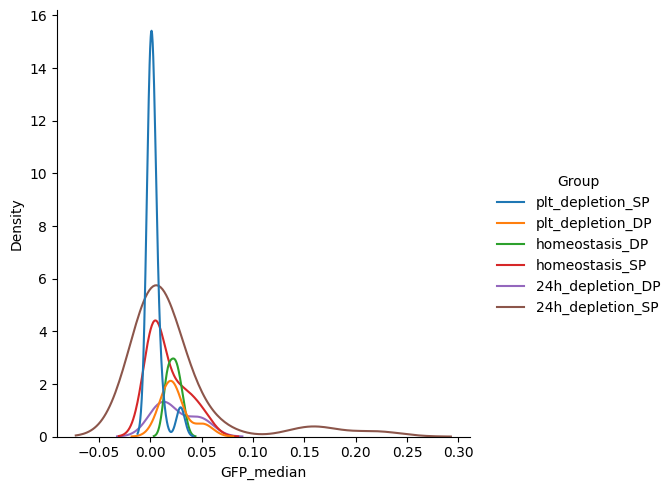

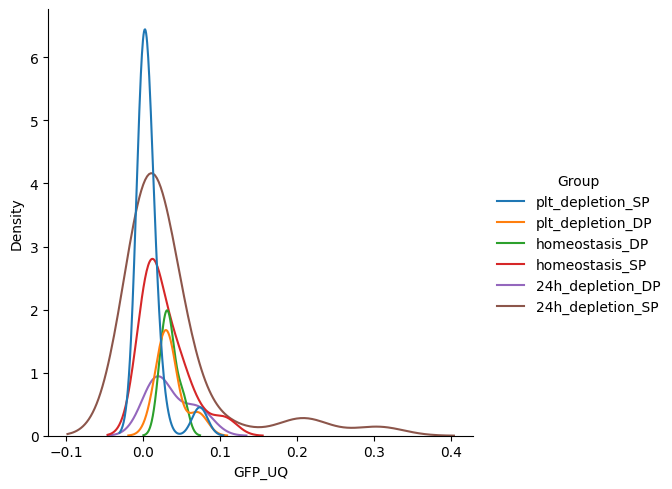

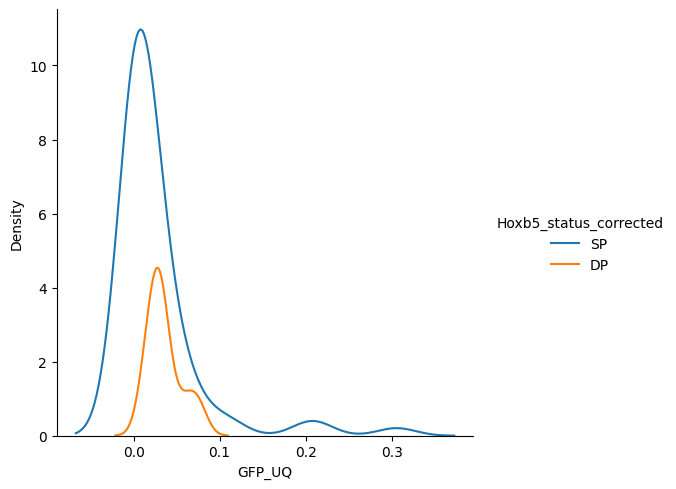

In [352]:
#TRYING TO DEFINE BETTER CRITERIAS TO DISTINGUISH SP AND DP
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 13.5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["font.size"]=10

datax['Group']=datax['Treatment']+'_'+datax['Hoxb5_status_corrected']
# sns.displot(datax, x="Intensity_MedianIntensity_GFP", hue="Group", kind="kde")
# sns.displot(datax, x="Intensity_StdIntensity_GFP", hue="Group", kind="kde")
# sns.displot(datax, x="Intensity_UpperQuartileIntensity_GFP", hue="Group", kind="kde")


datax['GFP_median']=None
grouped=datax.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['GFP_median']=newdf['Intensity_MedianIntensity_GFP'].median()
    dflist.append(newdf)
datab=pd.concat(dflist)

dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'GFP_median','Group']]
dx=dx.drop_duplicates()
dx=dx.dropna()

sns.displot(dx, x="GFP_median", hue="Group", kind="kde")

datax['GFP_UQ']=None
grouped=datax.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['GFP_UQ']=newdf['Intensity_UpperQuartileIntensity_GFP'].median()
    dflist.append(newdf)
datab=pd.concat(dflist)

dx=datab[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'GFP_UQ','Group']]
dx=dx.drop_duplicates()
dx=dx.dropna()

sns.displot(dx, x="GFP_UQ", hue="Group", kind="kde")
sns.displot(dx, x="GFP_UQ", hue="Hoxb5_status_corrected", kind="kde")

In [66]:
#'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP', 
d=pd.read_csv('/Users/secchim/Downloads/manual_tracks230711.csv', header=0)
# print(d['Hoxb5_status_corrected'].unique())
dd=d[d['Hoxb5_status_corrected']=='Hoxb5_vwf']
print(dd['file'].unique())
#25 first characters of the file name

#VWF_053_MS220209_M1_movie3depletion_P16DP_1.5259021893143654e-05

d['FileID']=d['file'].str[0:19]
print(d['FileID'].unique())
print(len(d['FileID'].unique()))

['VWF_049_MS220201_M1_Snap_movie4homeostasis_[ii2_VWF_049_MS220201_M1_Snap_movie4homeostasis_Image_3]_Statistics'
 'VWF_049_MS220201_M1_Snap_movie5depletion_[ii2_VWF_049_MS220201_M1_Snap_movie5depletion_Image_3]_Statistics'
 'VWF_053_MS220209_M1_movie3depletion_[ii2_VWF_053_MS220209_M1_movie3depletion_Image_3]_Statistics'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii2_VWF_053_MS220209_M1_movie2homeostasis_Image_3]_Statistics'
 'VWF_048_MS220119_M1_homeostasis_movie_3_[ii1_VWF_048_MS220119_M1_homeostasis_movie_3_Image_2]driftcorrected_Statistics'
 'VWF_048_MS220118_M3_movie2homeostasis_[ii2_VWF_048_MS220118_M3_movie2homeostasis_Image_3]_Statistics'
 'VWF_048_MS220118_M3_movie1plt_[ii0_VWF_048_MS220118_M3_movie1plt_Image_1]_Statistics'
 'VWF_060_MS220408_M1_MOVIE5_[ii0_VWF_060_MS220408_M1_MOVIE5_Image_1]_Statistics'
 'VWF_060_MS220408_M1_MOVIE5_[ii2_VWF_060_MS220408_M1_MOVIE5_Image_3]_Statistics'
 'VWF_062_MS220421_M2_movie_[ii1_VWF_062_MS220421_M2_movie_Image_2]_Statistics'
 'VWF_065_MS22

<AxesSubplot: xlabel='Treatment', ylabel='Intensity_MinIntensity_DistanceTransforprog'>

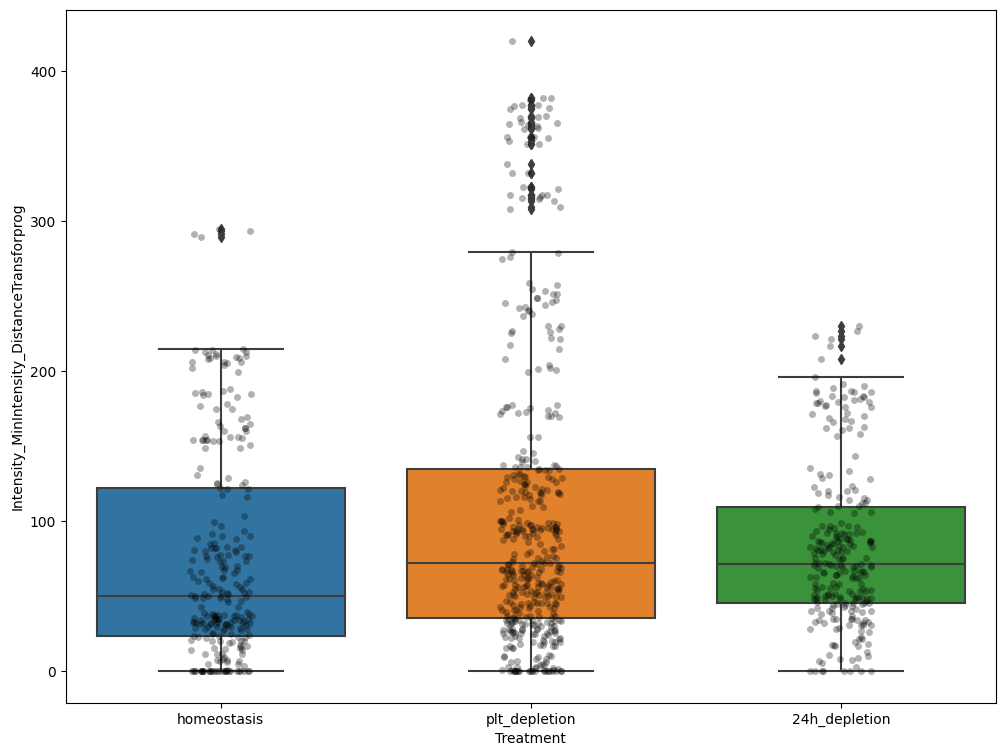

In [225]:

# #MK
# sns.boxplot(x=("Treatment"), y="Intensity_MinIntensity_DistanceTransformMK", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"), y="Intensity_MinIntensity_DistanceTransformMK", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

##plt
# sns.boxplot(x=("Treatment"),  y="Intensity_MinIntensity_DistanceTransforplt", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"), y="Intensity_MinIntensity_DistanceTransforplt", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

#MKP
sns.boxplot(x=("Treatment"), y="Intensity_MinIntensity_DistanceTransforprog", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"), y="Intensity_MinIntensity_DistanceTransforprog", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


    ImageNumber  ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0          1410             1                 NaN                    NaN   
1          1410             2                 NaN                    NaN   
2          1410             3                 NaN                    NaN   
3          1411             1                 NaN                    NaN   
4          1411             2                 NaN                    NaN   
5          1411             3                 NaN                    NaN   
6          1411             4                 NaN                    NaN   
7          1411             5                 NaN                    NaN   
8          1412             1                 NaN                    NaN   
9          1412             2                 NaN                    NaN   
10         1413             1                 NaN                    NaN   
11         1413             2                 NaN                    NaN   
12         1

<AxesSubplot: xlabel='Treatment', ylabel='AreaShape_Volume'>

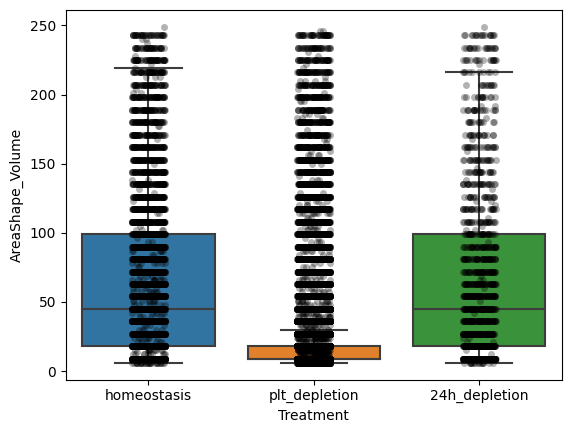

In [34]:
#SMALL GFP OUT

#if movies are in lots of different folders
file_list=[]
folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'
for root,dirs, files in os.walk(folderpath):
    for file in files:
        if file.endswith('out.csv'):
            # file_list.append(os.path.join(root,file))
            data=pd.read_csv(os.path.join(root,file), index_col=None, header=0)
            file_list.append(data)

dataout=pd.concat(file_list, axis =0, ignore_index=True)

# metadata=pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv')

# metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
dataout=pd.merge(dataout, metadata[:], on = 'Metadata_VWF')
# data['Final_Cell_ID']=data['Track_ID']
print(data)

data.dropna()

datab=dataout[['Metadata_VWF', 'Treatment', 'ObjectNumber','AreaShape_Volume' ]]
# print(len(datab))

dx=datab.drop_duplicates()

# #MK
sns.boxplot(x=('Treatment'),  y="AreaShape_Volume", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=('Treatment'), y="AreaShape_Volume", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/1883762099.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


[(0.0, 1500.0)]

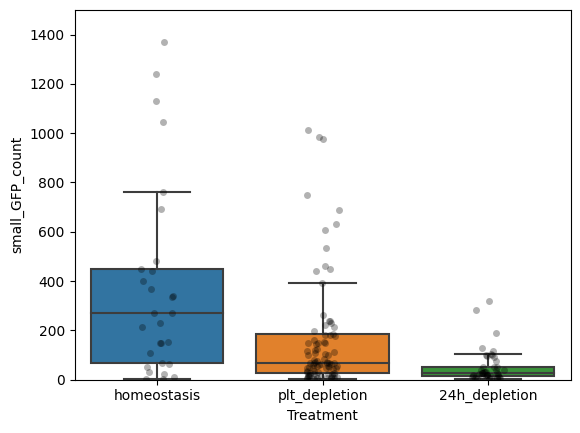

In [38]:
df_list =[]
datab['small_GFP_count']=None
grouped=datab.groupby(['Metadata_VWF'])
for i, newdf in grouped:
    newdf['small_GFP_count']=newdf.shape[0]
    df_list.append(newdf)
datab=pd.concat(df_list)

dx=datab[['Metadata_VWF', 'small_GFP_count', 'Treatment' ]].drop_duplicates()
g=sns.boxplot(x=('Treatment'),  y='small_GFP_count', data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
g.set(ylim=(0, 1500))
gg=sns.stripplot(x=('Treatment'), y='small_GFP_count', data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])
gg.set(ylim=(0, 1500))


In [65]:
#MK protrusions

#if movies are in lots of different folders
file_list=[]
folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/'
for root,dirs, files in os.walk(folderpath):
    for file in files:
        if file.endswith('MK.csv'):
            # file_list.append(os.path.join(root,file))
            data=pd.read_csv(os.path.join(root,file), index_col=None, header=0)
            file_list.append(data)

dataout=pd.concat(file_list, axis =0, ignore_index=True)

metadata=pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv')

metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
dataout=pd.merge(dataout, metadata[:], on = 'Metadata_VWF')
# data['Final_Cell_ID']=data['Track_ID']
print(dataout)

dataout.dropna()

datab=dataout[['Metadata_VWF', 'Treatment', 'ObjectNumber','AreaShape_MajorAxisLength', 'AreaShape_MinorAxisLength', 'AreaShape_Volume' ]]
datab['MK_protrusion']=None
for i in datab.index:
    datab.loc[i,'MK_protrusion']=datab.loc[i,'AreaShape_MajorAxisLength']/datab.loc[i,'AreaShape_MinorAxisLength']

# print(len(datab))


# dataout.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/230201MK_check.csv')


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/2889491007.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/2889491007.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['MK_protrusion']=None


       ImageNumber  ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0              727             1                 NaN                    NaN   
1              727             2                 NaN                    NaN   
2              727             3                 NaN                    NaN   
3              727             4                 NaN                    NaN   
4              728             1                 NaN                    NaN   
...            ...           ...                 ...                    ...   
16014         1421             3                 NaN                    NaN   
16015         1421             4                 NaN                    NaN   
16016         1421             5                 NaN                    NaN   
16017         1421             6                 NaN                    NaN   
16018         1421             7                 NaN                    NaN   

       Metadata_Format1  Metadata_Format2  Metadata

11105    2.110917
11106    2.110917
11107    2.110917
11108    2.110917
11109    2.110917
           ...   
1804     2.187530
1805     2.187530
1806     2.187530
1807     2.187530
1808     2.187530
Name: mean_protrusion, Length: 16019, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/2573214294.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


<AxesSubplot: xlabel='Treatment', ylabel='mean_protrusion'>

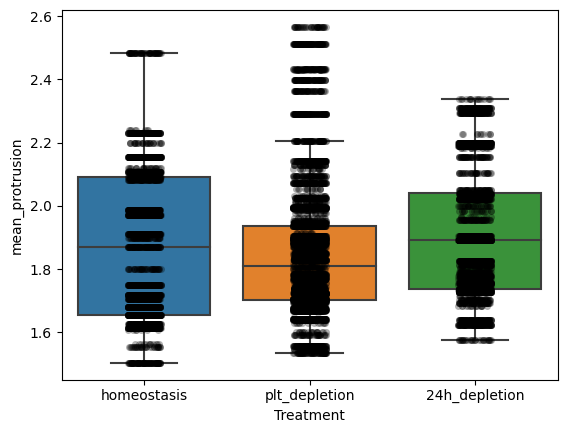

In [56]:
# #MK

#MK mean protrusion
dx['mean_protrusion']=None
grouped=datab.groupby(['Metadata_VWF'])
dflist=[]
for i, newdf in grouped:
    newdf['mean_protrusion']=newdf['MK_protrusion'].mean()
    dflist.append(newdf)
dx=pd.concat(dflist)
print(dx['mean_protrusion'])


dx=dx.drop_duplicates()
# dx=dx[dx['Metadata_Timepoint'==1]] #error 
sns.boxplot(x=('Treatment'),  y="mean_protrusion", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=('Treatment'), y="mean_protrusion", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])
# sns.violinplot(x=("Treatment"), hue='blue', y="mean_protrusion", data=dx, order =['homeostasis','plt_depletion','24h_depletion'])#error maybe because everytimepoint 


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/1024327156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx['MK_count']=10
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/1024327156.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


11105    3
11106    3
11107    3
11108    4
11109    4
        ..
1694     9
1695     9
1696     9
1697     9
1698     9
Name: MK_count, Length: 16019, dtype: int64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/1024327156.py:20: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


11105    1
11106    1
11107    1
11108    1
11109    1
        ..
1694     7
1695     7
1696     7
1697     7
1698     7
Name: min_MK_count, Length: 16019, dtype: int64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/1024327156.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


11105     4
11106     4
11107     4
11108     4
11109     4
         ..
1694     12
1695     12
1696     12
1697     12
1698     12
Name: max_MK_count, Length: 16019, dtype: int64


<AxesSubplot: xlabel='Treatment', ylabel='max_MK_count'>

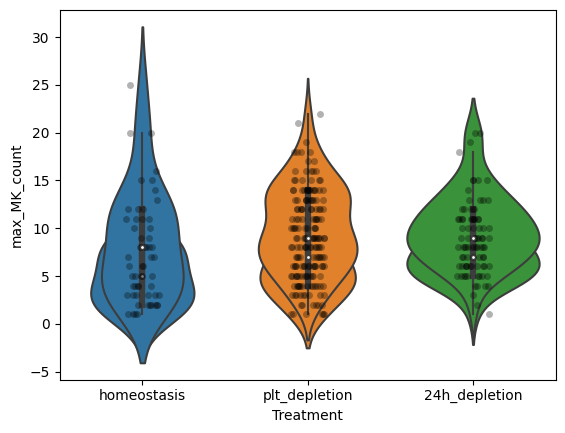

In [87]:
#MK minimum numbers per movie

dx=dataout[['Metadata_VWF', 'Treatment', 'FileName_GFP']]

dx['MK_count']=10
# grouped=dx.groupby('AcquisitionTime')['Metadata_VWF']
grouped=dx.groupby(['FileName_GFP'])
dflist=[]
for i, newdf in grouped:
    for b, r in newdf.iterrows():
        newdf.loc[b,'MK_count']=newdf.shape[0]
    dflist.append(newdf)
dx=pd.concat(dflist)
print(dx['MK_count'])

dx['min_MK_count']=10
grouped=dx.groupby(['Metadata_VWF'])
dflist=[]

for i, newdf in grouped:
    for b, r in newdf.iterrows():
        newdf.loc[b,'min_MK_count']=(newdf['MK_count'].min())
    dflist.append(newdf)
dx=pd.concat(dflist)
print(dx['min_MK_count'])

dxx=dx[['Metadata_VWF', 'Treatment', 'min_MK_count']]
dxx=dxx.drop_duplicates()
# dx=dx[dx['Metadata_Timepoint'==1]] #error 
# sns.boxplot(x=('Treatment'),  y="min_MK_count", data=dxx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=('Treatment'), y="min_MK_count", data=dxx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"), y="min_MK_count", data=dxx, order =['homeostasis','plt_depletion','24h_depletion'])#error maybe because everytimepoint 

dx['max_MK_count']=10
grouped=dx.groupby(['Metadata_VWF'])
dflist=[]

for i, newdf in grouped:
    for b, r in newdf.iterrows():
        newdf.loc[b,'max_MK_count']=(newdf['MK_count'].max())
    dflist.append(newdf)
dx=pd.concat(dflist)
print(dx['max_MK_count'])

dxx=dx[['Metadata_VWF', 'Treatment', 'max_MK_count']]
dxx=dxx.drop_duplicates()
# dx=dx[dx['Metadata_Timepoint'==1]] #error 
# sns.boxplot(x=('Treatment'),  y="max_MK_count", data=dxx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=('Treatment'), y="max_MK_count", data=dxx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"), y="max_MK_count", data=dxx, order =['homeostasis','plt_depletion','24h_depletion'])#error maybe because everytimepoint 



/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/1114267924.py:9: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/1114267924.py:24: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/1114267924.py:34: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


['VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05'
 'VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05'
 'VWF_048_MS220118_M3_movie2homeostasis_P6DP+_1.5259021893143654e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_3.051804378628731e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_6.103608757257462e-05'
 'VWF_048_MS220119_M1_homeostasis_movie_3_P16DP_1.5259021893143654e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_6.103608757257462e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_7.629510946571827e-05'
 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.5259021893143654e-05'
 'VWF_049_MS220201_M1_Snap_movie5depletion_P12DP_1.5259021893143654e-05'
 'VWF_053_MS220209_M1_movie2homeostasis_P16DP_1.5259021893143654e-05'
 'VWF_053_MS220209_M1_movie3depletion_P16DP_1.5259021893143654e-05'
 'VWF_053_MS220209_M1_movie4depletion_P16DP_1.5259021893143654e-05'
 'VWF_053_MS220209_M1_movie5depletion_P16DP_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/1114267924.py:55: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


<AxesSubplot: xlabel='Final_Cell_ID', ylabel='Intensity_UpperQuartileIntensity_GFP'>

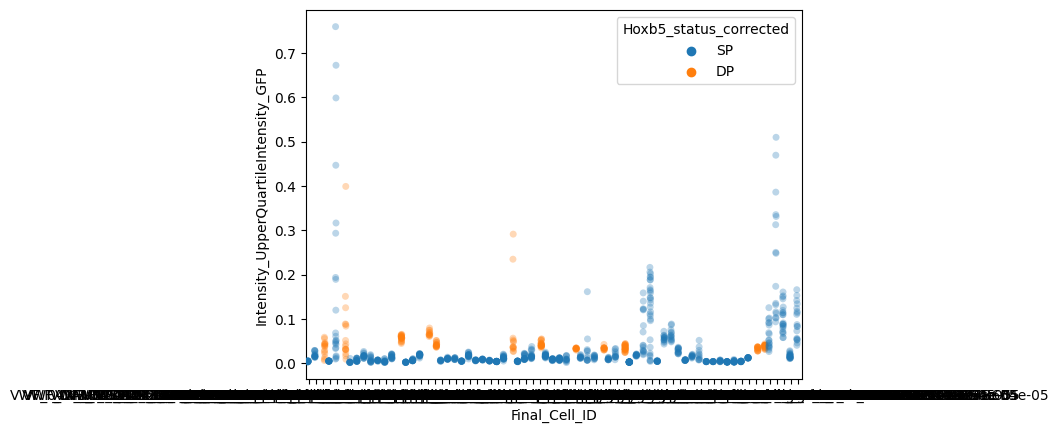

In [154]:
#FINDING THE RIGHT MEANINTENSITYGFP FOR DP
# 
#Either:
# datax=data
#Or
data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
data.dropna()
count_DP=0

#DP/SP Hoxb5_status
Hoxb5_cells=[]
Hoxb5Vwf_cells=[]



# print(len(data))
#CONSIDERS CELLS TO BE DP IF LABELLED AS DP IN 3 FRAMES MINIMUM
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
grouped=data.groupby(['Final_Cell_ID'])

for i, newdf in grouped:
    newdf=newdf[newdf['Hoxb5_status'] == 'DP']
    newdf=newdf[newdf['Intensity_MinIntensity_DistanceTransformMK']>1] #ADD THIS NEW LINE!!!!!!
    count_DP=newdf.shape[0]
    # print(count_DP)
    # if count_DP > (len(newdf.index))/2:
    if count_DP > 2:#was 3
        Hoxb5Vwf_cells.append(i) #137


for i, newdf in grouped:
    newdf=newdf[newdf['Intensity_MinIntensity_DistanceTransformMK']>1] #ADD THIS NEW LINE!!!!!!
    newdf=newdf[newdf['Intensity_UpperQuartileIntensity_GFP']>0.03] #ADD THIS NEW LINE!!!!!!
    count_DP=newdf.shape[0]
    # print(count_DP)
    # if count_DP > (len(newdf.index))/2:
    if count_DP > 3:#was 3
        Hoxb5Vwf_cells.append(i) #137

Hoxb5Vwf_list=np.unique(Hoxb5Vwf_cells)
print(Hoxb5Vwf_list)


datax=data
datax['Hoxb5_status_corrected']='SP'
for i in datax.index:
    if datax.loc[i,'Final_Cell_ID'] in Hoxb5Vwf_list:
        datax.loc[i,'Hoxb5_status_corrected']='DP'

df_list =[]
grouped=datax.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=11:#was 11
        df_list.append(newdf)
        print(i)
datab=pd.concat(df_list)
# print(len(datab))

sns.stripplot(x=("Final_Cell_ID"),hue='Hoxb5_status_corrected', y="Intensity_UpperQuartileIntensity_GFP", data=datab, dodge=True, alpha=0.3)


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


TypeError: __init__() got an unexpected keyword argument 'axis_fontsize'

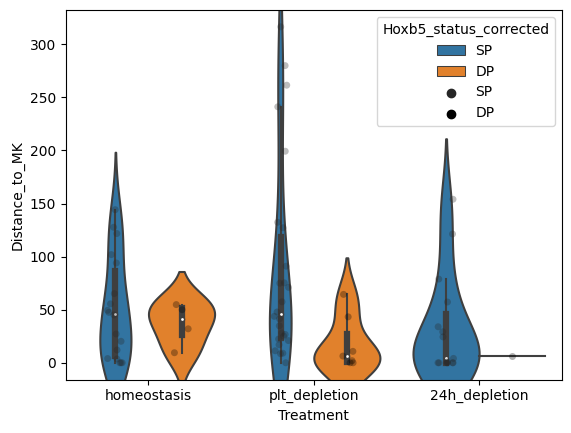

In [129]:
#NEIGHBOURHOOD ANALYSIS - MK with changed DP


# datab=datab[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'Intensity_MinIntensity_DistanceTransformMK','Intensity_MinIntensity_DistanceTransforprog', 'Intensity_MinIntensity_DistanceTransformAF647','Intensity_MinIntensity_DistanceTransforplt','Last_timepoint' ]]

# datab['MK_median']=0
# grouped=datab.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     for b, r in newdf.iterrows():
#         if newdf.loc[b,'Treatment']=='homeostasis':
#             newdf.loc[b,'Distance_to_MK']=newdf['Intensity_MinIntensity_DistanceTransformMK'].median()
#         elif newdf.loc[b,'Treatment']=='plt_depletion':
#             x=newdf[newdf['Last_timepoint']==True]
#             newdf.loc[b,'Distance_to_MK']=x['Intensity_MinIntensity_DistanceTransformMK'].max()
#             print(newdf.loc[b,'Distance_to_MK'])
#         elif newdf.loc[b,'Treatment']=='24h_depletion':
#             newdf.loc[b,'Distance_to_MK']=newdf['Intensity_MinIntensity_DistanceTransformMK'].median()
#     dflist.append(newdf)
# data=pd.concat(dflist)


# datab=data[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'Distance_to_MK']]

# dx=datab.drop_duplicates()

###INCREASING FONT SIZE
## ax = sns.stripplot(x="sex", y="total_bill", hue="day", data=tips, jitter=True)
## plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
## plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
## plt.show()

# #MK
sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Distance_to_MK", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Distance_to_MK", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])
plt.legend(fontsize='x-large', title_fontsize='40')
model = ols('Distance_to_MK ~  C(Hoxb5_status_corrected) + C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

sm.stats.multicomp.pairwise_tukeyhsd(dx['Distance_to_MK'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['Distance_to_MK'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()

##plt
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforplt", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforplt", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

##MKP
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<class 'statsmodels.iolib.table.SimpleTable'>

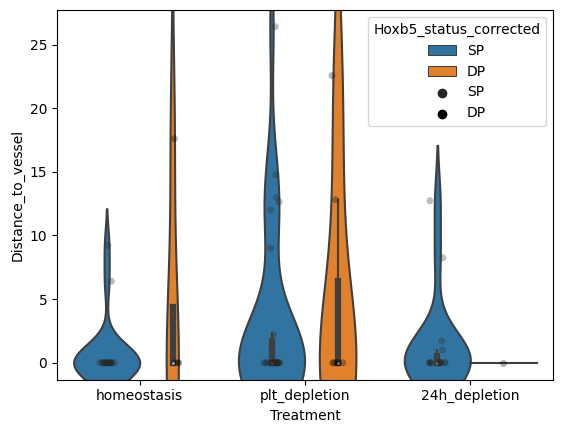

In [91]:
# datab=datab[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'Intensity_MinIntensity_DistanceTransformMK','Intensity_MinIntensity_DistanceTransforprog', 'Intensity_MinIntensity_DistanceTransformAF647','Intensity_MinIntensity_DistanceTransforplt','Last_timepoint' ]]

# datab['MK_median']=0
# grouped=datab.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     for b, r in newdf.iterrows():
#         if newdf.loc[b,'Treatment']=='homeostasis':
#             newdf.loc[b,'Distance_to_vessel']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()
#         elif newdf.loc[b,'Treatment']=='plt_depletion':
#             x=newdf[newdf['Last_timepoint']==True]
#             newdf.loc[b,'Distance_to_vessel']=x['Intensity_MinIntensity_DistanceTransformAF647'].max()
#             print(newdf.loc[b,'MK_median'])
#         elif newdf.loc[b,'Treatment']=='24h_depletion':
#             newdf.loc[b,'Distance_to_vessel']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()
#     dflist.append(newdf)
# data=pd.concat(dflist)


# datab=data[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'Distance_to_vessel']]

# dx=datab.drop_duplicates()


##vessel
sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Distance_to_vessel", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Distance_to_vessel", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

model = ols('Distance_to_vessel ~  C(Hoxb5_status_corrected) + C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

# sm.stats.multicomp.pairwise_tukeyhsd(dx['Distance_to_vessel'], dx['Treatment'], alpha=0.05).summary()
sm.stats.multicomp.pairwise_tukeyhsd(dx['Distance_to_vessel'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()



/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/316273021.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
12.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
26.39678955078125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


sum_sq      df          F        PR(>F)
C(Hoxb5_status_corrected)    542.088131     1.0  18.501298  1.840189e-05
C(Treatment)                1338.255191     2.0  22.837115  1.868999e-10
Residual                   34105.206781  1164.0        NaN           NaN

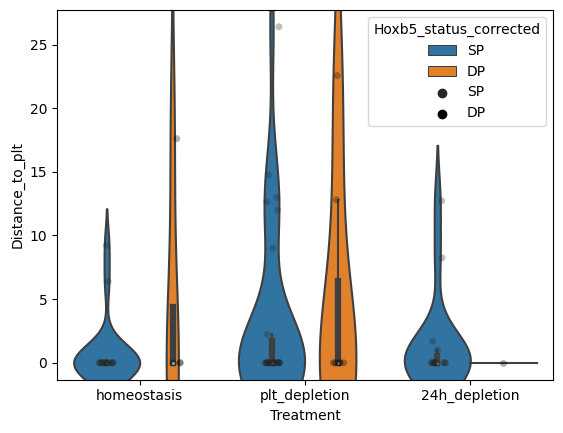

In [72]:
datab=datab[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'Intensity_MinIntensity_DistanceTransformMK','Intensity_MinIntensity_DistanceTransforprog', 'Intensity_MinIntensity_DistanceTransformAF647','Intensity_MinIntensity_DistanceTransforplt','Last_timepoint' ]]

datab['MK_median']=0
grouped=datab.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    for b, r in newdf.iterrows():
        if newdf.loc[b,'Treatment']=='homeostasis':
            newdf.loc[b,'Distance_to_plt']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()
        elif newdf.loc[b,'Treatment']=='plt_depletion':
            x=newdf[newdf['Last_timepoint']==True]
            newdf.loc[b,'Distance_to_plt']=x['Intensity_MinIntensity_DistanceTransformAF647'].max()
            print(newdf.loc[b,'Distance_to_plt'])
        elif newdf.loc[b,'Treatment']=='24h_depletion':
            newdf.loc[b,'Distance_to_plt']=newdf['Intensity_MinIntensity_DistanceTransformAF647'].median()
    dflist.append(newdf)
data=pd.concat(dflist)


datab=data[['Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'Distance_to_plt']]

dx=datab.drop_duplicates()


##plt
sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Distance_to_plt", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Distance_to_plt", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])

model = ols('Distance_to_plt ~  C(Hoxb5_status_corrected) + C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

# sm.stats.multicomp.pairwise_tukeyhsd(dx['Distance_to_plt'], dx['Treatment'], alpha=0.05).summary()


##MKP
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx,  order =['homeostasis','plt_depletion','24h_depletion'], showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="Intensity_MinIntensity_DistanceTransforprog", data=dx, dodge=True, color='black', alpha=0.3,  order =['homeostasis','plt_depletion','24h_depletion'])


In [53]:


# perform one-way ANOVA for MK count #could add time
# model = ols('MK_count ~  C(Treatment)', data=dx).fit()
model = ols('max_MK_count ~  C(Treatment)', data=dxx).fit()
sm.stats.anova_lm(model, typ=2)

NameError: name 'dxx' is not defined

In [60]:


#perform two-way ANOVA for MK distance
# model = ols('Intensity_MinIntensity_DistanceTransformMK ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

# model = ols('Intensity_MinIntensity_DistanceTransformAF647 ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

# model = ols('Intensity_MinIntensity_DistanceTransforprog ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

model = ols('Intensity_MinIntensity_DistanceTransforplt ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)

#not tested yet
tukey = pairwise_tukeyhsd(endog=df['Intensity_MinIntensity_DistanceTransforplt'],
                          groups=df['Hoxb5_status_corrected'],
                          alpha=0.05)

sum_sq      df           F  \
C(Hoxb5_status_corrected)               3.910593e+03     1.0    0.883111   
C(Treatment)                            3.378793e+06     2.0  381.508406   
C(Hoxb5_status_corrected):C(Treatment)  2.407698e+04     2.0    2.718595   
Residual                                1.041070e+07  2351.0         NaN   

                                               PR(>F)  
C(Hoxb5_status_corrected)                3.474476e-01  
C(Treatment)                            3.226156e-144  
C(Hoxb5_status_corrected):C(Treatment)   6.617475e-02  
Residual                                          NaN

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


sum_sq      df         F  \
C(Hoxb5_status_corrected)                 10.058838     1.0  1.973667   
C(Treatment)                              30.497225     2.0  2.991964   
C(Hoxb5_status_corrected):C(Treatment)     3.062193     2.0  0.300420   
Residual                                8939.300060  1754.0       NaN   

                                          PR(>F)  
C(Hoxb5_status_corrected)               0.160236  
C(Treatment)                            0.050445  
C(Hoxb5_status_corrected):C(Treatment)  0.740545  
Residual                                     NaN

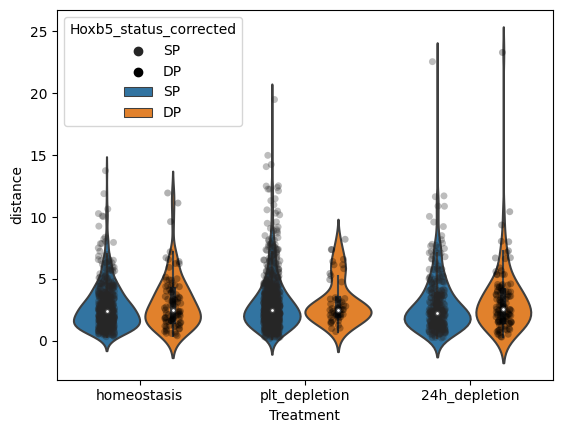

In [67]:
#QC plot
# 
dx=datax[datax['max_displacement']!=0]
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=dx, dodge=True, order =['homeostasis','plt_depletion','24h_depletion'])
# dx.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/qc.csv')
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="frame_speed", data=dx, dodge=True, order =['homeostasis','plt_depletion','24h_depletion'])

dx.dropna()

##DISTANCE VIOLIN PLOT
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=dx, dodge=True, color='black', alpha=0.3, order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=dx, order =['homeostasis','plt_depletion','24h_depletion'])

model = ols('distance ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


sum_sq      df         F    PR(>F)
C(Hoxb5_status_corrected)               0.000263     1.0  1.953473  0.162390
C(Treatment)                            0.000680     2.0  2.526184  0.080254
C(Hoxb5_status_corrected):C(Treatment)  0.000048     2.0  0.177313  0.837533
Residual                                0.235945  1754.0       NaN       NaN

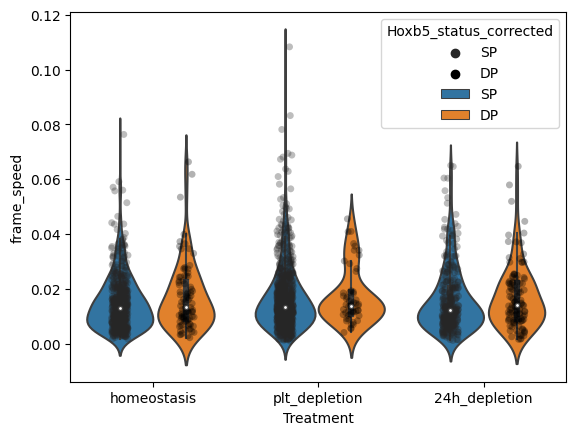

In [68]:
###FRAME SPEED VIOLIN PLOT
dx=datax[datax['frame_speed']!=0]
dx.dropna()
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="frame_speed", data=dx, dodge=True, color='black', alpha=0.3, order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="frame_speed", data=dx, order =['homeostasis','plt_depletion','24h_depletion'])
model = ols('frame_speed ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


sum_sq      df          F  \
C(Hoxb5_status_corrected)                 0.117586     1.0   1.844136   
C(Treatment)                              4.166749     2.0  32.674305   
C(Hoxb5_status_corrected):C(Treatment)    1.035871     2.0   8.122967   
Residual                                129.819146  2036.0        NaN   

                                              PR(>F)  
C(Hoxb5_status_corrected)               1.746174e-01  
C(Treatment)                            1.078203e-14  
C(Hoxb5_status_corrected):C(Treatment)  3.063660e-04  
Residual                                         NaN

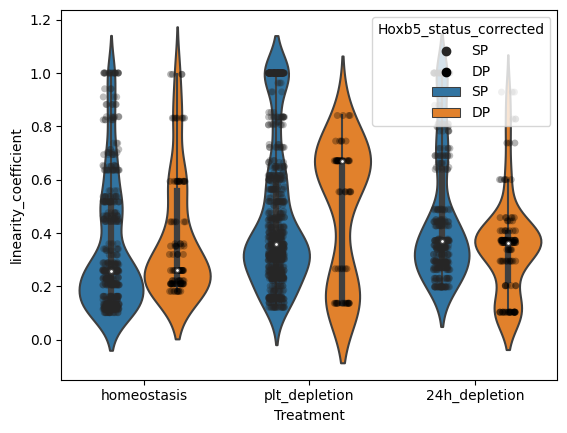

In [71]:
##LINEARITY COEFFICIENT VIOLIN PLOT
dx=data[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'linearity_coefficient']]
dx.dropna()

#THIS LINE EXCLUDES THE CELLS THAT ARE NOT REALLY MOVING
# dx=dx[dx['max_displacement']>10]

dx.drop_duplicates()
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, order =['homeostasis','plt_depletion','24h_depletion'])
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, color='black', alpha=0.3, order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, order =['homeostasis','plt_depletion','24h_depletion'])

model = ols('linearity_coefficient ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)

                                          Final_Cell_ID      Treatment  \
0     VWF_043_MS211125_m3-homeostasis_movie2_M1_1.52...    homeostasis   
1     VWF_043_MS211125_m3-homeostasis_movie2_M1_1.52...    homeostasis   
6     VWF_043_MS211125_m3-homeostasis_movie2_P4_1.52...    homeostasis   
7     VWF_043_MS211125_m3-homeostasis_movie2_P4_1.52...    homeostasis   
8     VWF_043_MS211125_m3-homeostasis_movie2_P4_1.52...    homeostasis   
...                                                 ...            ...   
2351  VWF_066_MS220522_M4_pmovie2_P4_dp_1.5259021893...  24h_depletion   
2352  VWF_066_MS220522_M4_pmovie2_P4_dp_1.5259021893...  24h_depletion   
2353  VWF_066_MS220522_M4_pmovie2_P4_dp_1.5259021893...  24h_depletion   
2354  VWF_066_MS220522_M4_pmovie2_P4_dp_1.5259021893...  24h_depletion   
2355  VWF_066_MS220522_M4_pmovie2_P4_dp_1.5259021893...  24h_depletion   

     Hoxb5_status_corrected  arrest_coefficient  
0                        SP            0.000000  
1          

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='arrest_coefficient'>

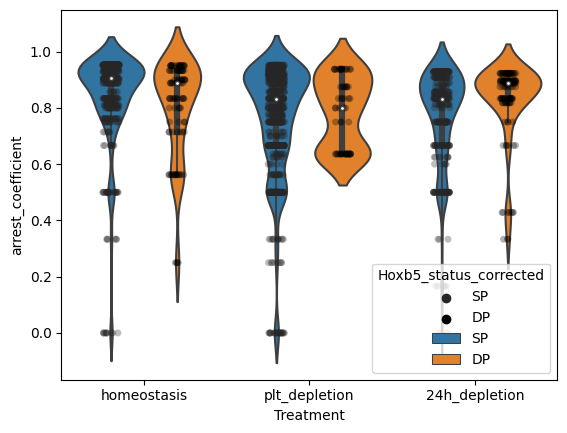

In [80]:
#ARREST COEFFICIENT VIOLIN PLOT

dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'arrest_coefficient']]
#WASN'T WORKING BECAUSE SOME FALSE 
dx=dx[dx['arrest_coefficient']!='FALSE']
dx=dx[dx['arrest_coefficient']!='false']
dx=dx[dx['arrest_coefficient']!='False']

#THIS LINE EXCLUDES THE CELLS THAT ARE NOT REALLY MOVING
# dx=dx[dx['max_displacement']>10]

dx.dropna()
dx.drop_duplicates()
dx = dx.astype({"arrest_coefficient": np.float16})
print(dx)
# # sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, order =['homeostasis','plt_depletion','24h_depletion'])
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, dodge=True, color='black', alpha=0.3, order =['homeostasis','plt_depletion','24h_depletion'])
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, order =['homeostasis','plt_depletion','24h_depletion'])

In [81]:
model = ols('arrest_coefficient ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq      df          F  \
C(Hoxb5_status_corrected)                0.060020     1.0   1.773175   
C(Treatment)                             1.998633     2.0  29.522849   
C(Hoxb5_status_corrected):C(Treatment)   0.402790     2.0   5.949814   
Residual                                68.916412  2036.0        NaN   

                                              PR(>F)  
C(Hoxb5_status_corrected)               1.831387e-01  
C(Treatment)                            2.295040e-13  
C(Hoxb5_status_corrected):C(Treatment)  2.651859e-03  
Residual                                         NaN

VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P7++_1.5259021893143654e-05
VWF_045_MS211208_M2_movie3_P21_1.5259021893143654e-05
VWF_045_MS211208_M2_movie6_P24_1.5259021893143654e-05
VWF_048_MS220118_M3_movie2homeostasis_P12+_1.5259021893143654e-05
VWF_048_MS22

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/1265687739.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


[(0.0, 0.15)]

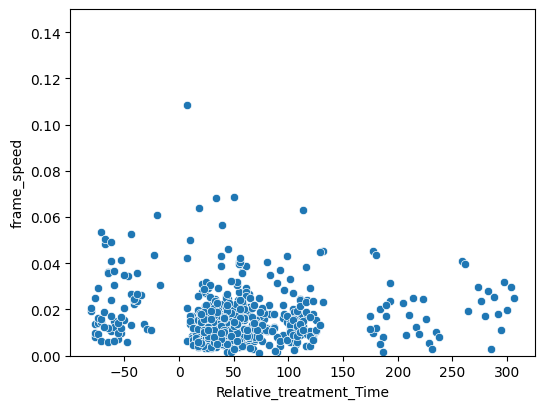

In [87]:
import statistics
import seaborn as sns
# sns.reset_defaults()

df_list =[]
grouped=datax.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=8:#was 11
        print(i)
        df_list.append(newdf)
datab=pd.concat(df_list)


# # datab=datab.dropna(axis=0, subset=['Relative_treatment_Time'])
# datax['Relative_treatment_Time'] = datax['Relative_treatment_Time'].astype(float)
# sns.scatterplot(x="Relative_treatment_Time", y="frame_speed",hue='Hoxb5_status_corrected', data=datab)


#stripplot not suitable, x axis looks terrible
#sns.stripplot(x=("Relative_treatment_Time"),hue='Hoxb5_status_corrected', y="frame_speed", data=datax, dodge=True, legend='brief')
#scatter plot doesn't allow dodge
# plt.scatter(x=("Relative_treatment_Time"), y="frame_speed", data=datax[datax['Hoxb5_status_corrected']=='SP'], color='orange', alpha=0.3)
# plt.scatter(x=("Relative_treatment_Time"), y="frame_speed", data=datax[datax['Hoxb5_status_corrected']=='DP'], color='green', alpha=0.3)

# sns.scatterplot(x="Relative_treatment_Time", y="distance", hue='Hoxb5_status_corrected', palette='pastel', data=datax)

# datax.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/wrong.csv')

##SEPARATING HOXB5+vwf- AND HOXB5-vwf+ CELLS
dx=datab[datab['Hoxb5_status_corrected']=='SP']#DP
dx=dx[dx['Treatment']=='plt_depletion']

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
fig, ax = plt.subplots(figsize=(6,4.5))
dx=dx[dx['Relative_treatment_Time']!=0]
g=sns.scatterplot(x="Relative_treatment_Time", y="frame_speed", data=dx)
g.set(ylim=(0, 0.15))



[(0.0, 0.15)]

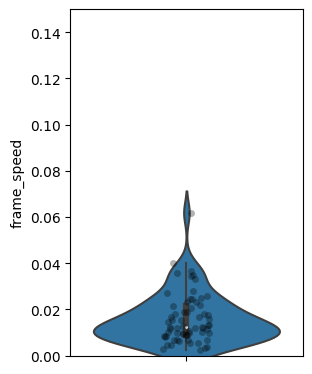

In [88]:
##PLOTTING HOMEOSTASIS OF TREATED MICE
# dx=dx[dx['Relative_treatment_Time']<0]
# g=sns.scatterplot(x="Relative_treatment_Time", y="frame_speed", data=dx)
# g.set(ylim=(0, 0.21))

dx=datab[datab['Hoxb5_status_corrected']=='DP']
dx=dx[dx['Treatment']=='homeostasis']

# #PLOTTING HOMEOSTASIS OF UNTREATED MICE
fig, ax = plt.subplots(figsize=(3,4.5))
dx=dx[dx['Relative_treatment_Time']==0]
g=sns.violinplot(y="frame_speed", data=dx)
gg=sns.stripplot( y="frame_speed", data=dx, dodge=True, color='black', alpha=0.3)
# g.set(xlim=(-1, 1))
g.set(ylim=(0, 0.15))
# gg.set(xlim=(-1, 1))
gg.set(ylim=(0, 0.15))

##PLOTING DEPLETION ONLY
# dx=dx[dx['Treatment_corrected']=='Depletion']
# g=sns.scatterplot(x="Relative_treatment_Time", y="frame_speed", data=dx)
# g.set(ylim=(0, 0.21))


# sns.scatterplot(x="Track_ID", y="frame_speed",hue='track_length', data=dx)
# sns.scatterplot(x="Relative_treatment_Time", y="frame_speed",hue='track_length', data=dx)


# sns.scatterplot(x="Relative_treatment_Time", y="frame_speed",hue='track_length', data=datab[datab['Hoxb5_status_corrected']=='DP'])

[(0.0, 0.21)]

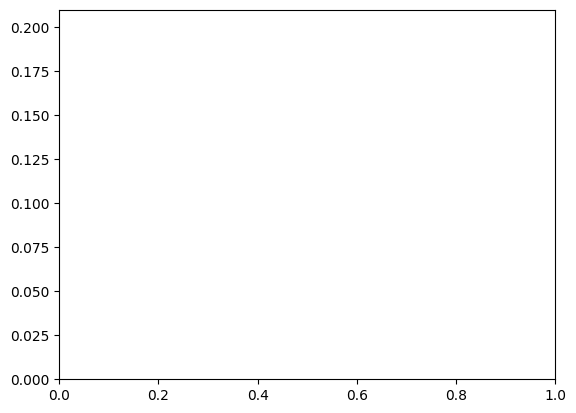

In [86]:
#PLOTING DEPLETION ONLY
dx=dx[dx['Treatment']!='homeostasis']
# dx=dx[dx['Treatment_corrected']=='Depletion']
g=sns.scatterplot(x="Relative_treatment_Time", y="frame_speed", data=dx)
g.set(ylim=(0, 0.21))


# sns.scatterplot(x="Track_ID", y="frame_speed",hue='track_length', data=dx)
# sns.scatterplot(x="Relative_treatment_Time", y="frame_speed",hue='track_length', data=dx)


# sns.scatterplot(x="Relative_treatment_Time", y="frame_speed",hue='track_length', data=datab[datab['Hoxb5_status_corrected']=='DP'])

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/3290296941.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_3.051804378628731e-05
VWF_043_MS211126_m4-pltdepletionmovie3_P7++_1.5259021893143654e-05
VWF_045_MS211208_M2_movie3_P21_1.5259021893143654e-05
VWF_045_MS211208_M2_movie6_P24_1.5259021893143654e-05
VWF_048_MS220118_M3_movie2homeostasis_P12+_1.5259021893143654e-05
VWF_048_MS22

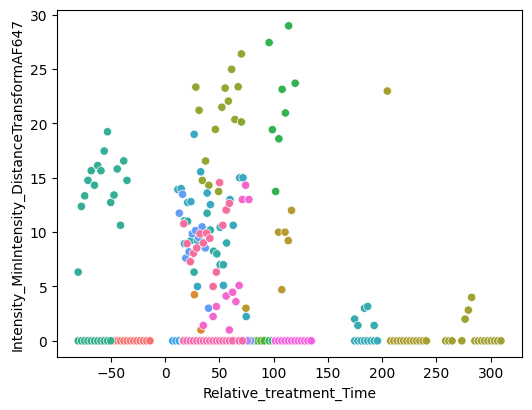

In [151]:
#PLOTTING DISTANCE TO CELL TYPE IN RELATION TO TIME

import statistics
import seaborn as sns
# sns.reset_defaults()

df_list =[]
grouped=datax.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=8:#was 11
        print(i)
        df_list.append(newdf)
datab=pd.concat(df_list)


##SEPARATING HOXB5+vwf- AND HOXB5-vwf+ CELLS
dx=datab[datab['Hoxb5_status_corrected']=='SP']#DP
dx=dx[dx['Treatment']=='plt_depletion']

# ##PLOTTING TREATED MICE to MK
# # figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(6,4.5))
# dx=dx[dx['Relative_treatment_Time']!=0]
# g=sns.scatterplot(x="Relative_treatment_Time", y="Intensity_MinIntensity_DistanceTransformMK", data=dx, hue="Final_Cell_ID", legend=False)
# # g.set(ylim=(0, 0.000002))

# ##PLOTTING TREATED MICE to vessel
fig, ax = plt.subplots(figsize=(6,4.5))
dx=dx[dx['Relative_treatment_Time']!=0]
g=sns.scatterplot(x="Relative_treatment_Time", y="Intensity_MinIntensity_DistanceTransformAF647", data=dx, hue="Final_Cell_ID", legend=False)


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/338598043.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


12      0.000000
13      0.485550
14     -2.859779
15     -0.404053
16      0.316940
          ...   
2345    0.000000
2346    0.000000
2347    0.000000
2348    0.000000
2349    0.000000
Name: norm_dist_MK, Length: 1168, dtype: float64


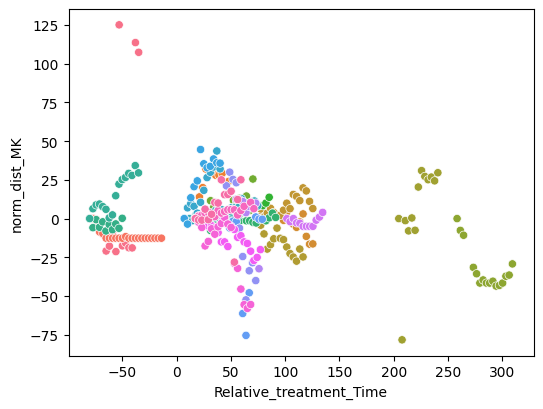

In [157]:
#NORMALIZING distances TO the distance in the first timepoint
#do on the unique Cell_ID rather than Track_ID

datab['norm_dist_MK']=datab['Intensity_MinIntensity_DistanceTransformMK']
datab['norm_dist_MK_origin']=0
grouped=datab.groupby(['Final_Cell_ID'])

dflist=[]
# print(grouped)
for i, newdf in grouped:
    newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]#or '0'?
    norm_0=newdf2['Intensity_MinIntensity_DistanceTransformMK'].values
    newdf['norm_dist_MK_origin']=[norm_0[0]]*len(newdf)#you could create pd.Series
    # print(newdf['norm_x'])
    newdf['norm_dist_MK']=((newdf['Intensity_MinIntensity_DistanceTransformMK']-newdf['norm_dist_MK_origin']))
    # print(newdf['corrected_x_2'])
    
    dflist.append(newdf)
datac=pd.concat(dflist)
print(datac['norm_dist_MK'])

#NPLOTTING THE ORMALIZED distances TO the distance in the first timepoint (BLOOD VESSEL)
##SEPARATING HOXB5+vwf- AND HOXB5-vwf+ CELLS
dx=datac[datac['Hoxb5_status_corrected']=='SP']#DP
dx=dx[dx['Treatment']=='plt_depletion']


fig, ax = plt.subplots(figsize=(6,4.5))
dx=dx[dx['Relative_treatment_Time']!=0]
g=sns.scatterplot(x="Relative_treatment_Time", y="norm_dist_MK", data=dx, hue="Final_Cell_ID", legend=False)


In [155]:
#NORMALIZING distances TO the distance in the first timepoint
#do on the unique Cell_ID rather than Track_ID

datab['norm_dist_AF647']=datab['Intensity_MinIntensity_DistanceTransformAF647']
datab['norm_dist_AF647_origin']=0
grouped=datab.groupby(['Final_Cell_ID'])

dflist=[]
# print(grouped)
for i, newdf in grouped:
    newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]#or '0'?
    norm_0=newdf2['Intensity_MinIntensity_DistanceTransformAF647'].values
    newdf['norm_dist_AF647_origin']=[norm_0[0]]*len(newdf)#you could create pd.Series
    # print(newdf['norm_x'])
    newdf['norm_dist_AF647']=((newdf['Intensity_MinIntensity_DistanceTransformAF647']-newdf['norm_dist_AF647_origin']))
    # print(newdf['corrected_x_2'])
    
    dflist.append(newdf)
datac=pd.concat(dflist)
print(datac['norm_dist_AF647'])

12       0.000000
13       1.414214
14       1.000000
15       0.000000
16       0.000000
          ...    
2345     2.000000
2346    12.041595
2347    13.453624
2348    10.816654
2349    11.997817
Name: norm_dist_AF647, Length: 1168, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/1050830332.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


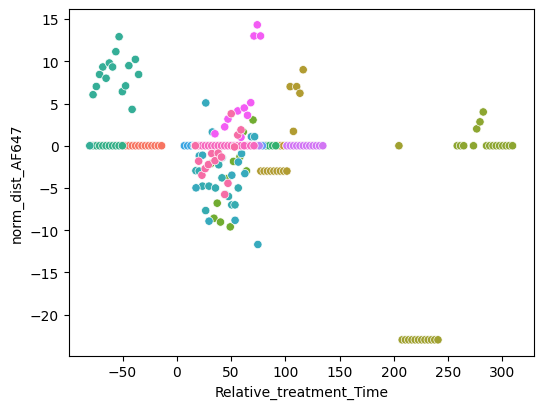

In [156]:
#NPLOTTING THE ORMALIZED distances TO the distance in the first timepoint (BLOOD VESSEL)
##SEPARATING HOXB5+vwf- AND HOXB5-vwf+ CELLS
dx=datac[datac['Hoxb5_status_corrected']=='SP']#DP
dx=dx[dx['Treatment']=='plt_depletion']


fig, ax = plt.subplots(figsize=(6,4.5))
dx=dx[dx['Relative_treatment_Time']!=0]
g=sns.scatterplot(x="Relative_treatment_Time", y="norm_dist_AF647", data=dx, hue="Final_Cell_ID", legend=False)


In [1]:
# pip install git+git://github.com/cytomining/pycytominer@2aa8638d7e505ab510f1d5282098dd59bb2cb470

# import scipy
# from scipy import stats
import pycytominer
# pip install scipy=1.4.1 #had 1.9.1

In [61]:
#Feature selection using pycytominer
#back up #importing the metadata
metadata=pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv')
metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
Pdata = pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/KuOTrackingRemovedObjectsSPDP.csv', header = 0)
# print(Pdata)

#REMOVE THE METADATA COLUMNS AND COLUMNS THAT HAVE STRINGS IN THEIR VALUES
df_temp=Pdata.iloc[:,23:-1]
col_list=df_temp.columns.values.tolist()
# print(col_list)
# print(df_temp)
#problem Hoxb5_status not in metadata
# df_temp['Metadata_Hoxb5_status']=df_temp['Hoxb5_status']
#will need to remove the Hoxb5_status column 
# print(df_temp)

# df_norm = pycytominer.normalize(df_temp, method = 'mad_robustize', mad_robustize_epsilon = 0, samples = "Metadata_Compound == 'DMSO'") 
df_selected = pycytominer.feature_select(df_temp, operation = ['correlation_threshold', 'variance_threshold', 'drop_na_columns', 'blocklist','drop_outliers'], outlier_cutoff = 500, features=col_list)
print('How many columns were dropped?',df_temp.shape[1] - df_selected.shape[1])

# df_temp=pycytominer.annotate(Pdata, metadata, join_on=['Metadata_VWF','Metadata_VWF'])

How many columns were dropped? 65


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_10739/3050780689.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')


In [21]:
#AUTOFLUORESCENT CELLS

#if movies are in lots of different folders
file_list=[]
folderpath='/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output'
for root,dirs, files in os.walk(folderpath):
    for file in files:
        if file.endswith('Watershedautofluo.csv'):
            # file_list.append(os.path.join(root,file))
            data=pd.read_csv(os.path.join(root,file), index_col=None, header=0)
            file_list.append(data)

dataautofluo=pd.concat(file_list, axis =0, ignore_index=True)
dataautofluo['Hoxb5_status']='Autofluo'
print(dataautofluo)

metadata=pd.read_csv('/Users/secchim/Documents/221103merged_metadata_and_mice.csv')
data=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)

metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')
data2=pd.merge(dataautofluo, metadata[:], on = 'Metadata_VWF')

print(data2)


         ImageNumber  ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0                727             1                 NaN                    NaN   
1                727             2                 NaN                    NaN   
2                727             3                 NaN                    NaN   
3                727             4                 NaN                    NaN   
4                727             5                 NaN                    NaN   
...              ...           ...                 ...                    ...   
2003372         1421           233                 NaN                    NaN   
2003373         1421           234                 NaN                    NaN   
2003374         1421           235                 NaN                    NaN   
2003375         1421           236                 NaN                    NaN   
2003376         1421           237                 NaN                    NaN   

         Metadata_Format1  

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/2278716696.py:18: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_68139/2278716696.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata['Metadata_VWF']=(metadata['Position_Name']).str.replace('.czi_','_')


         ImageNumber  ObjectNumber  Metadata_Channelnb  Metadata_FileLocation  \
0                727             1                 NaN                    NaN   
1                727             2                 NaN                    NaN   
2                727             3                 NaN                    NaN   
3                727             4                 NaN                    NaN   
4                727             5                 NaN                    NaN   
...              ...           ...                 ...                    ...   
2003372         1421           233                 NaN                    NaN   
2003373         1421           234                 NaN                    NaN   
2003374         1421           235                 NaN                    NaN   
2003375         1421           236                 NaN                    NaN   
2003376         1421           237                 NaN                    NaN   

         Metadata_Format1  

In [28]:
datacomp=pd.concat((data2, data), axis=0)
#print(datacomp)


KeyboardInterrupt: 

In [29]:
datacomp.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrectautofluo.csv')
#took 7min, 5GB

In [32]:
#subsetting the dataset to be able to open it 

datacomp_subset=data2.sample(2400, replace=False, axis=0)
datacomp=pd.concat((datacomp_subset, data), axis=0)
datacomp.to_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrectautofluo_sub.csv')

In [ ]:
# #calculate distance between timeframes

# data['distance']=0
# grouped=data.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     for b, r in newdf.iterrows(): 
#         # print(b)
#         try:
#             newdf.loc[b, "distance"]=(math.sqrt((newdf["corrected_x_2"][b]-newdf["corrected_x_2"][b+1])**2+(newdf["corrected_y_2"][b]-newdf["corrected_y_2"][b+1])**2+(newdf["corrected_z_2"][b]-newdf["corrected_z_2"][b+1])**2))
        
#             # newdf["distance"]=(math.sqrt((newdf["corrected_x_2"][r]-newdf["corrected_x_2"][r+1])**2+(newdf["corrected_y_2"][r]-newdf["corrected_y_2"][r+1])**2+(newdf["corrected_z_2"][r]-newdf["corrected_z_2"][r+1])**2))
#         except:
#             # print(i, r, "error")
#             pass
#     # print(newdf["distance"])
#     dflist.append(newdf)
# dataX=pd.concat(dflist)
# print(dataX['distance'])

# data["distance"] = math.dist((
#         np.absolute(data["corrected_x_2"]).values,
#         np.absolute(data["corrected_y_2"]).values,
#         np.absolute(data["corrected_z_2"]).values
#         ),(
#         np.absolute(data["corrected_x_2"].shift(1)).values,
#         np.absolute(data["corrected_y_2"].shift(1)).values,
#         np.absolute(data["corrected_z_2"].shift(1)).values
#         ))
# print(data["distance"])

# # print(np.absolute(data["corrected_x_2"]).values)
# # #CONNECT TRACKS BACK UP VERSION

# data['Cell_group']=data['FileID']+'_'+data['Cell_name']
# data['Final_Cell_ID']=data['Metadata_VWF']

# grouped=data.groupby(['Cell_group'])
# stored_X=0
# stored_Y=0
# list_of_index=[]
# dflist=[]
# for i, newdf in grouped:
#     # print(i)
#     # newdf=newdf.sort_values(by=[‘AcquisitionTime’, ‘Metadata_Timepoint’])
#     min, max = newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmin(), newdf.groupby('AcquisitionTime')['Metadata_Timepoint'].idxmax()
#     t = []
#     for mi, ma in zip(min, max):
#         t += [mi, ma]
#     t
#     for i in range(1, len(t)-1, 2):
#         # print(t[i], t[i+1])
#         stored_X=data['corrected_x'][t[i]]
#         stored_X1=data['corrected_x'][t[i+1]]
#         stored_Y=data['corrected_x'][t[i]]
#         stored_Y1=data['corrected_x'][t[i+1]]
#         # print(t[i], stored_X, t[i+1], stored_X1)
#         if (abs(stored_X1-stored_X))<=20 and (abs(stored_Y1-stored_Y))<=20:
#             newdf['Final_Cell_ID']=newdf['Cell_group']+'_'+(str(stored_X))[:5]
#             # print(newdf[‘Final_Cell_ID’])
#     dflist.append(newdf)
# data=pd.concat(dflist)
# print(data['Final_Cell_ID'])


# #NORMALIZING POSITIONS TO THE FIRST COORDINATES
# #do on the unique Cell_ID rather than Track_ID
# #PROBLEM OF I DONT HAVE THE Z FOR THE STAGE POSITION
# data['corrected_x_2']=data['Location_Center_X']
# data['corrected_y_2']=data['Location_Center_Y']
# data['corrected_z_2']=data['Location_Center_Z']
# data['norm_x']=0
# grouped=data.groupby(['Track_ID'])

# dflist=[]
# print(grouped)
# for i, newdf in grouped:
#     newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]#or '0'?
#     norm_x=newdf2['Location_Center_X'].values
#     norm_y=newdf2['Location_Center_Y'].values
#     norm_z=newdf2['Location_Center_Z'].values

#     newdf['norm_x']=[norm_x[0]]*len(newdf)#you could create pd.Series
#     # print(newdf['norm_x'])
#     newdf['corrected_x_2']=((newdf['Location_Center_X']-newdf['norm_x'])*(newdf['Scale_X'])*1000000)
#     # print(newdf['corrected_x_2'])
#     newdf['norm_y']=[norm_y[0]]*len(newdf)#you could create pd.Series
#     newdf['corrected_y_2']=((newdf['Location_Center_Y']-newdf['norm_y'])*(newdf['Scale_Y'])*1000000)
#     newdf['norm_z']=[norm_z[0]]*len(newdf)#you could create pd.Series
#     newdf['corrected_z_2']=((newdf['Location_Center_Z']-newdf['norm_z'])*(newdf['Scale_Z'])*1000000)
#     dflist.append(newdf)
# data=pd.concat(dflist)
# print(data)

# grouped=data.groupby(['Track_ID'])

# for i, newdf in grouped:
#     newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]#or '0'?
#     norm_x=newdf2['Location_Center_X'].values
#     newdf['corrected_x_2']=((newdf['Location_Center_X']-newdf['norm_x'])*(newdf['Scale_X'])*1000000)
#     newdf2=newdf[newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
#     val=newdf2['corrected_x_2'].values
#     print(i, val)

In [9]:
count_DP=0

#DP/SP Hoxb5_status
Hoxb5_cells=[]
Hoxb5Vwf_cells=[]


#CONSIDERS CELLS TO BE DP IF LABELLED AS DP IN 3 FRAMES MINIMUM
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
grouped=data.groupby(['Final_Cell_ID'])
# print(grouped)
for i, newdf in grouped:
    newdf=newdf[newdf['Hoxb5_status'] == 'DP']
    # newdf=newdf[newdf['MK_distance']>2] #ADD THIS NEW LINE!!!!!!
    count_DP=newdf.shape[0]
    # print(count_DP)
    # if count_DP > (len(newdf.index))/2:
    if count_DP > 3:
        Hoxb5Vwf_cells.append(i) #137
# # print(Hoxb5Vwf_cells)

Hoxb5Vwf_list=np.unique(Hoxb5Vwf_cells)
print(Hoxb5Vwf_list)
dflist=[]
grouped=data.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if i in Hoxb5Vwf_list:
        newdf['Hoxb5_status_corrected']='DP'
    else:
        newdf['Hoxb5_status_corrected']='SP'
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['Hoxb5_status_corrected'],data['Hoxb5_status'])
# data.to_csv('/Users/secchim/Downloads/CellProfiler/movie_pipeline_test/data_wrongtrack.csv')


['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05'
 'VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05'
 'VWF_048_MS220118_M3_movie2homeostasis_P6DP+_1.5259021893143654e-05'
 'VWF_048_MS220118_M3_movie4plt_P12+_6.103608757257462e-05'
 'VWF_048_MS220118_M3_movie4plt_P22+_6.103608757257462e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_4.577706567943096e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_7.629510946571827e-05'
 'VWF_049_MS220201_M1_Snap_movie5depletion_P12DP_1.5259021893143654e-05'
 'VWF_062_MS220421_M2_movie_P4_1.5259021893143654e-05'
 'VWF_062_MS220421_M2_movie_P6_1.5259021893143654e-05']
0      SP
1      SP
2      SP
3      SP
4      SP
       ..
613    SP
614    SP
615    SP
616    SP
617    SP
Name: Hoxb5_status_corrected, Length: 618, dtype: object 0      SP
1      SP
2      SP
3      SP
4      SP
       ..
613    SP
614    SP
615    SP
616    SP
617    SP
Name: Hoxb5_status, Length: 618, dtype: object


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_17116/1789773475.py:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_17116/1789773475.py:26: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


In [ ]:
# %history
#saved my life when I deleted a bunch of code

VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_1.5259021893143654e-05 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_3.051804378628731e-05 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_4.577706567943096e-05 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_6.103608757257462e-05 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_7.629510946571827e-05 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.000106813153252 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.0001220721751451 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.0001373311970382 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.0001525902189314 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.0001678492408245 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P12_0.0001831082627177 PBM
VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasc

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_58829/2708186289.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: 

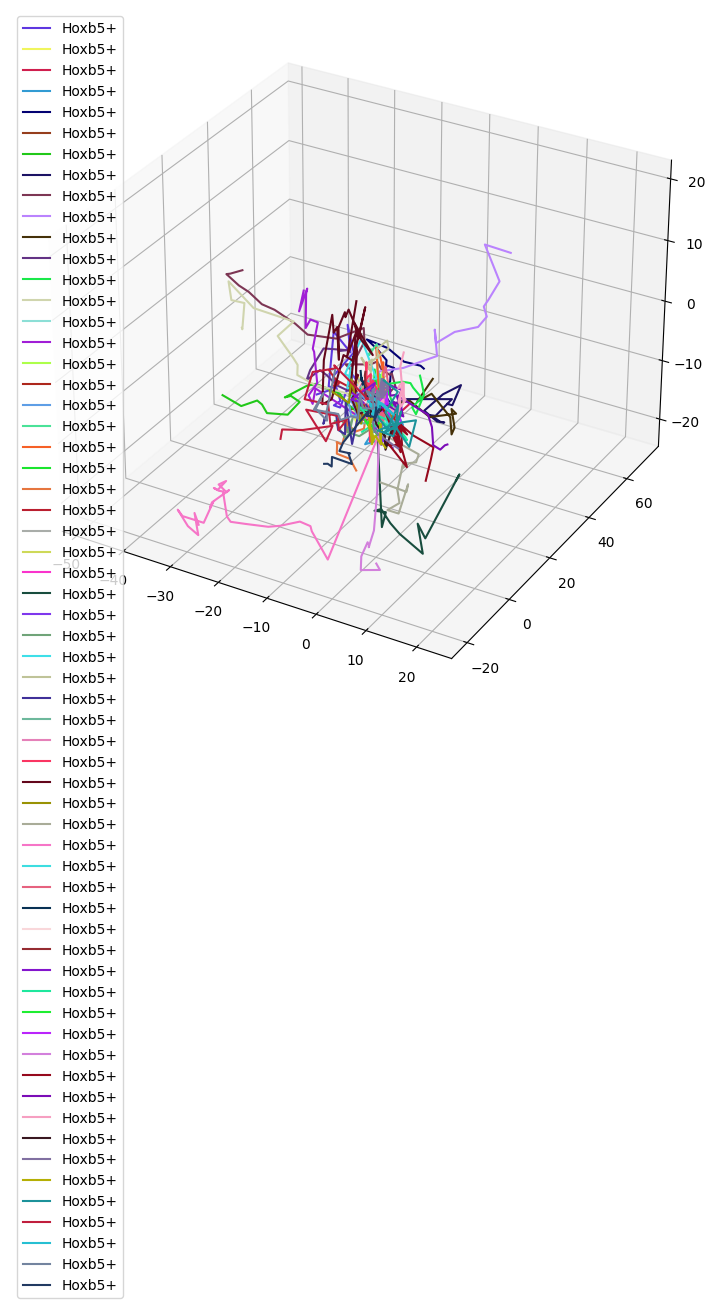

In [297]:
### homeostasis plot, NOT separating Hoxb5+ and Hoxb5+Vwf+

#removing TRACKS THAT ARE TOO SHORT
#print(my_list_hoxb5vwf)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=10:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


# print(len(remove_list), remove_list)

# print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5 = np.unique(data['Track_ID'])
print(len(my_list_hoxb5))

#Plotting the tracks 

for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list :
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+', c=(r,g,b))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        # ax.set_xlim(-65, 85)
        # ax.set_ylim(-125, 25)
        # ax.set_zlim(-4, 4)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


In [ ]:
#grouped=merged_df.groupby(['Metadata_VWF'])
# for i in grouped:
#     my_list_hoxb5 = np.unique(data['Intensity_MaxIntensity_track'])
# print(data['AcquisitionTime'], data['Time of treatment'])
# print(newdf[newdf['Treatment']=='plt_depletion']['Time of treatment'].values[0])

# #REMOVING DUPLICATES from the merge 
# grouped=data.groupby(['Position_Name'])
# grouped #list of dataframes

# dflist=[]

# for i, newdf in grouped: #new df is grouped data franes
#    # print(i,df)
#     if newdf.shape[0]>1:
#         print(newdf.shape)

#         #if row has plt_depletion take time of treatment add acquisition time add to all rows in the group 
#         trmttime=newdf[newdf['Treatment']=='plt_depletion']['Time of treatment'].values[0]#numpy array, get the first value
#         #if trmttime > newdf['AcquisitionTime']:
#         newdf['TrueTreatment']=np.where(newdf['AcquisitionTime']<trmttime, 'Thomeostasis', 'Tdepletion')
#     else: 
#         newdf['TrueTreatment']="none"
#     dflist.append(newdf)
# xdf=pd.concat(dflist)

# xdf[~((xdf['Treatment'].str.contains("plt_depletion")) & (xdf['TrueTreatment'].str.contains("Thomeostasis")))]
# xdf[~((xdf['Treatment'].str.contains("homeostasis")) & (xdf['TrueTreatment'].str.contains("Tdepletion")))]

# print('data drop duplicates', len(xdf))
# data=xdf

In [112]:
#copied to make it easier
data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)

count_DP=0

#DP/SP Hoxb5_status
Hoxb5_cells=[]
Hoxb5Vwf_cells=[]

# print(len(data))
#CONSIDERS CELLS TO BE DP IF LABELLED AS DP IN 3 FRAMES MINIMUM
#SHOULD PROBABLY BE DONE ON THE FINAL CELL_ID RATHER THAN TRACK ID
grouped=data.groupby(['Final_Cell_ID'])
# print(grouped)
for i, newdf in grouped:
    newdf=newdf[newdf['Hoxb5_status'] == 'DP']
    # newdf=newdf[newdf['MK_distance']>2] #ADD THIS NEW LINE!!!!!!
    count_DP=newdf.shape[0]
    # print(count_DP)
    # if count_DP > (len(newdf.index))/2:
    if count_DP > 2:
        Hoxb5Vwf_cells.append(i) #137
# # print(Hoxb5Vwf_cells)
    # dflist.append(newdf)
# datax=pd.concat(dflist)

Hoxb5Vwf_list=np.unique(Hoxb5Vwf_cells)
print(Hoxb5Vwf_list)


datax=data
datax['Hoxb5_status_corrected']='SP'
for i in datax.index:
    if datax.loc[i,'Final_Cell_ID'] in Hoxb5Vwf_list:
        datax.loc[i,'Hoxb5_status_corrected']='DP'

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/2269674295.py:2: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/2269674295.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


['VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_1.5259021893143654e-05'
 'VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05'
 'VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05'
 'VWF_048_MS220118_M3_movie4plt_P22+_4.577706567943096e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_6.103608757257462e-05'
 'VWF_048_MS220119_M1_homeostasis_movie_3_P16DP_1.5259021893143654e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P10spot_4.577706567943096e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_6.103608757257462e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_7.629510946571827e-05'
 'VWF_053_MS220209_M1_movie8depletion_P26kuovascu_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE1_P11DP_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE1_P8_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE3_P11DP_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE3_P1DP_3.051804378628731e-05'
 'VWF_060_MS220408_M1_MOVIE5_P16_1.5259021893143654e-05'
 

['VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_1.5259021893143654e-05'
 'VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P32+_1.5259021893143654e-05'
 'VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05'
 'VWF_048_MS220118_M3_movie4plt_P22+_4.577706567943096e-05'
 'VWF_048_MS220118_M3_movie4plt_P6DP+_6.103608757257462e-05'
 'VWF_048_MS220119_M1_homeostasis_movie_3_P16DP_1.5259021893143654e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P10spot_4.577706567943096e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_6.103608757257462e-05'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_P12DP_7.629510946571827e-05'
 'VWF_053_MS220209_M1_movie8depletion_P26kuovascu_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE1_P11DP_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE1_P8_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE3_P11DP_1.5259021893143654e-05'
 'VWF_060_MS220408_M1_MOVIE3_P1DP_3.051804378628731e-05'
 'VWF_060_MS220408_M1_MOVIE5_P16_1.5259021893143654e-05'
 

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/1783454370.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


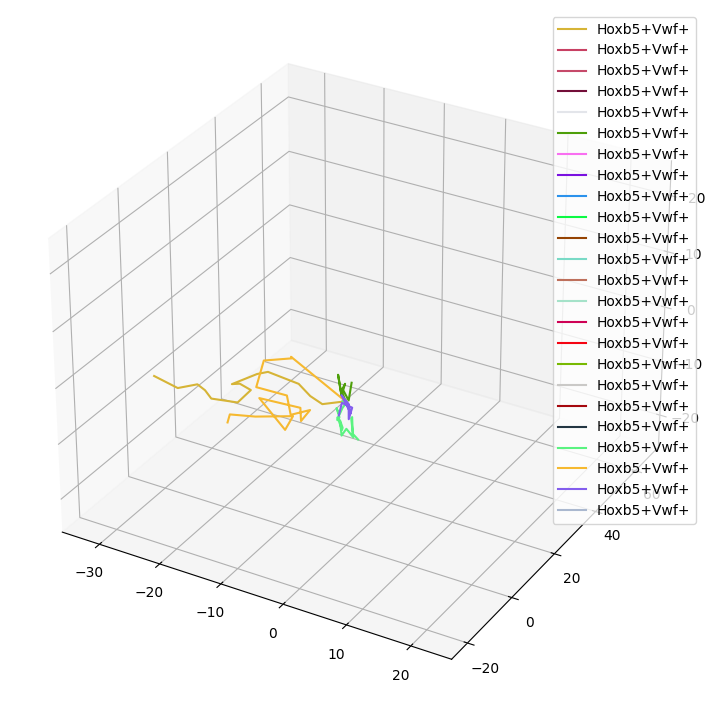

In [115]:
### homeostasis plot, separating Hoxb5+Vwf+

data=datax[datax['Treatment']=='homeostasis']
#removing TRACKS THAT ARE TOO SHORT
print(Hoxb5Vwf_list)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=8:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


# print(len(remove_list))

# remove_list.append(['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05'])


print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#Plotting the tracks 

for a in Hoxb5Vwf_list:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list:# and a not in my_list_hoxb5:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf+', c=(r,g,b))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper right')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P12+_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_6.103608757257462e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_7.629510946571827e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_9.155413135886192e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie1_P7++_1.5259021893143654e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie1_P7++_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie3_P17+

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/2472789030.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


New size: [12, 9]
New size: [12, 9]


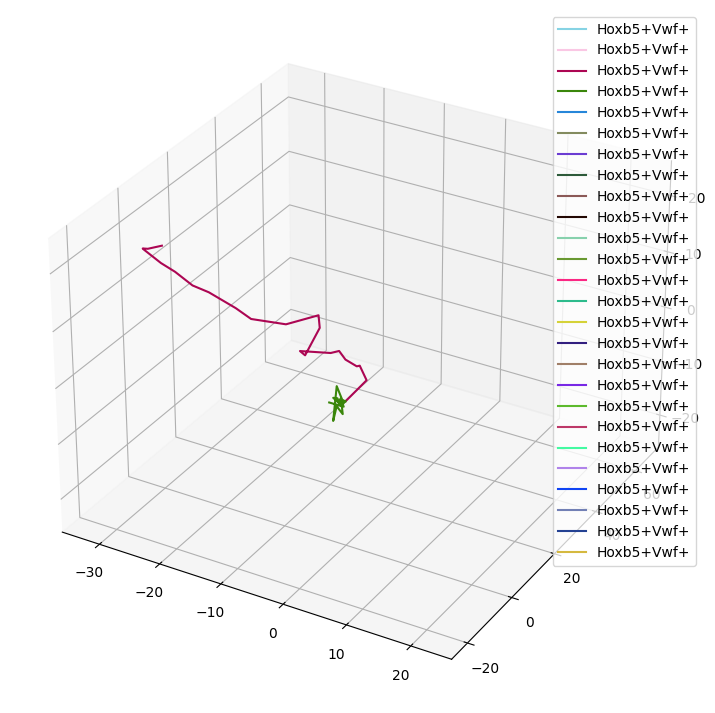

In [113]:
###post depletion plot Hoxb5+ Vwf+ 
data=datax[datax['Treatment']=='plt_depletion']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=8:
        print(i,'PBM')
        remove_list.append(i) #137
    # elif newdf['Intensity_MaxIntensity_track'][i].astype(str).str.endswith('0.0'): #didn't work
    #     remove_list.append(i)
    else:
        print(i, 'no problem')

#    ax.set_xlim(-30, 30)
#    ax.set_ylim(-20, 50)
#    ax.set_zlim(-20, 30)
# my_list_dep_hoxb5vwf = ['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05']

for a in Hoxb5Vwf_list:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
    if a not in remove_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf+', c=(r,g,b))

        #    ax.set_xlim(-15, 20)
        #    ax.set_ylim(-20, 30)
        #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper right')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)



VWF_060_MS220408_M1_MOVIE1_P11DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P1DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P1DP_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P8_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE2_P4GREENVESSEL_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE2_P4GREENVESSEL_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_4.577706567943096e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_6.103608757257462e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P11DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P1DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P1DP_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P4GREENVESSEL_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P8_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE4_P16_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE4_P16_3.051804378

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/4266252660.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


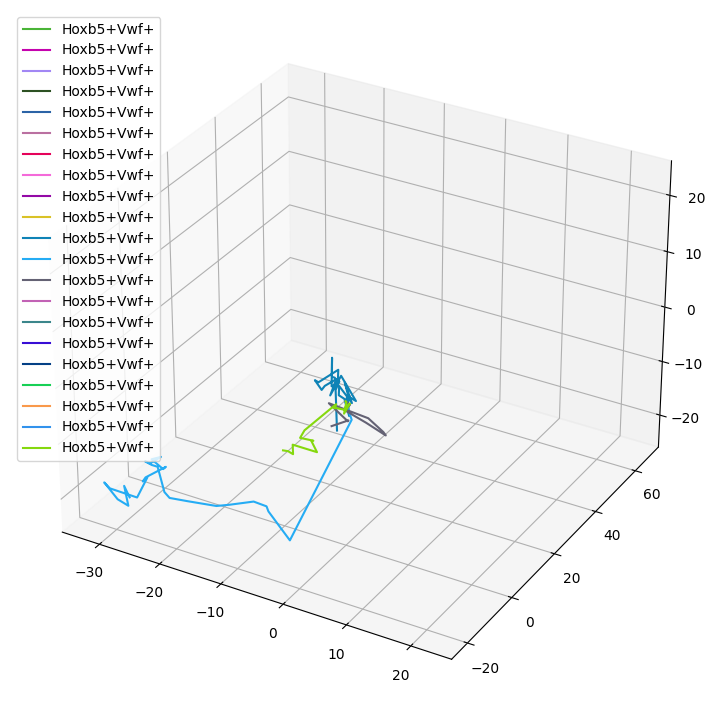

In [114]:
###24H post depletion plot Hoxb5+ Vwf+ 
data=datax[datax['Treatment']=='24h_depletion']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=10:
        print(i,'PBM')
        remove_list.append(i) #137
    # elif newdf['Intensity_MaxIntensity_track'][i].astype(str).str.endswith('0.0'): #didn't work
    #     remove_list.append(i)
    else:
        print(i, 'no problem')

#    ax.set_xlim(-30, 30)
#    ax.set_ylim(-20, 50)
#    ax.set_zlim(-20, 30)
# my_list_dep_hoxb5vwf = ['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05']

for a in Hoxb5Vwf_list:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
    if a not in remove_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf+', c=(r,g,b))

        #    ax.set_xlim(-15, 20)
        #    ax.set_ylim(-20, 30)
        #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)



VWF_043_MS211125_m3-homeostasis_movie2_M1_1.5259021893143654e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie2_M1_3.051804378628731e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie2_M1_4.577706567943096e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie2_M1_6.103608757257462e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie2_M1_7.629510946571827e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie2_P4_1.5259021893143654e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_1.5259021893143654e-05 no problem
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_3.051804378628731e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_1.5259021893143654e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_3.051804378628731e-05 no problem
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_4.577706567943096e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_6.103608757257462e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_7.629510946571827e-05 PBM
VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/4293852103.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


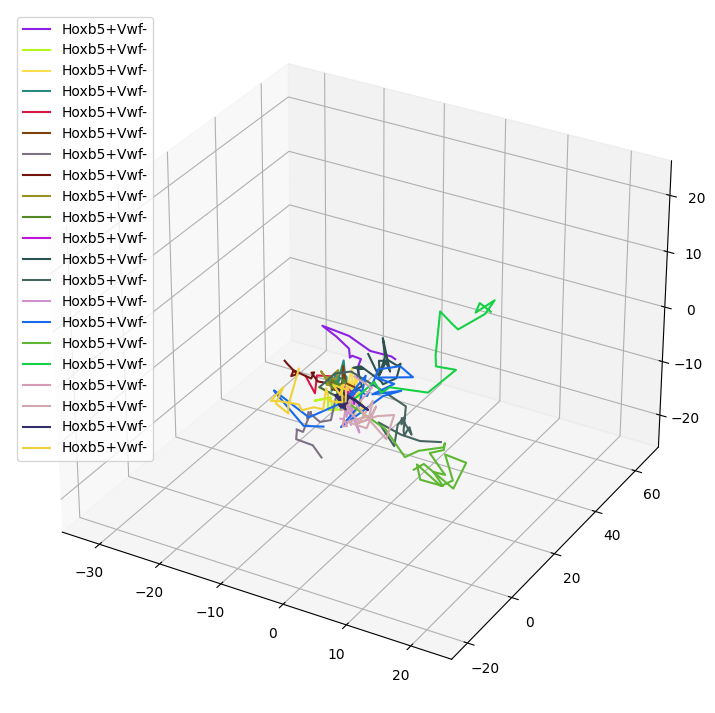

In [117]:
### homeostasis plot, separating Hoxb5+Vwf-

data=datax[datax['Treatment']=='homeostasis']
#removing TRACKS THAT ARE TOO SHORT
#print(my_list_hoxb5vwf)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=8:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


# print(len(remove_list))

# remove_list.append(['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05'])


print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5 = np.unique(data['Track_ID'])
print(len(my_list_hoxb5))

#Plotting the tracks 

for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list and a not in Hoxb5Vwf_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P12+_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_6.103608757257462e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_7.629510946571827e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_9.155413135886192e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie1_P7++_1.5259021893143654e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie1_P7++_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie2_P7++_3.051804378628731e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie3_P17+_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-pltdepletionmovie3_P17+

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/2647898066.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


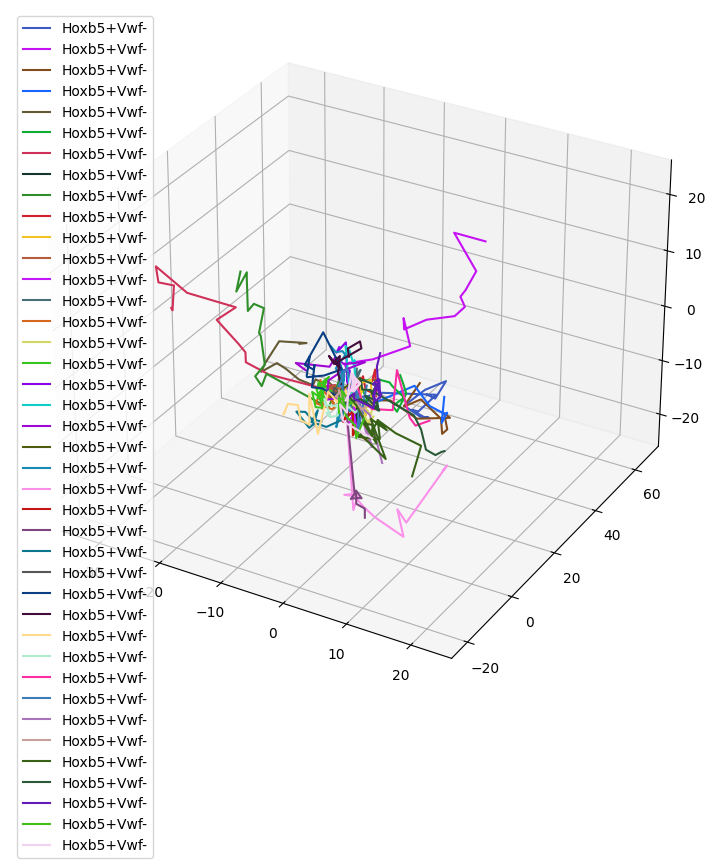

In [119]:
## after depletion plot, separating Hoxb5+Vwf-

data=datax[datax['Treatment']=='plt_depletion']
#removing TRACKS THAT ARE TOO SHORT
#print(my_list_hoxb5vwf)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=8:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


# print(len(remove_list))

# remove_list.append(['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05'])


print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5 = np.unique(data['Track_ID'])
print(len(my_list_hoxb5))

#Plotting the tracks 

for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list and a not in Hoxb5Vwf_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


VWF_060_MS220408_M1_MOVIE1_P11DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P1DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P1DP_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE1_P8_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE2_P4GREENVESSEL_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE2_P4GREENVESSEL_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_4.577706567943096e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P10_6.103608757257462e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P11DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P1DP_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P1DP_3.051804378628731e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P4GREENVESSEL_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE3_P8_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE4_P16_1.5259021893143654e-05 PBM
VWF_060_MS220408_M1_MOVIE4_P16_3.051804378

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_7120/1535078470.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


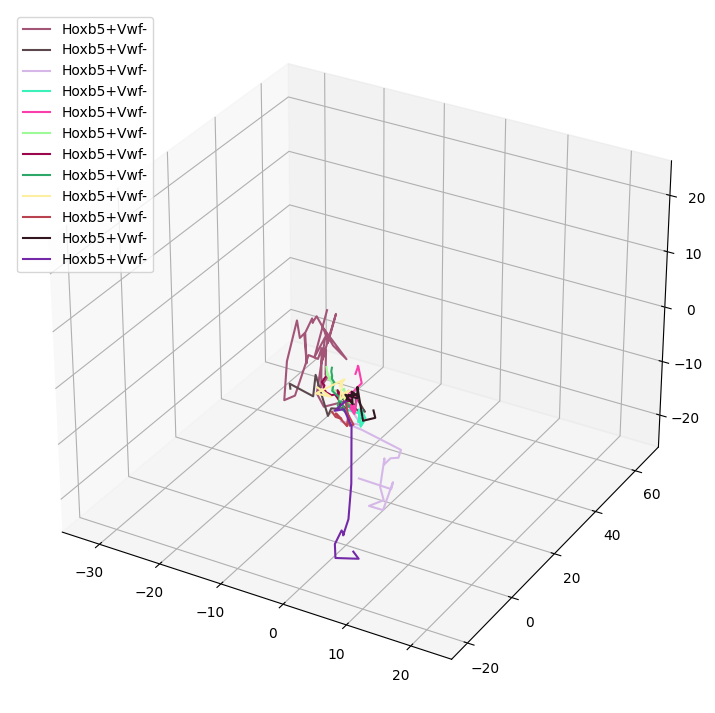

In [120]:
## 24H after depletion plot, separating Hoxb5+Vwf-

data=datax[datax['Treatment']=='24h_depletion']
#removing TRACKS THAT ARE TOO SHORT
#print(my_list_hoxb5vwf)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=10:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


# print(len(remove_list))

# remove_list.append(['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05'])


print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5 = np.unique(data['Track_ID'])
print(len(my_list_hoxb5))

#Plotting the tracks 

for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list and a not in Hoxb5Vwf_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        ax.set_xlim(-35, 25)
        ax.set_ylim(-25, 70)
        ax.set_zlim(-25, 25)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


1
New size: [12, 9]


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/3553459217.py:6: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)


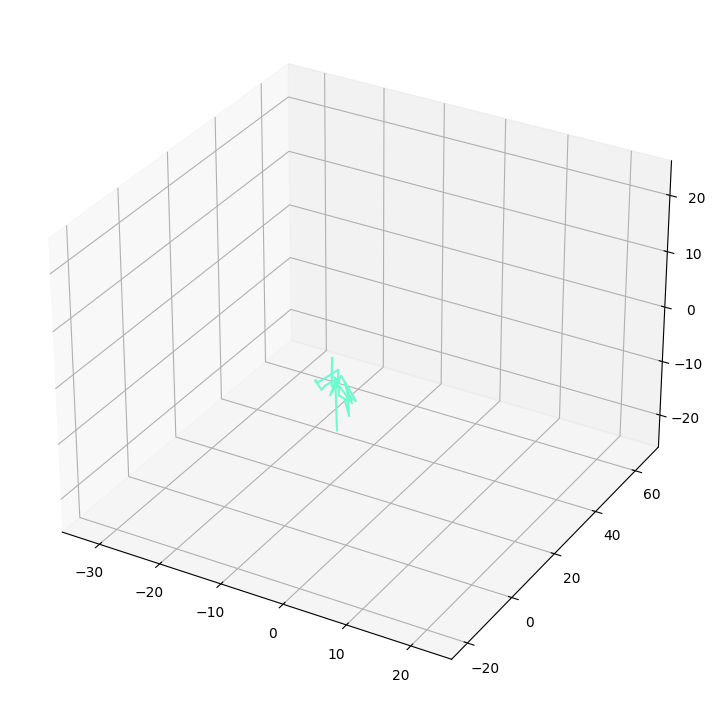

In [22]:
#SINGLE TRACK 

data= pd.read_csv("/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv", header = 0)
data.dropna()
count_DP=0


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#Write which movie you want to plot

# data=data[data['max_displacement']>19]

#Hoxb5 with 35um max displacement
# my_list_hoxb5 = ['VWF_053_MS220209_M1_movie2homeostasis_P26kuovascu_1.5259021893143654e-05']
#Hoxb5 with 19um max displacement
# my_list_hoxb5 = ['VWF_053_MS220209_M1_movie2homeostasis_P24kuomk_1.5259021893143654e-05']
#not moving Hoxb5 max displacement of 11
# my_list_hoxb5 = ['VWF_053_MS220209_M1_movie2homeostasis_P18kuo_1.5259021893143654e-05']

# ['VWF_053_MS220209_M1_movie2homeostasis_P14partlygreen_1.5259021893143654e-05',
# 'VWF_053_MS220209_M1_movie2homeostasis_P14partlygreen_3.051804378628731e-05', 
#     'VWF_053_MS220209_M1_movie2homeostasis_P16DP_1.5259021893143654e-05',
#     'VWF_053_MS220209_M1_movie2homeostasis_P24kuomk_1.5259021893143654e-05',
#  'VWF_053_MS220209_M1_movie2homeostasis_P26kuovascu_1.5259021893143654e-05']


#immotile Hoxb5Vwf
# my_list_hoxb5 = ['VWF_048_MS220118_M3_movie2homeostasis_P6DP+_1.5259021893143654e-05']

#hoxb5 cell in depletion
# my_list_hoxb5 = ['VWF_066_MS220519_M2_movie2_P12_2k_mk_1.5259021893143654e-05']#21 timepoints but could be moving somewhere
# my_list_hoxb5 = ['VWF_066_MS220522_M1_movie2_P7k_1.5259021893143654e-05']
#hoxb5vwf cell in depletion
# my_list_hoxb5 = ['VWF_048_MS220118_M3_movie4plt_P6DP+_1.5259021893143654e-05']
#24h depletion
# VWF_060_MS220408_M1_MOVIE5_P16_1.5259021893143654e-05
# my_list_hoxb5 = ['VWF_060_MS220408_M1_MOVIE5_P4_2_4.577706567943096e-05']#moves a lot
my_list_hoxb5 = ['VWF_060_MS220408_M1_MOVIE5_P16_3.051804378628731e-05']
my_list_hoxb5 = ['VWF_060_MS220408_M1_MOVIE5_P16_1.5259021893143654e-05']



print(len(my_list_hoxb5))

#Plotting the tracks 


for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
    # print(data1['max_displacement'].max)
    # if len(data1['Metadata_Timepoint'])>20:
    X1= data1['corrected_x_2']
    Y1= data1['corrected_y_2']
    Z1= data1['corrected_z_2']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
    
#    ax.set_xlim(-15, 20)
#    ax.set_ylim(-20, 30)
#    ax.set_zlim(-20, 10)    
    ax.set_xlim(-35, 25)
    ax.set_ylim(-25, 70)
    ax.set_zlim(-25, 25)
    # ax.legend(loc='upper left')

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)


VWF_043_MS211126_m4-homeostasismovie_2_P12+_1.5259021893143654e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P12+_3.051804378628731e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P1<3_1.5259021893143654e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_1.5259021893143654e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.051804378628731e-05 no problem
VWF_043_MS211126_m4-homeostasismovie_2_P7++_4.577706567943096e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_6.103608757257462e-05 PBM
VWF_043_MS211126_m4-homeostasismovie_2_P7++_7.629510946571827e-05 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_0.000106813153252 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_1.5259021893143654e-05 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_3.051804378628731e-05 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_4.577706567943096e-05 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_6.103608757257462e-05 PBM
VWF_048_MS220118_M3_movie2homeostasis_P12+_7.629510946571827e-05 PBM
VWF_048_MS22

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_3364/4293078266.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


New size: [12, 9]


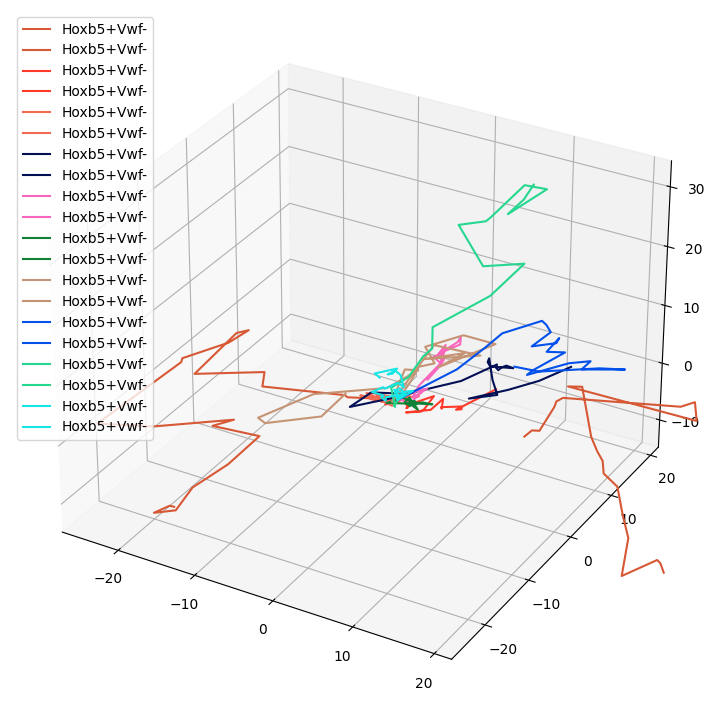

In [220]:
##COLOR BY 
#
from matplotlib import cm

# removing TRACKS THAT ARE TOO SHORT
#print(my_list_hoxb5vwf)
remove_list =[]
grouped=data.groupby(['Track_ID'])
print(grouped)
for i, newdf in grouped:
    if len(newdf.index) <=19:
        print(i,'PBM')
        remove_list.append(i) #137
    else:
        print(i, 'no problem')


print(len(remove_list))

# remove_list.append(['VWF_043_MS211126_m4-homeostasismovie_2_P7++_3.05e-05', 'VWF_049_MS220201_M1_Snap_movie5depletion_P10spot_1.53e-05'])


print(len(data))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5 = np.unique(data['Track_ID'])
print(len(my_list_hoxb5))

#Plotting the tracks 

for a in my_list_hoxb5:
    data1= data[(data['Track_ID'] == a)].sort_values(by=['Metadata_Timepoint'])#Make sure not a string 
#    if len(data1['Metadata_Timepoint'])>2
    if a not in remove_list and a not in Hoxb5Vwf_list:
        X1= data1['corrected_x_2']
        Y1= data1['corrected_y_2']
        Z1= data1['corrected_z_2']
        depX=np.ma.masked_where(data1['corrected_x_2']>2, data1['corrected_x_2'])
        homX=np.ma.masked_where(data1['corrected_x_2']<2, data1['corrected_x_2'])
        XX=np.ma.masked_where(data1['corrected_x_2']==2, data1['corrected_x_2'])
        r= random.random()
        b= random.random()
        g= random.random()
        ax.plot(homX, depX, Y1, Z1, label='Hoxb5+Vwf-', c=(r,b,g))
        
    #    ax.set_xlim(-15, 20)
    #    ax.set_ylim(-20, 30)
    #    ax.set_zlim(-20, 10)    
        # ax.set_xlim(-65, 85)
        # ax.set_ylim(-125, 25)
        # ax.set_zlim(-4, 4)
        ax.legend(loc='upper left')

        # Set figure width to 12 and height to 9
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 12
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        print ("New size:", fig_size)


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


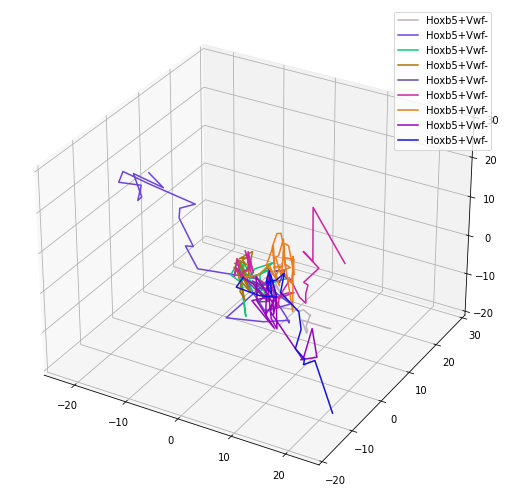

In [6]:
###post depletion plot Hoxb5+Vwf-

fig = plt.figure()
ax = fig.gca(projection='3d')

my_list_dep_hoxb5 = [14.2, 11.2, 9.3, 12.1,14.3, 17.1, 17.3, 17.4, 17.5]

for a in my_list_dep_hoxb5:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
    ax.set_xlim(-25, 25)
    ax.set_ylim(-20, 30)
    ax.set_zlim(-20, 30)   
    ax.legend()    
    
    ax.legend()

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)

 


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


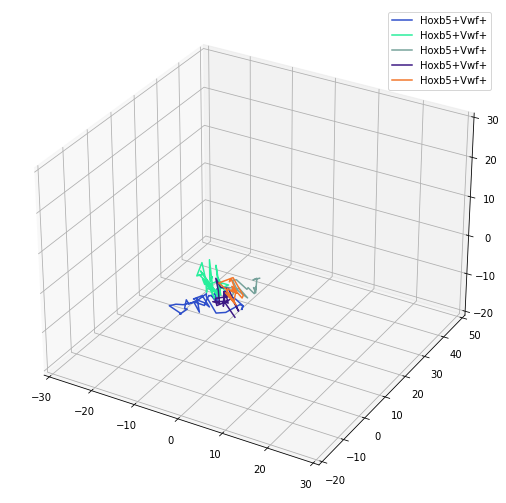

In [5]:
###24h post depletion plot Hoxb5+ Vwf+ 

fig = plt.figure()
ax = fig.gca(projection='3d')
#2.1, 6.1, 1.22, 14.1
my_list_dep_hoxb5vwf = [13.1, 13.2, 18.1, 18.2, 18.3]

for a in my_list_dep_hoxb5vwf:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf+', c=(r,g,b))
    
    ax.set_xlim(-30, 30)
    ax.set_ylim(-20, 50)
    ax.set_zlim(-20, 30)    
    ax.legend()

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)



New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


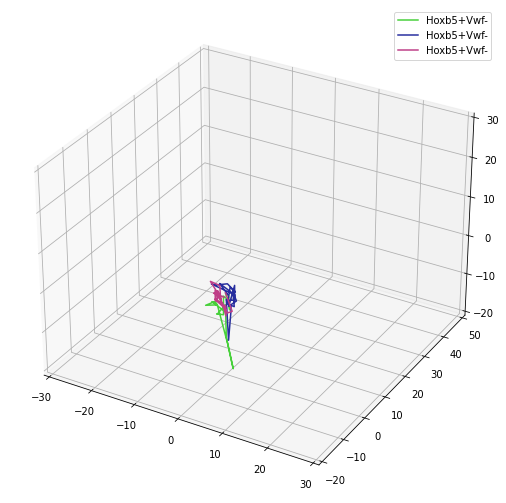

In [14]:
###24h post depletion plot Hoxb5+Vwf-

fig = plt.figure()
ax = fig.gca(projection='3d')

my_list_dep_hoxb5 = [16.1, 18.4, 19.1]

for a in my_list_dep_hoxb5:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
    ax.set_xlim(-30, 30)
    ax.set_ylim(-20, 50)
    ax.set_zlim(-20, 30)   
    ax.legend()    
    
    ax.legend()

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)



New size: [12, 9]


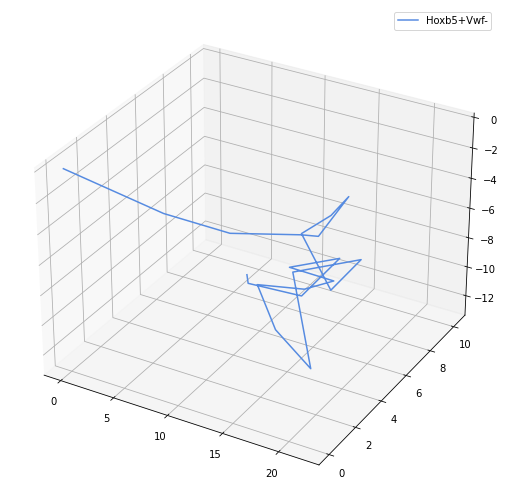

In [17]:

track_length=0
print(track_length)

my_list_dep_hoxb5vwf = [2.1, 6.1]
range_of_i = range(2,23)

for a in my_list_dep_hoxb5vwf:
    data1= data[(data['cell_ID'] == a)]
    i= data1.frame
    for i in range_of_i:
        data1.tracklength=track_length
        track_length=track_length+mt.sqrt(((data1.x[i]-data1.x[i-1])**2)+((data1.y[i]-data1.y[i-1])**2)+((data1.z[i]-data1.z[i-1])**2))
        #track_length_df=pd.DataFrame(track_length)
        #print(track_length)


print(data.tracklength)   
#data.tracklength.to_csv('track.tsv','\t')



In [43]:
#i=data.frame
#print(i)

#print(data['cell_ID'] == 11.2)

data = pd.read_csv('/Volumes/LUIS1_MS/Experiments/IVM_tracks.csv', header = 0)
print(data)

            x  relative_x        y  relative_y         z  relative_z  frame  \
0    1068.220       0.000  327.353       0.000  27.77760      0.0000      1   
1    1067.730      -0.490  327.636       0.283  27.78840      0.0108      2   
2    1069.680       1.460  328.081       0.728  28.46300      0.6854      3   
3    1069.680       1.460  329.026       1.673  28.41970      0.6421      4   
4    1067.730      -0.490  329.433       2.080  27.18380     -0.5938      5   
..        ...         ...      ...         ...       ...         ...    ...   
417   881.113     -41.987  147.775      29.832  11.22700      0.0000     18   
418   875.323     -47.777  152.921      34.978   8.55963      0.0000     19   
419   874.770     -48.330  155.125      37.182   6.79874      0.0000     20   
420   876.980     -46.120  154.776      36.833   5.98209      0.0000     21   
421   876.980     -46.120  158.930      40.987   7.76605      0.0000     22   

                                                  f

In [ ]:
### Single Hoxb5+  track for Tiago

fig = plt.figure()
ax = fig.gca(projection='3d')

my_list_hoxb5 = [3.4]

for a in my_list_hoxb5:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
    ax.set_xlim(-20, 20)
    ax.set_ylim(-2, 13)
    ax.set_zlim(-12, 2)
    
    ax.legend()

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)

New size: [12, 9]


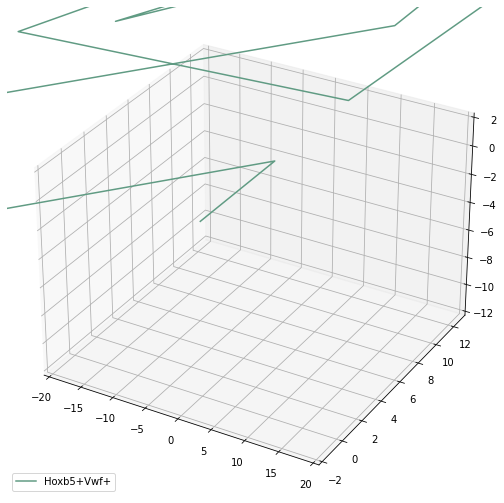

In [39]:
### single Hoxb5+Vwf+ track for Tiago #3.3

fig = plt.figure()
ax = fig.gca(projection='3d')


my_list_hoxb5vwf = [10.1]

for a in my_list_hoxb5vwf:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf+', c=(r,g,b))
    ax.set_xlim(-20, 20)
    ax.set_ylim(-2, 13)
    ax.set_zlim(-12, 2)
    
    ax.legend()

    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)


New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


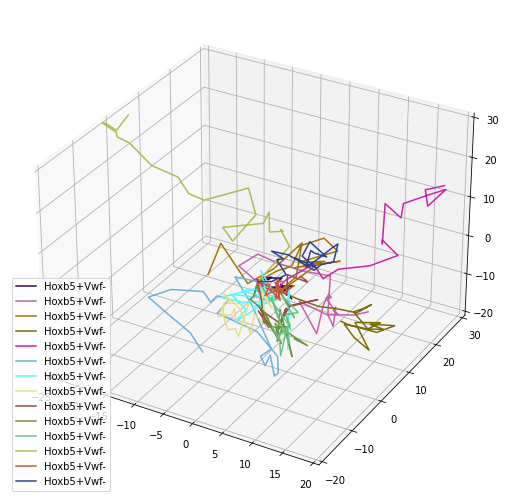

In [9]:
### homeostasis plot, separating Hoxb5+ and Hoxb5+Vwf+ CHANGING THE AXIS

fig = plt.figure()
ax = fig.gca(projection='3d')

my_list_hoxb5 = [1.1, 3.1, 3.2, 3.4, 3.5, 3.6, 7.1, 8.1, 8.2, 9.1, 9.2, 10.1, 1.4, 3.11]

for a in my_list_hoxb5:
    data1= data[(data['cell_ID'] == a)]
    X1= data1['relative_x']
    Y1= data1['relative_y']
    Z1= data1['relative_z']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, label='Hoxb5+Vwf-', c=(r,g,b))
    
    ax.set_xlim(-25, 20)
    ax.set_ylim(-20, 30)
    ax.set_zlim(-20, 30)
    ax.legend()
    
    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    print ("New size:", fig_size)



New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]
New size: [12, 9]


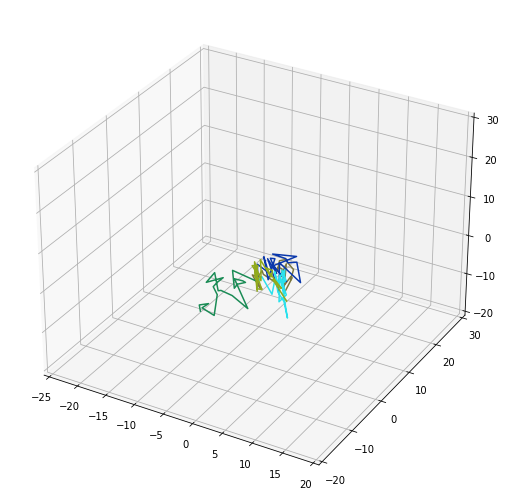

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/1174994935.py:6: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  CP=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/1174994935.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/1174994935.py:28: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whm

['VWF_043_MS211125_M3' 'VWF_043_MS211126_M4' 'VWF_045_MS211208_M2'
 'VWF_048_MS220118_M3' 'VWF_048_MS220119_M1' 'VWF_048_MS220120_M2'
 'VWF_049_MS220201_M1' 'VWF_053_MS220209_M1' 'VWF_060_MS220408_M1'
 'VWF_060_MS220408_M2' 'VWF_062_MS220420_M3' 'VWF_062_MS220421_M5'
 'VWF_063_MS220428_M1' 'VWF_063_MS220428_M2' 'VWF_066_MS220519_M2'
 'VWF_066_MS220522_M1' 'VWF_066_MS220522_M4']
                  FileID  track_count_manual  track_count_CP ratio_track
0    VWF_048_MS220118_M3                   3               7    2.333333
1    VWF_048_MS220118_M3                   3               7    2.333333
2    VWF_048_MS220118_M3                   3               7    2.333333
3    VWF_048_MS220118_M3                   3               7    2.333333
4    VWF_048_MS220118_M3                   3               7    2.333333
..                   ...                 ...             ...         ...
215  VWF_062_MS220420_M3                   5               5         1.0
216  VWF_062_MS220420_M3           

<AxesSubplot: xlabel='FileID', ylabel='ratio_track'>

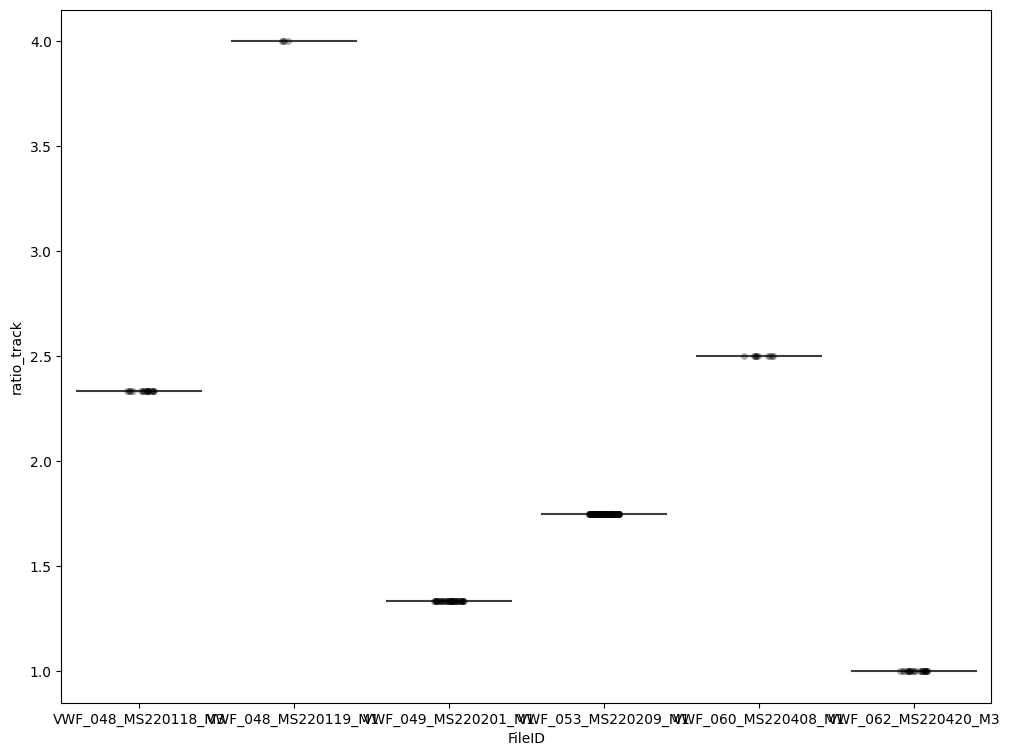

In [77]:
#COMPARING MANUAL AND CP TRACKS WITH A FILTER OF 11 FRAMES

#IMPORT BOTH

manual=pd.read_csv('/Users/secchim/Downloads/IVM_230412.csv', header = 0)
CP=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)

manual['FileID']=manual['file'].astype(str).str.upper()
for b, r in manual.iterrows():
            (manual.loc[b, "FileID"])=manual.loc[b,'FileID'][0:19]

# print(manual['FileID'])

FileID_list=manual['FileID'].unique()
# print(FileID_list)

df_list =[]
grouped=manual.groupby(['cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=11:
        df_list.append(newdf)
manual11=pd.concat(df_list)
manu=manual11[['FileID','cell_ID']]
manu=manu.drop_duplicates()

df_list =[]
grouped=manu.groupby(['FileID'])
for i, newdf in grouped:
        newdf['track_count_manual']=len(newdf)
        df_list.append(newdf)
manual_count11=pd.concat(df_list)     
manual_count11=manual_count11[['FileID','track_count_manual']]  

FileID_list=CP['FileID'].unique()
print(FileID_list)

df_list =[]
grouped=CP.groupby(['Track_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=11:
        df_list.append(newdf)
CP11=pd.concat(df_list)
CPP=CP11[['FileID','Track_ID']]
CPP=CPP.drop_duplicates()

df_list =[]
grouped=CPP.groupby(['FileID'])
for i, newdf in grouped:
        newdf['track_count_CP']=len(newdf)
        df_list.append(newdf)
CP_count11=pd.concat(df_list)     
CP_count11=CP_count11[['FileID','track_count_CP']]  

comp=pd.merge(manual_count11, CP_count11[:], on = 'FileID')
comp['ratio_track']='ratio'
for b, r in comp.iterrows():
            (comp.loc[b, "ratio_track"])=comp.loc[b,'track_count_CP']/comp.loc[b,'track_count_manual']
print(comp)

sns.violinplot(x='FileID', y="ratio_track", data=comp, showfliers = False)
sns.stripplot(x='FileID', y="ratio_track", data=comp, dodge=True, color='black', alpha=0.3)

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/3445666149.py:6: DtypeWarning: Columns (393,407) have mixed types. Specify dtype option on import or set low_memory=False.
  CP=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)


['VWF_049_MS220201_M1' 'VWF_053_MS220209_M1' 'VWF_048_MS220119_M1'
 'VWF_048_MS220118_M3' 'VWF_048_MS220118_M2' 'VWF_043_MS211125_M4'
 'VWF_060_MS220408_M1' 'VWF_062_MS220421_M2' 'VWF_062_MS220420_M3'
 'VWF_063_MS220428_M1' 'VWF_065_MS220519_M2' 'VWF_065_MS220522_M4'
 'VWF_067_220526_M2_M' 'VWF_078_MS230123_M5']
['VWF_043_MS211125_M3' 'VWF_043_MS211126_M4' 'VWF_045_MS211208_M2'
 'VWF_048_MS220118_M3' 'VWF_048_MS220119_M1' 'VWF_048_MS220120_M2'
 'VWF_049_MS220201_M1' 'VWF_053_MS220209_M1' 'VWF_060_MS220408_M1'
 'VWF_060_MS220408_M2' 'VWF_062_MS220420_M3' 'VWF_062_MS220421_M5'
 'VWF_063_MS220428_M1' 'VWF_063_MS220428_M2' 'VWF_066_MS220519_M2'
 'VWF_066_MS220522_M1' 'VWF_066_MS220522_M4']
                 FileID  track_count_manual  track_count_CP ratio_track
0   VWF_048_MS220118_M3                   3               5    1.666667
1   VWF_048_MS220118_M3                   3               5    1.666667
2   VWF_048_MS220118_M3                   3               5    1.666667
3   VWF_048_MS220

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/3445666149.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/3445666149.py:28: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_83149/3445666149.py:39: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/

<AxesSubplot: xlabel='FileID', ylabel='ratio_track'>

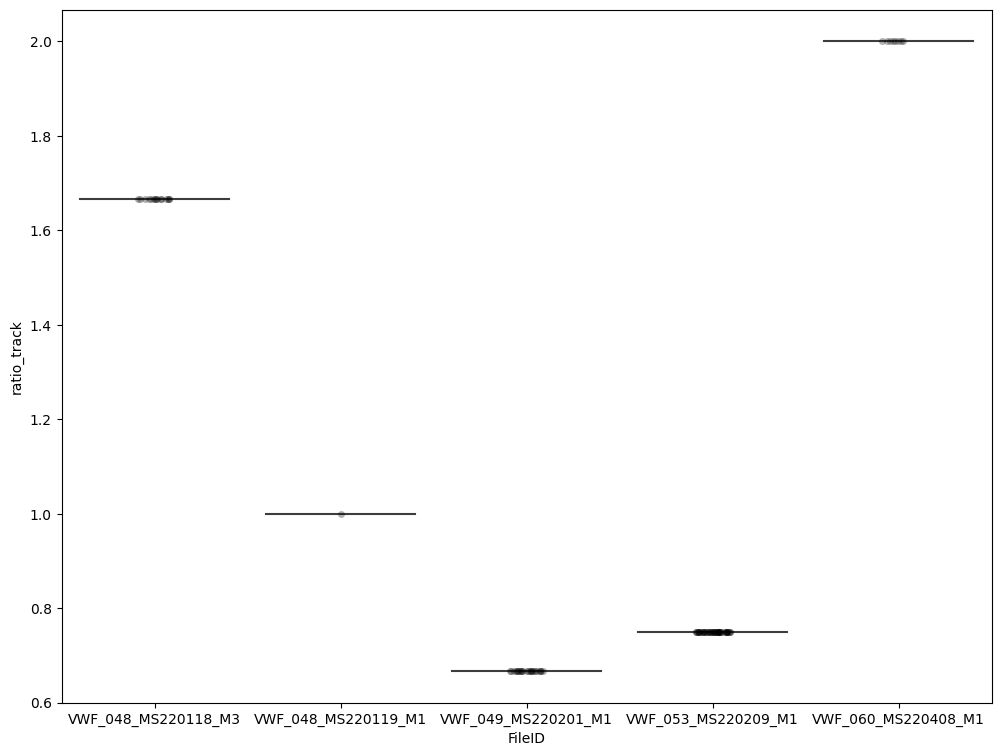

In [76]:
#COMPARING MANUAL AND CP TRACKS

#IMPORT BOTH

manual=pd.read_csv('/Users/secchim/Downloads/IVM_230412.csv', header = 0)
CP=pd.read_csv('/Users/secchim/Downloads/CellProfiler/movie_processing/movie_output/trackcorrect.csv', header = 0)

manual['FileID']=manual['file'].astype(str).str.upper()
for b, r in manual.iterrows():
            (manual.loc[b, "FileID"])=manual.loc[b,'FileID'][0:19]

# print(manual['FileID'])

FileID_list=manual['FileID'].unique()
print(FileID_list)

df_list =[]
grouped=manual.groupby(['cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=20:
        df_list.append(newdf)
manual20=pd.concat(df_list)
manu=manual20[['FileID','cell_ID']]
manu=manu.drop_duplicates()

df_list =[]
grouped=manu.groupby(['FileID'])
for i, newdf in grouped:
        newdf['track_count_manual']=len(newdf)
        df_list.append(newdf)
manual_count20=pd.concat(df_list)     
manual_count20=manual_count20[['FileID','track_count_manual']]  

FileID_list=CP['FileID'].unique()
print(FileID_list)

df_list =[]
grouped=CP.groupby(['Track_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=20:
        df_list.append(newdf)
CP20=pd.concat(df_list)
CPP=CP20[['FileID','Track_ID']]
CPP=CPP.drop_duplicates()

df_list =[]
grouped=CPP.groupby(['FileID'])
for i, newdf in grouped:
        newdf['track_count_CP']=len(newdf)
        df_list.append(newdf)
CP_count20=pd.concat(df_list)     
CP_count20=CP_count20[['FileID','track_count_CP']]  

comp=pd.merge(manual_count20, CP_count20[:], on = 'FileID')
comp['ratio_track']='ratio'
for b, r in comp.iterrows():
            (comp.loc[b, "ratio_track"])=comp.loc[b,'track_count_CP']/comp.loc[b,'track_count_manual']
print(comp)

sns.violinplot(x='FileID', y="ratio_track", data=comp, showfliers = False)
sns.stripplot(x='FileID', y="ratio_track", data=comp, dodge=True, color='black', alpha=0.3)

In [4]:
#MANUAL DATA PROCESSING

# data=pd.read_csv('/Users/secchim/Documents/Experiments/IVM_tracks230713.csv')
#new version including smaller tracks from aged mice
data=pd.read_csv('/Users/secchim/Downloads/neighbour_tracks230905.csv')

In [7]:
print(len(data['Final_Cell_ID'].unique())) #136 tracks total, now 257 

data['corrected_x_2']=data['x']
data['corrected_y_2']=data['y']
data['corrected_z_2']=data['z']

257


In [8]:
import math

#shift takes the next row(?) and puts it in the current row
data["corrected_x_2_next"] = data["corrected_x_2"].shift(-1)
data["corrected_y_2_next"] = data["corrected_y_2"].shift(-1)
data["corrected_z_2_next"] = data["corrected_z_2"].shift(-1)
print(data["corrected_x_2_next"], data ["corrected_x_2"])

#REMOVE FRAMES LONGER THAN 1H 

# print(data['Metadata_Timepoint'])
data=data[data['Metadata_Timepoint']!='na']
data['Metadata_Timepoint']=data['Metadata_Timepoint'].astype(int)
data=data[data['Metadata_Timepoint']<22]

#annotate the last timeframe 
data["Last_timepoint"]=True
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, "Metadata_Timepoint"])== (newdf['Metadata_Timepoint'].max()):
                newdf.loc[b, "Last_timepoint"]=True
            else:
                newdf.loc[b, "Last_timepoint"]=False
    dflist.append(newdf)
data=pd.concat(dflist)              
# print(data)

#REMOVE TRACKS SHORTER THAN 21 frames
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]<21:
        print(newdf['Final_Cell_ID'].unique())
        # for b, r in newdf.iterrows():
            # if (newdf.loc[b, "Metadata_Timepoint"])<21 and newdf.loc[b, "Last_timepoint"]=True:
    elif newdf.shape[0]==21:
        dflist.append(newdf)
data=pd.concat(dflist)              
# print(data)



# calculate distance between timeframes
data['distance']= None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False: 
                # print(b, newdf.loc[b, "Timeframe_Time"], newdf.loc[b,'Final_Cell_ID'], newdf.loc[b,'Metadata_Timepoint'], newdf.shape[0]-1)
                # try:
                newdf.loc[b, "distance"]=(math.sqrt((newdf.loc[b, "corrected_x_2"]-newdf.loc[b, "corrected_x_2_next"])**2+(newdf.loc[b, "corrected_y_2"]-newdf.loc[b, "corrected_y_2_next"])**2+(newdf.loc[b, "corrected_z_2"]-newdf.loc[b, "corrected_z_2_next"])**2))
                    # newdf["distance"]=(math.sqrt((newdf["corrected_x_2"][r]-newdf["corrected_x_2"][r+1])**2+(newdf["corrected_y_2"][r]-newdf["corrected_y_2"][r+1])**2+(newdf["corrected_z_2"][r]-newdf["corrected_z_2"][r+1])**2))
                # except:
                    # print(i, b, "error")
                    # newdf.loc[b, "distance"]='NaN'
                    # pass
        # print(newdf["distance"])
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['distance'])
#.sort_values(by=['Timeframe_Time']).reset_index()


#Calculate track length
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf.dropna()
    newdf['track_length']=newdf['distance'].sum()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['track_length'])   

#calculate displacement for every timepoint
data['displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    # stored_X0=newdf['corrected_x_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    # stored_Y0=newdf['corrected_y_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    # stored_Z0=newdf['corrected_z_2'][newdf['Metadata_Timepoint'] == (newdf['Metadata_Timepoint']).min()]
    stored_X0=0
    stored_Y0=0
    stored_Z0=0
    for b, r in newdf.iterrows():
        newdf.loc[b, "displacement"]=math.sqrt((newdf["corrected_x_2"][b]-stored_X0)**2+(newdf["corrected_y_2"][b]-stored_Y0)**2+(newdf["corrected_z_2"][b]-stored_Z0)**2)
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['displacement'])

#maximum displacement
data['max_displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['max_displacement']=newdf['displacement'].max()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['max_displacement'])

#frame speed
# data=data.drop_duplicates() #why do I have duplicates?
data['frame_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False: 
            #if newdf.loc[b,'displacement']>0 and newdf.loc[b+1, 'displacement']>0:
            # try:
                # newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/((newdf.loc[b,'Timeframe_Time']-newdf.loc[(b),'Timeframe_Time_next']).total_seconds()))#ideal way
                newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/180)
            # except:
                # newdf.loc[b, "frame_speed"]='NaN'
            # print(b, newdf["frame_speed"])
                # pass
            # else:
                # print(b, 'error')
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['frame_speed'])

#mean frame speed

data['mean_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['mean_speed']=newdf['frame_speed'].mean()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['mean_speed'])

# data["Timeframe_Time_next"] = data["Timeframe_Time"].shift(-1)
# #frame speed
# data=data.drop_duplicates() #why do I have duplicates?
# data['frame_speed']=None
# grouped=data.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     if newdf.shape[0]>=2:
#         for b, r in newdf.iterrows():
#             if (newdf.loc[b, 'Last_timepoint'])== False: 
#             #if newdf.loc[b,'displacement']>0 and newdf.loc[b+1, 'displacement']>0:
#             # try:
#                 newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/((newdf.loc[b,'Timeframe_Time']-newdf.loc[(b),'Timeframe_Time_next']).total_seconds()))
#             # except:
#                 # newdf.loc[b, "frame_speed"]='NaN'
#             # print(b, newdf["frame_speed"])
#                 # pass
#             # else:
#                 # print(b, 'error')
#     dflist.append(newdf)
# data=pd.concat(dflist)
# print(data['frame_speed'])

#linearity coefficient

data['linearity_coefficient']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['linearity_coefficient']=newdf['max_displacement']/newdf['track_length']
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['linearity_coefficient'])

#arrest coefficient
#speed<2/60um/sec

# data=data.dropna(axis=0)
#First classifying timeframes as arrested or not
data['arrested']=False
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    for b, r in newdf.iterrows():
        # print((newdf.loc[b,'mean_speed']),2/60, b)
        # print(newdf.loc[b])
        if (newdf.loc[b,'frame_speed'])!=None and (newdf.loc[b,'frame_speed'])<(2/60): #different from NaN
            newdf.loc[b,'arrested']=True
        else :
            newdf.loc[b,'arrested']=False
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrested'])

# LOTS OF DUPLICATES CREATED? WHEN ? #I think because of df list in the wrong place
datax=data.drop_duplicates()

data['arrest_coefficient']=False
data=data.drop_duplicates()
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf2=newdf[newdf['arrested']==True]
    newdf3=newdf[newdf['arrested']==False]
    # print(newdf2['arrested'].shape[0],newdf3['arrested'].shape[0])
    if ((newdf2.shape[0])+(newdf3.shape[0]))>1:
        newdf['arrest_coefficient']=(newdf2.shape[0])/((newdf2.shape[0])+(newdf3.shape[0]))
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrest_coefficient'])

#DOESN'T WORK YET
# data['variance_speed']=None
# grouped=data.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     newdf2=newdf[['frame_speed']]
#     x=(newdf2.var())
#     for b, r in newdf.iterrows():
#         newdf.loc[b,'variance_speed']=x.astype(int)
#     # print(x)
#     # newdf['variance_speed']=x
#     print(newdf['variance_speed'])
#     # dflist.append(newdf)
# # data=pd.concat(dflist)
# # print(data['variance_speed'])

# data.to_csv('/Users/secchim/Downloads/manual_small_tracks230805.csv')#this one has all movies up to VWF_109
data.to_csv('/Users/secchim/Downloads/neighbour_tracks230921.csv')

0       1067.730
1       1069.680
2       1069.680
3       1067.730
4       1070.650
          ...   
4791     656.377
4792     658.845
4793     663.645
4794     660.720
4795         NaN
Name: corrected_x_2_next, Length: 4796, dtype: float64 0       1068.220
1       1067.730
2       1069.680
3       1069.680
4       1067.730
          ...   
4791     656.740
4792     656.377
4793     658.845
4794     663.645
4795     660.720
Name: corrected_x_2, Length: 4796, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:20: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:34: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:50: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


[3.2]
[9.2]
[11.1]
[11.2]
[11.3]
[15.1]
[15.2]
[15.3]
[15.4]
[15.5]
[17.5]
[20.8]
[21.6]
[24.1]
[24.9]
[25.2]
[27.2]
[27.3]
[29.4]
[30.3]
[30.7]
[30.8]
[30.9]
[31.5]
[31.6]
[31.9]
[33.4]
[33.5]
[34.1]
[34.2]
[39.2]
[39.3]
[39.4]
[40.2]
[40.3]
[40.4]
[40.5]
[40.6]
[40.7]
[40.8]
[40.9]
[41.1]
[41.3]
[41.4]
[41.5]
[41.6]
[41.7]
[41.8]
[41.9]
[42.1]
[42.2]
[42.3]
[42.4]
[42.5]
[42.6]
[42.7]
[42.8]
[42.9]
[43.1]
[43.2]
[43.3]
[43.4]
[43.5]
[43.6]
[43.8]
[43.9]
[44.2]
[44.3]
[44.4]
[44.8]
[44.9]
[45.2]
[45.3]
[45.6]
[45.8]
[45.9]
[46.3]
[46.5]
[46.6]
[46.7]
[46.8]
[46.9]
[47.2]
[47.5]
[47.7]
[47.8]
[47.9]
[48.1]
[48.2]
[48.3]
[48.4]
[48.5]
[48.6]
0       0.565956
1       2.110832
2       0.945991
3       2.344269
4        3.14934
          ...   
4791    4.909468
4792    2.747076
4793    7.110465
4794    7.026395
4795        None
Name: distance, Length: 3276, dtype: object
0       37.726793
1       37.726793
2       37.726793
3       37.726793
4       37.726793
          ...    
4791    73.6

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:72: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:83: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


0       1117.598117
1       1117.213004
2       1119.224101
3       1119.500375
4       1117.726448
           ...     
4791     862.700256
4792     859.257764
4793     861.097878
4794     865.814671
4795     862.384865
Name: displacement, Length: 3276, dtype: object
0       1122.519451
1       1122.519451
2       1122.519451
3       1122.519451
4       1122.519451
           ...     
4791     868.812340
4792     868.812340
4793     868.812340
4794     868.812340
4795     868.812340
Name: max_displacement, Length: 3276, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:100: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:111: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


0       0.003144
1       0.011727
2       0.005256
3       0.013024
4       0.017496
          ...   
4791    0.027275
4792    0.015262
4793    0.039503
4794    0.039036
4795        None
Name: frame_speed, Length: 3276, dtype: object
0       0.010480
1       0.010480
2       0.010480
3       0.010480
4       0.010480
          ...   
4791    0.020449
4792    0.020449
4793    0.020449
4794    0.020449
4795    0.020449
Name: mean_speed, Length: 3276, dtype: float64
0       29.753906
1       29.753906
2       29.753906
3       29.753906
4       29.753906
          ...    
4791    11.801723
4792    11.801723
4793    11.801723
4794    11.801723
4795    11.801723
Name: linearity_coefficient, Length: 3276, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:134: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:168: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:182: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


0        True
1        True
2        True
3        True
4        True
        ...  
4791     True
4792     True
4793    False
4794    False
4795    False
Name: arrested, Length: 3276, dtype: bool


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/2430160201.py:201: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


0       0.952381
1       0.952381
2       0.952381
3       0.952381
4       0.952381
          ...   
4791    0.809524
4792    0.809524
4793    0.809524
4794    0.809524
4795    0.809524
Name: arrest_coefficient, Length: 3276, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/1802566471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/1802566471.py:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/1802566471.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of le

1.1
1.2
1.22
1.3
1.4
2.1
3.1
3.11
3.3
3.4
3.5
3.6
4.1
5.1
6.1
7.1
8.1
8.2
9.3
10.1
12.1
13.1
13.2
14.1
14.2
14.3
16.1
17.1
17.2
17.3
17.4
18.1
18.2
18.3
18.4
19.1
23.1
24.2
24.3
24.4
24.5
24.6
24.7
24.8
27.1
27.4
27.5
27.6
28.1
28.2
28.3
28.4
28.5
28.6
28.7
28.8
29.1
29.2
29.3
29.5
29.6
31.1
31.11
31.2
31.3
31.4
31.7
31.8
32.1
32.2
32.3
32.4
32.5
32.6
32.7
33.1
33.2
33.3
33.6
33.7
34.3
34.4
35.1
35.2


ValueError: must have at least one row in constraint matrix

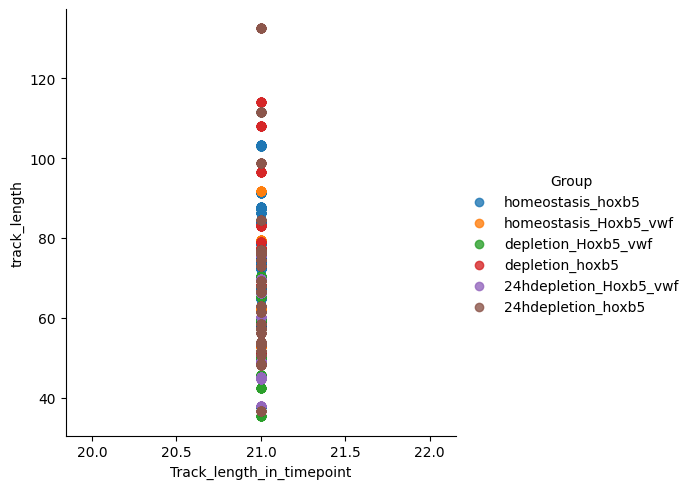

In [3]:
#PRINT TRACK LENGTH AS A FUNCTION OF TIME LENGTH 
data=pd.read_csv('/Users/secchim/Downloads/manual_tracks230711.csv', header=0)

datax=data[data['track_length']!=0]
datax=datax[datax['Treatment']!='ageing']
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'track_length']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
# print(len(datab))
datab.dropna()
df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=17:#was 11
        df_list.append(newdf)
        print(i)
datab=pd.concat(df_list)

df_list =[]
datab['Tracked_coefficient']=None
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    newdf['Track_length_in_timepoint']=newdf.shape[0]
    df_list.append(newdf)
datab=pd.concat(df_list)

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(12,9))#6,4.5
# g=sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab, hue='Hoxb5_status_corrected', style='Treatment')
# sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab, hue='Hoxb5_status_corrected', style='Treatment')

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
# sns.lineplot(data=datab, x="Track_length_in_timepoint", y="track_length", hue='Hoxb5_status_corrected', style='Treatment')
sns.lmplot(data=datab, x='Track_length_in_timepoint', y='track_length', hue='Group', col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, 
            hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, 
            seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, 
            facet_kws=None)
# g.set(ylim=(0, 200))


model = ols('track_length ~  C(Hoxb5_status_corrected) + C(Treatment) +C(Track_length_in_timepoint)', data=datab).fit()
sm.stats.anova_lm(model, typ=2)

sns.lmplot(data=datab, x='Track_length_in_timepoint', y='max_displacement', hue='Group', col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, 
            hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, 
            seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, 
            facet_kws=None)


# model = ols('max_displacement ~  C(Hoxb5_status_corrected) + C(Treatment) +C(Track_length_in_timepoint)', data=datab).fit()
# sm.stats.anova_lm(model, typ=2)
datab=datab.drop_duplicates()
# datab.to_csv('/Users/secchim/Downloads/manual_track_sum.csv')#this one has all movies up to VWF_109

[29.1, 29.1, 34.1, 34.1, 34.2, 37.6, 37.6]


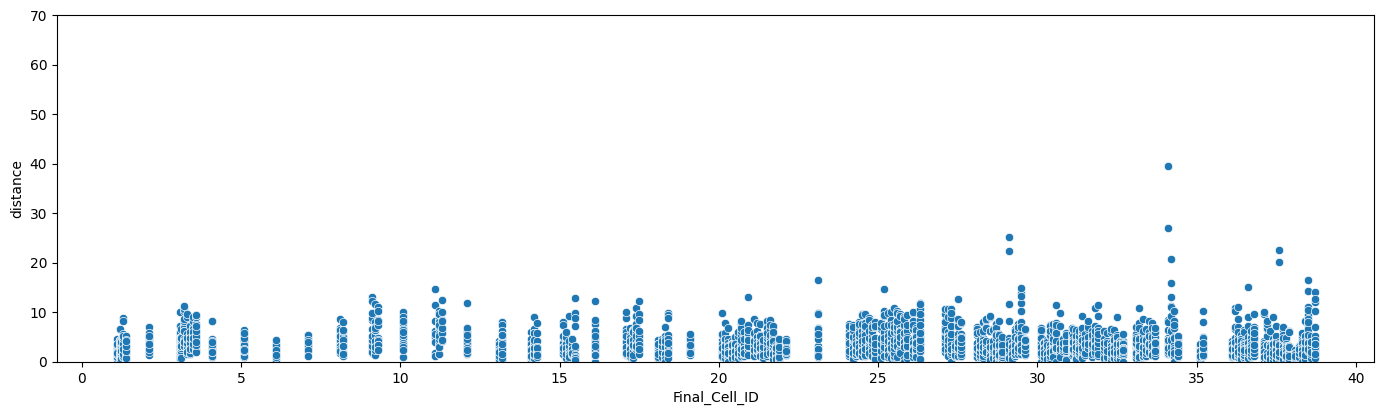

In [21]:
#distance on y axis, metadatatimepoint on x axis 

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(17,4.5))
# g=sns.scatterplot(x="Metadata_Timepoint", y="distance", data=data)
# g.set(ylim=(0, 70))

fig, ax = plt.subplots(figsize=(17,4.5))
g=sns.scatterplot(x="Final_Cell_ID", y="distance", data=data)
g.set(ylim=(0, 70))

over30=[]
for b, r in data.iterrows():
    if data.loc[b,'distance']>20:
        over30.append(data.loc[b, 'Final_Cell_ID'])

print(over30)

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/1790263130.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datax['Group']=data['Hoxb5_status_corrected']+data['Treatment']
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


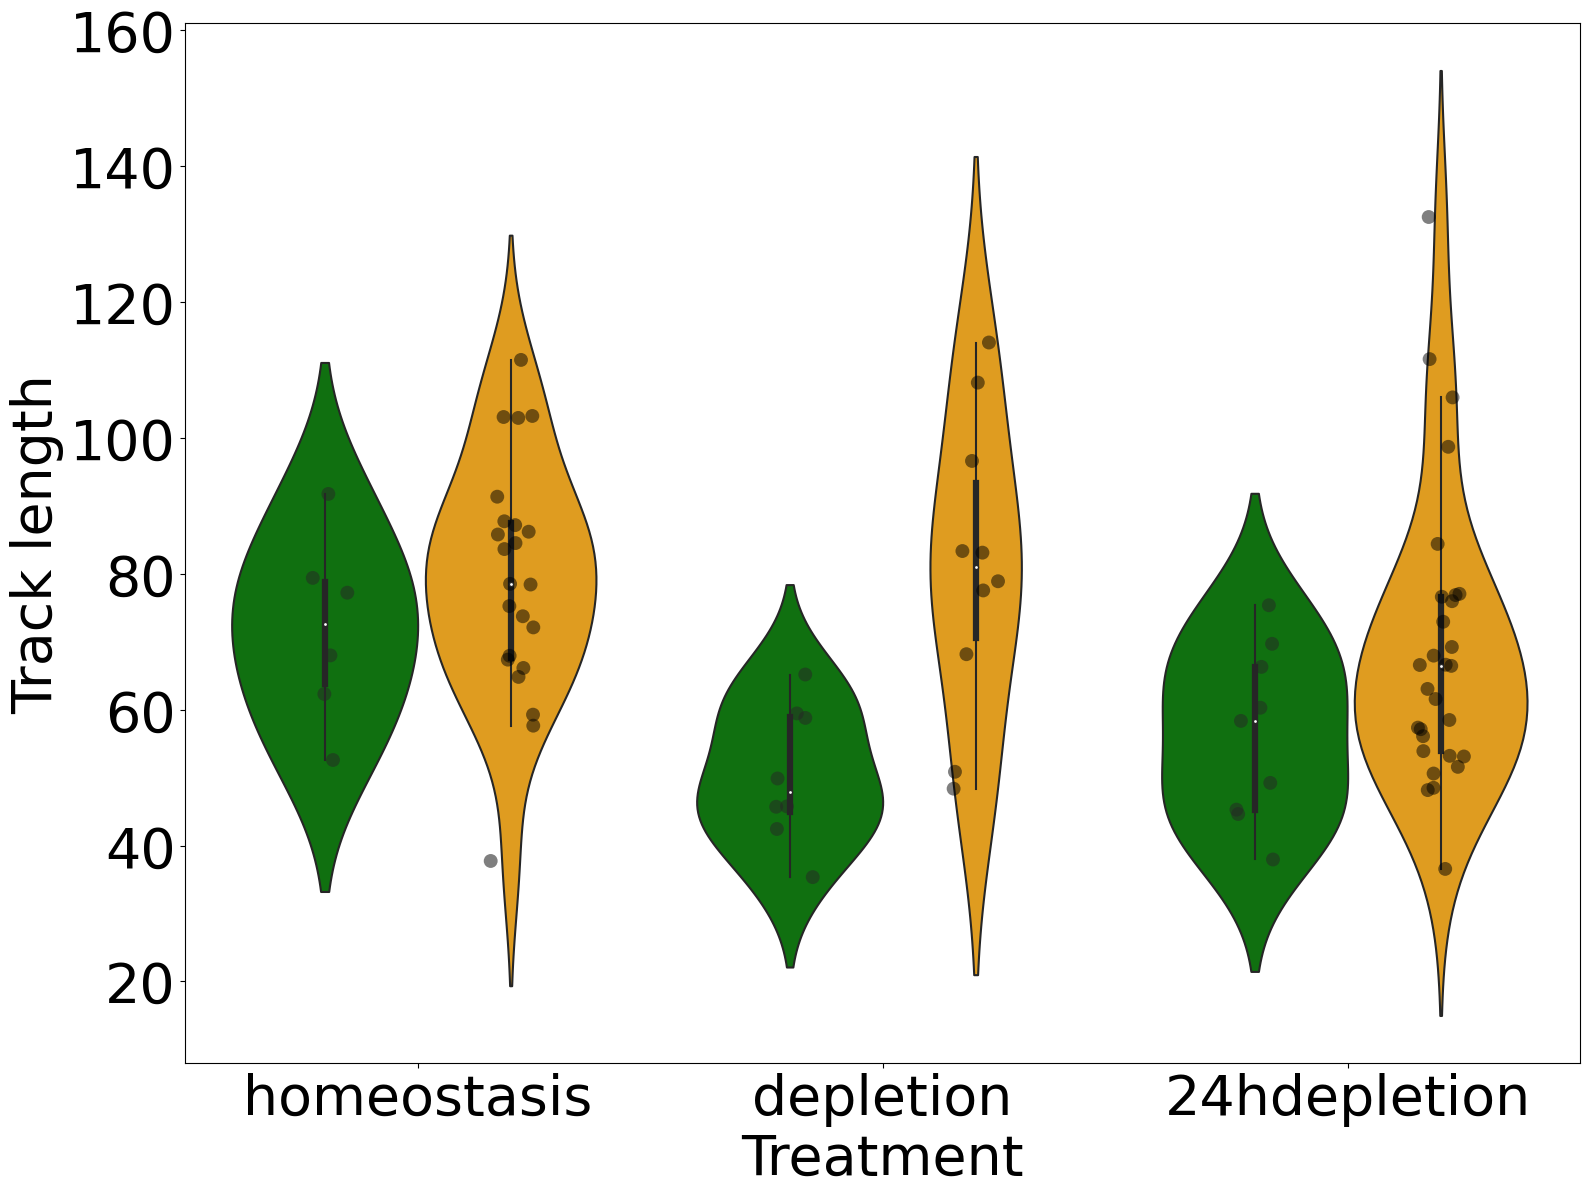

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


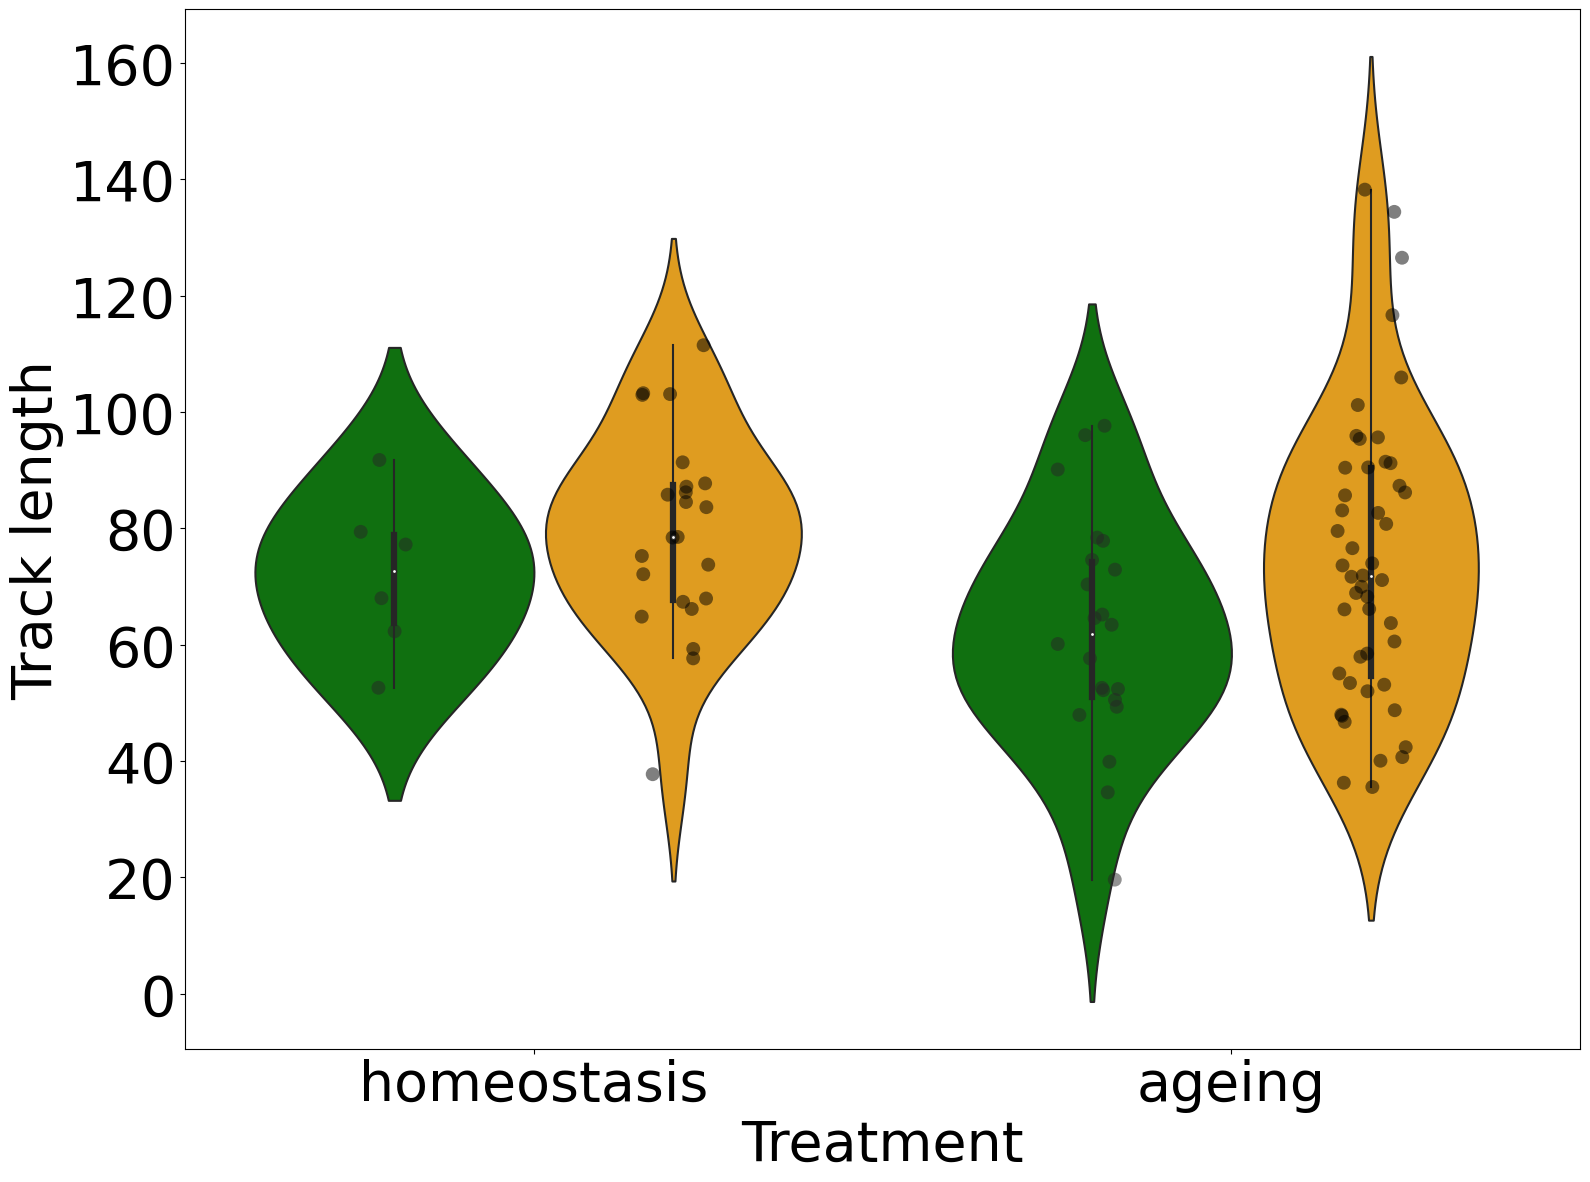

<class 'statsmodels.iolib.table.SimpleTable'>

In [12]:
#TRACK LENGTH FOR HOMEOSTASIS AND DEPLETION
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 13.5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["font.size"]=40
# print ("New size:", fig_size)

datax=data[data['Treatment']!='ageing']
datax['Group']=data['Hoxb5_status_corrected']+data['Treatment']
dx=datax[['Treatment', 'Hoxb5_status_corrected', 'track_length','Group']]
dx=dx.drop_duplicates()
g=( sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=dx, s=10, dodge=True, color='black', alpha=0.5, legend=False, hue_order=('Hoxb5_vwf','hoxb5')),sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="track_length", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), legend=False))
# plt.legend(title='Cell type', loc='upper left', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Track length')
# plt.legend(fontsize='x-large', title_fontsize='40')
plt.show(g)
model = ols('track_length ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)
sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()

sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Group'], alpha=0.05).summary()
# g=sns.scatterplot(x="Treatment", y="track_length", data=data, hue="Hoxb5_status_corrected")


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


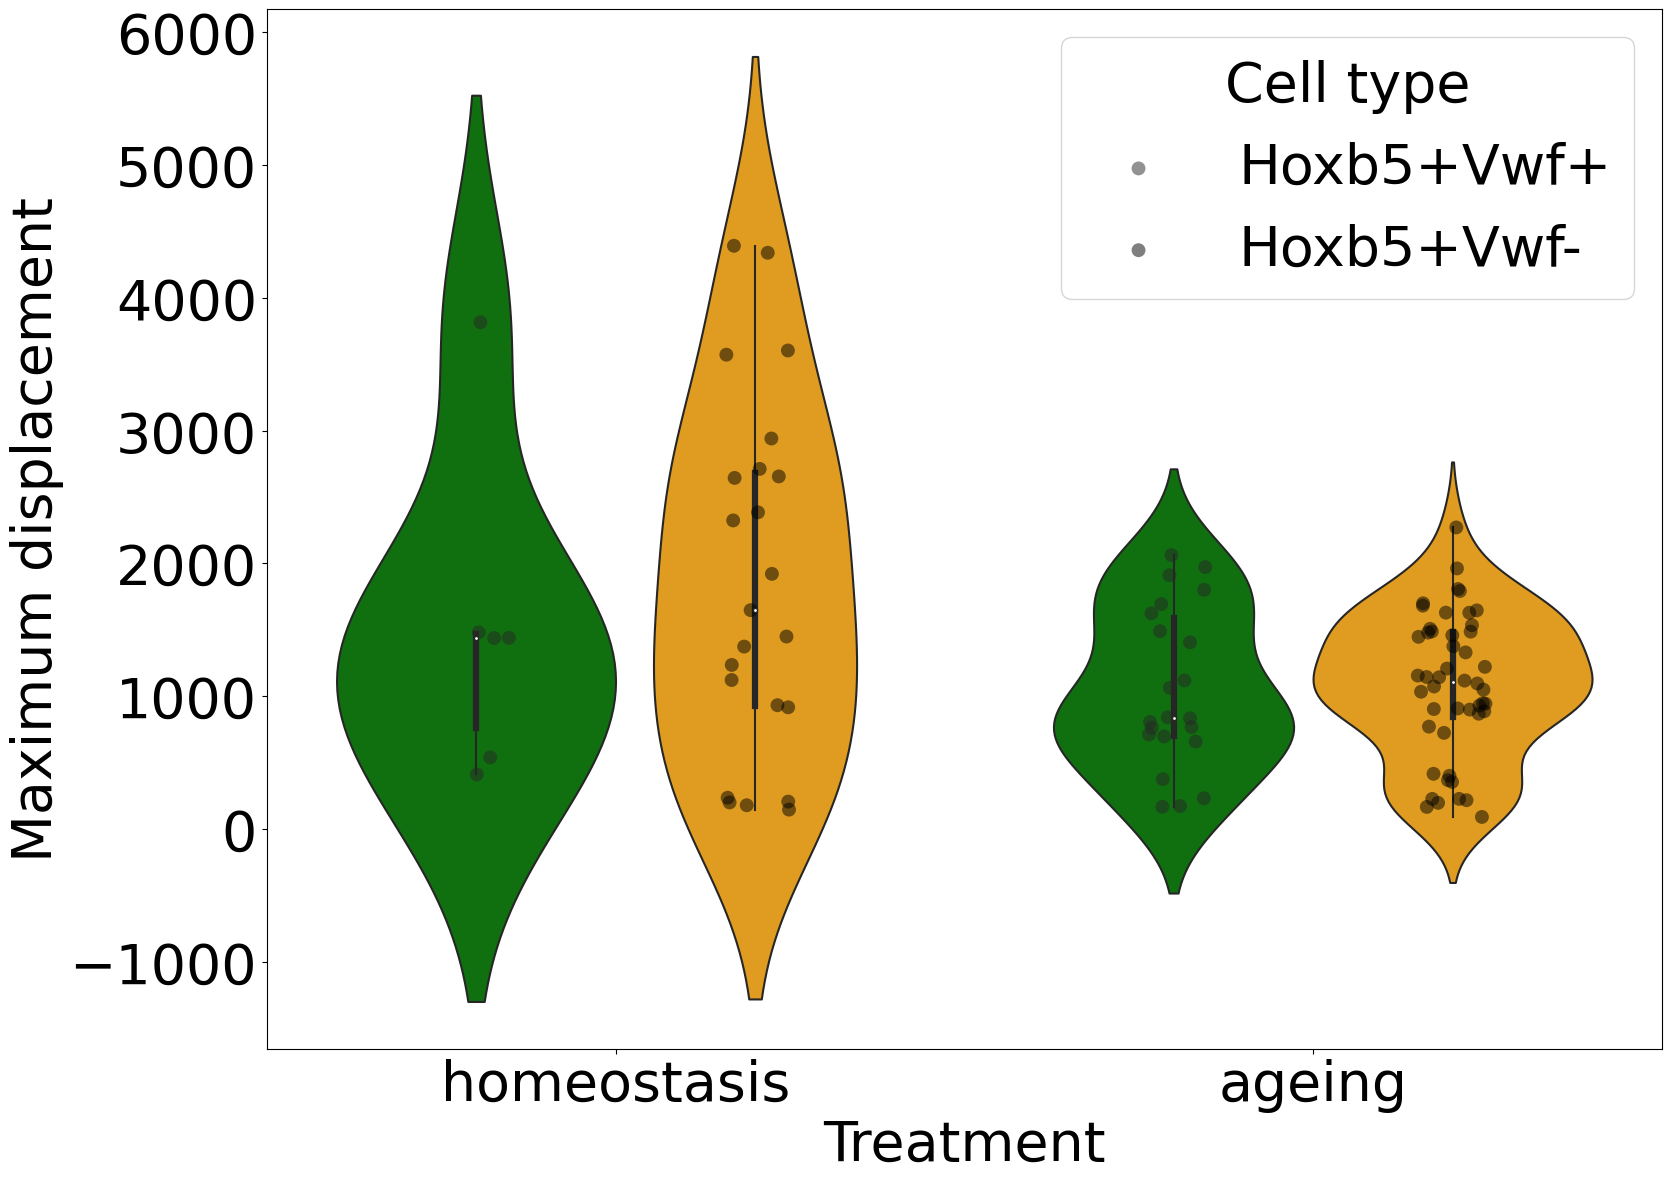

sum_sq    df          F    PR(>F)
C(Hoxb5_status_corrected)  2.254701e+05   1.0   0.317880  0.574199
C(Treatment)               1.043730e+07   1.0  14.715086  0.000224
Residual                   6.809209e+07  96.0        NaN       NaN

In [15]:
#PLOTTING HOMEOSTASIS AND DEPLETION 

# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 13.5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["font.size"]=40
# print ("New size:", fig_size)

# # datax=data[data['Treatment']!='ageing']
# datax['Group']=data['Hoxb5_status_corrected']+data['Treatment']

# #Full dataset
# # dx=data[['Treatment', 'Hoxb5_status_corrected', 'track_length']]
# # dx=dx.drop_duplicates()
# # sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="track_length", data=dx, showfliers = False)
# # sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=dx, dodge=True, alpha=0.3, jitter=0.3)

# # Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'max_displacement','Group']]
# dx=dx.drop_duplicates()
# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="max_displacement", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="max_displacement", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # plt.legend([], [], frameon=False)
# g[1].set(ylabel='Maximum displacement')
# plt.show(g)
# model = ols('max_displacement ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Group'], alpha=0.05).summary()




#Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'arrest_coefficient']]
# dx=dx.drop_duplicates()

# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Arrest coefficient')
# plt.show(g)

# model = ols('arrest_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Treatment'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()


#Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'arrest_coefficient','Final_Cell_ID','Group']]
# dx=dx.drop_duplicates()

# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Arrest coefficient')
# plt.show(g)

# model = ols('arrest_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Treatment'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Group'], alpha=0.05).summary()

#Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'mean_speed','Group']]
# dx['mean_speed']=dx['mean_speed']*60
# dx=dx.drop_duplicates()

# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="mean_speed", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="mean_speed", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# # plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Mean speed')
# plt.show(g)

# model = ols('mean_speed ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Group'], alpha=0.05).summary()

# #Only cells that moved
# datax=datax[datax['max_displacement']>10]
# # # dx=dx[['Treatment', 'Hoxb5_status_corrected', 'linearity_coefficient']]
# # # dx=dx.drop_duplicates()
# # # sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, showfliers = False, palette=['green','orange'], order=('homeostasis','depletion','24hdepletion','ageing'))
# # # sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, color='black', alpha=0.3, order=('homeostasis','depletion','24hdepletion','ageing'))
# # # model = ols('linearity_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# # # sm.stats.anova_lm(model, typ=2)
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Treatment'], alpha=0.05).summary()
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()

# # # # #Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'linearity_coefficient','Final_Cell_ID','Group']]
# dx=dx.drop_duplicates()
# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')),sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))

# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # plt.legend([], [], frameon=False)
# g[1].set(ylabel='Linearity coefficient')
# plt.show(g)
# model = ols('linearity_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Group'], alpha=0.05).summary()



New size: [12, 9]


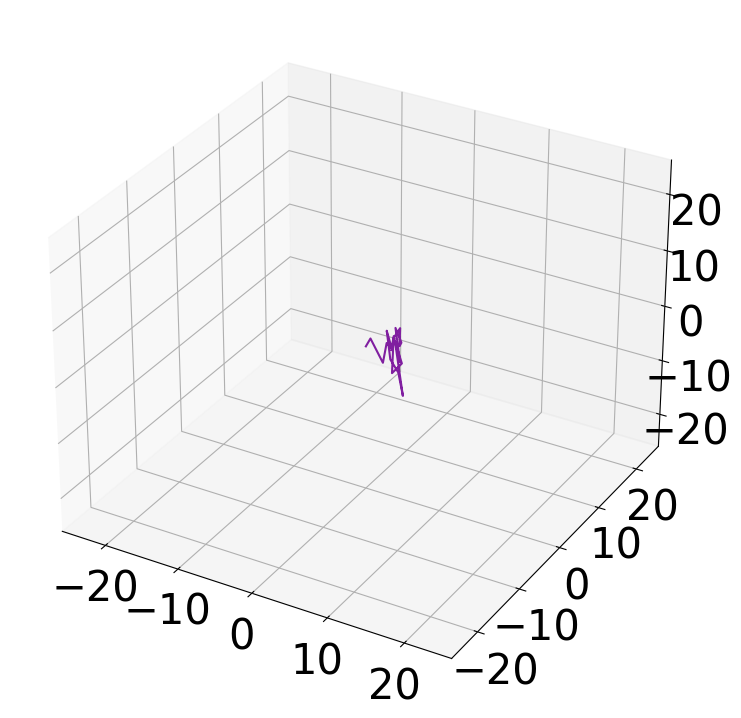

In [41]:
### homeostasis plot, separating Hoxb5+ and Hoxb5+Vwf+ FOR POSTER FIGURE NO LEGEND

fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')



my_list_hoxb5vwf = [3.3]#3.3,3.5, 14.1, 17.1, 13.1, 28.2, (31.3???)

for a in my_list_hoxb5vwf:
    data1= data[(data['Final_Cell_ID'] == a)]
    X1= data1['corrected_x_2']
    Y1= data1['corrected_y_2']
    Z1= data1['corrected_z_2']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, c=(r,g,b))
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_zlim(-25, 25)


    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    # plt.rcParams['axes.labelsize']=15
    plt.rcParams["font.size"]=30
    print ("New size:", fig_size)

In [30]:
dx=data[data['Hoxb5_status_corrected']=='hoxb5']
hoxb5list=dx['Final_Cell_ID'].unique()
print(len(hoxb5list))
dx=data[data['Hoxb5_status_corrected']=='Hoxb5_vwf']
hoxb5vwflist=dx['Final_Cell_ID'].unique()
print(len(hoxb5vwflist))

dx=data[data['Hoxb5_status_corrected']=='hoxb5']
dx=dx[['Treatment', 'Hoxb5_status_corrected']]
dx=dx.drop_duplicates()
print(dx)
print((dx[dx['Treatment']=='homeostasis']))

# dx=data[data['Hoxb5_status_corrected']=='Hoxb5_vwf']
# dx=dx[['Treatment', 'Hoxb5_status_corrected']]
# dx=dx.drop_duplicates()
# print(dx)

56
21
         Treatment Hoxb5_status_corrected
0      homeostasis                  hoxb5
472      depletion                  hoxb5
706   24hdepletion                  hoxb5
1074        ageing                  hoxb5
     Treatment Hoxb5_status_corrected
0  homeostasis                  hoxb5


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_11485/3947743707.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


[array([3.2]), array([9.2]), array([11.1]), array([11.2]), array([11.3]), array([15.1]), array([15.2]), array([15.3]), array([15.4]), array([15.5]), array([17.5]), array([24.1]), array([24.9]), array([27.2]), array([27.3]), array([29.1]), array([29.4]), array([30.3]), array([30.7]), array([30.8]), array([30.9]), array([31.5]), array([31.6]), array([31.9]), array([33.4]), array([33.5])]


<class 'statsmodels.iolib.table.SimpleTable'>

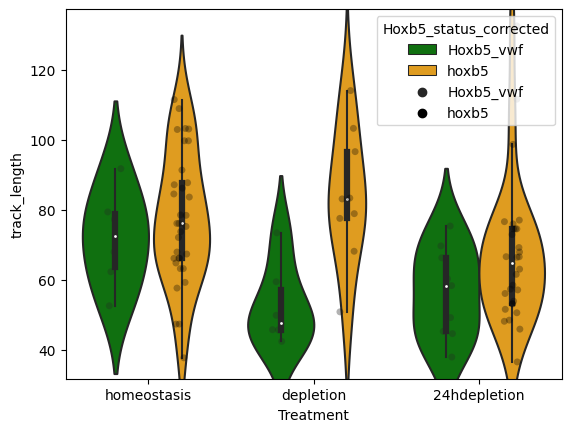

In [174]:
### DELETE THIS CELL????
data=data[data['Treatment']!='ageing']

grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
excluded=[]
for i, newdf in grouped:
    if newdf.shape[0]==21:
        dflist.append(newdf)
    elif newdf.shape[0]>21:
        newdf=newdf.iloc[0:21,:]
        dflist.append(newdf)
    else:
        excluded.append(newdf['Final_Cell_ID'].unique())
datax=pd.concat(dflist)
# print(data['distance'])
print(excluded)

###TRACK LENGTH
dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'track_length','file']]
dx=dx.drop_duplicates()

sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="track_length", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'))
sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=dx, dodge=True, color='black', alpha=0.3, hue_order=('Hoxb5_vwf','hoxb5'))
model = ols('track_length ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)
sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Treatment'], alpha=0.05).summary()
sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()

###MAXIMUM DISPLACEMENT
# dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement','file','track_length']]
# dx=dx.drop_duplicates()
# # dx.to_csv('/Users/secchim/Downloads/manual_tracks.csv')

# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="max_displacement", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'))
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="max_displacement", data=dx, dodge=True, color='black', alpha=0.3, hue_order=('Hoxb5_vwf','hoxb5'))
# model = ols('max_displacement ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()

###MEAN SPEED
# dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'mean_speed']]
# dx=dx.drop_duplicates()

# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="mean_speed", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'))
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="mean_speed", data=dx, dodge=True, color='black', alpha=0.3, hue_order=('Hoxb5_vwf','hoxb5'))
# model = ols('mean_speed ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()


#WHAT'S THE BELOW????? HOW THE LAST TIMEPOINT DOESN'T WORK?????
# datax["Last_timepoint_2"]=True
# grouped=datax.groupby(['Final_Cell_ID'])
# dflist=[]
# for i, newdf in grouped:
#     for b, r in newdf.iterrows():
#         if (newdf.loc[b, "Metadata_Timepoint"])== (newdf['Metadata_Timepoint'].max()):
#             newdf.loc[b, "Last_timepoint_2"]=True
#         else:
#             newdf.loc[b, "Last_timepoint_2"]=False
#     dflist.append(newdf)
# datax=pd.concat(dflist)              
# print(datax['Last_timepoint_2'])


# dx=datax[datax["Last_timepoint_2"==True]]


# dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'distance']]
# dx=dx.dropna(axis=0)
# # dx=dx.drop_duplicates()
# sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="distance", data=dx, showfliers = False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=dx, dodge=True, color='black', alpha=0.3)
# model = ols('distance ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


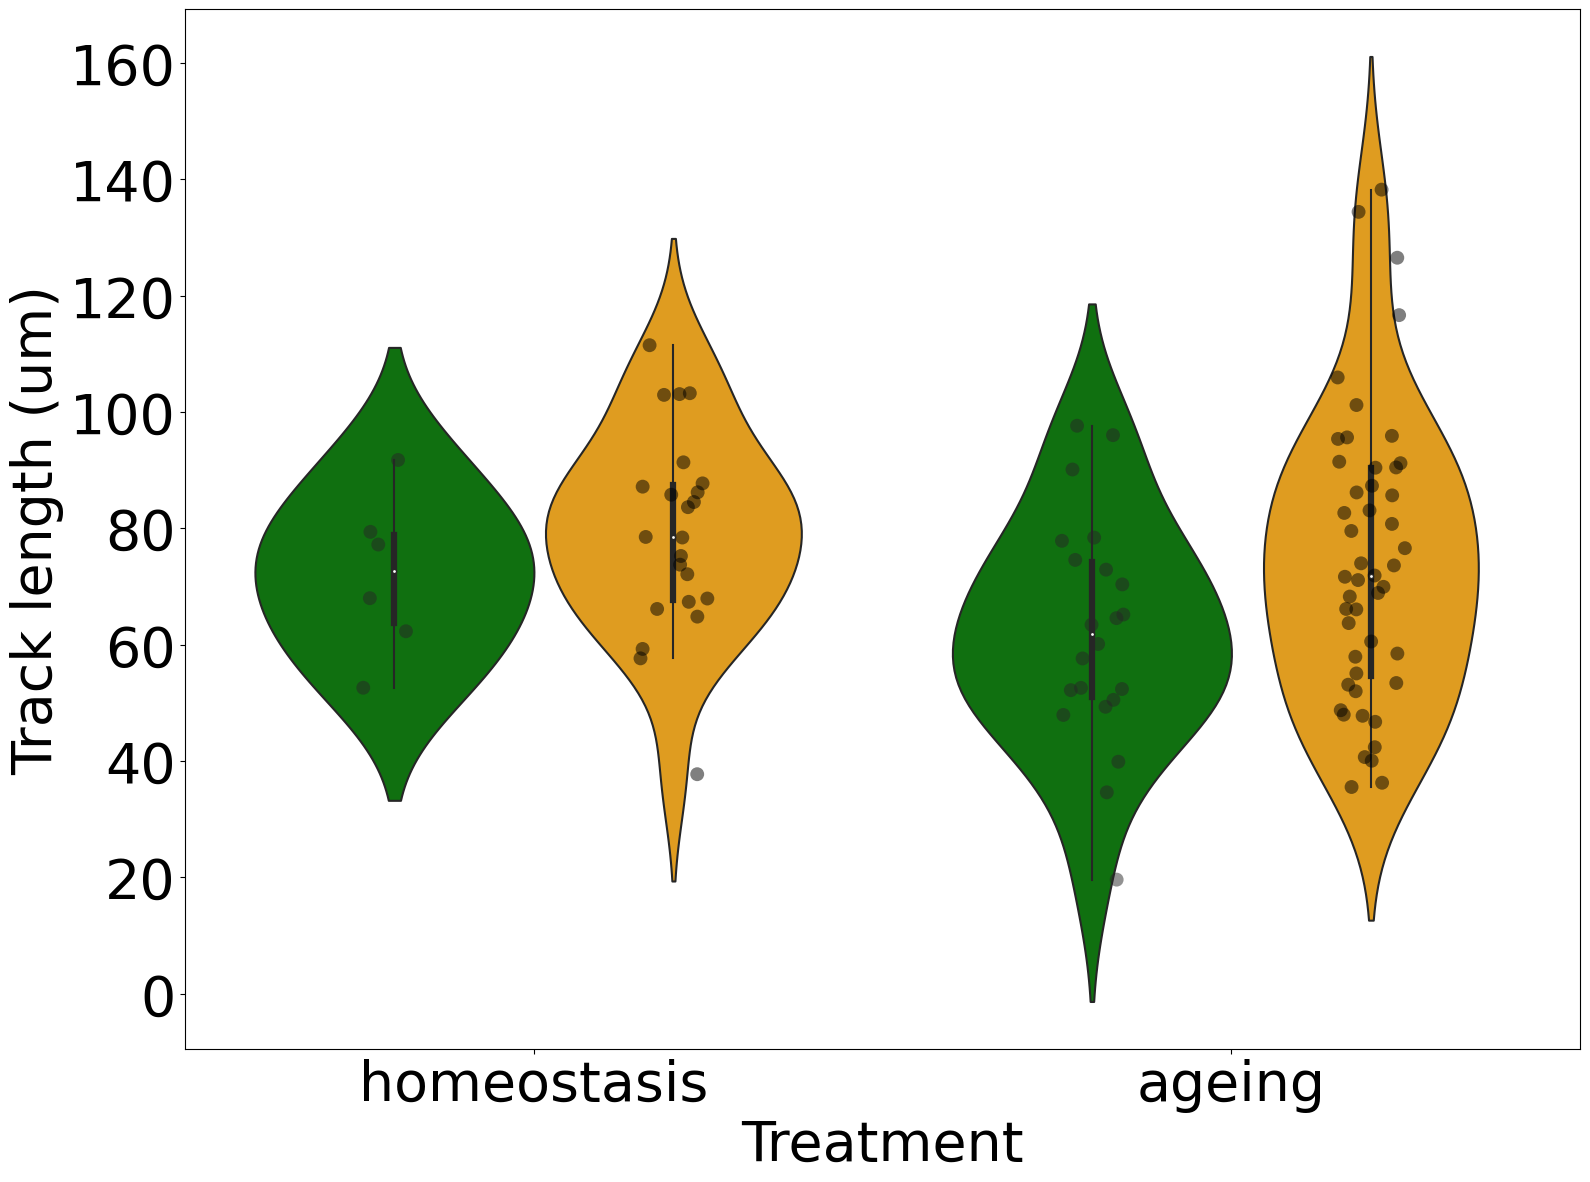

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


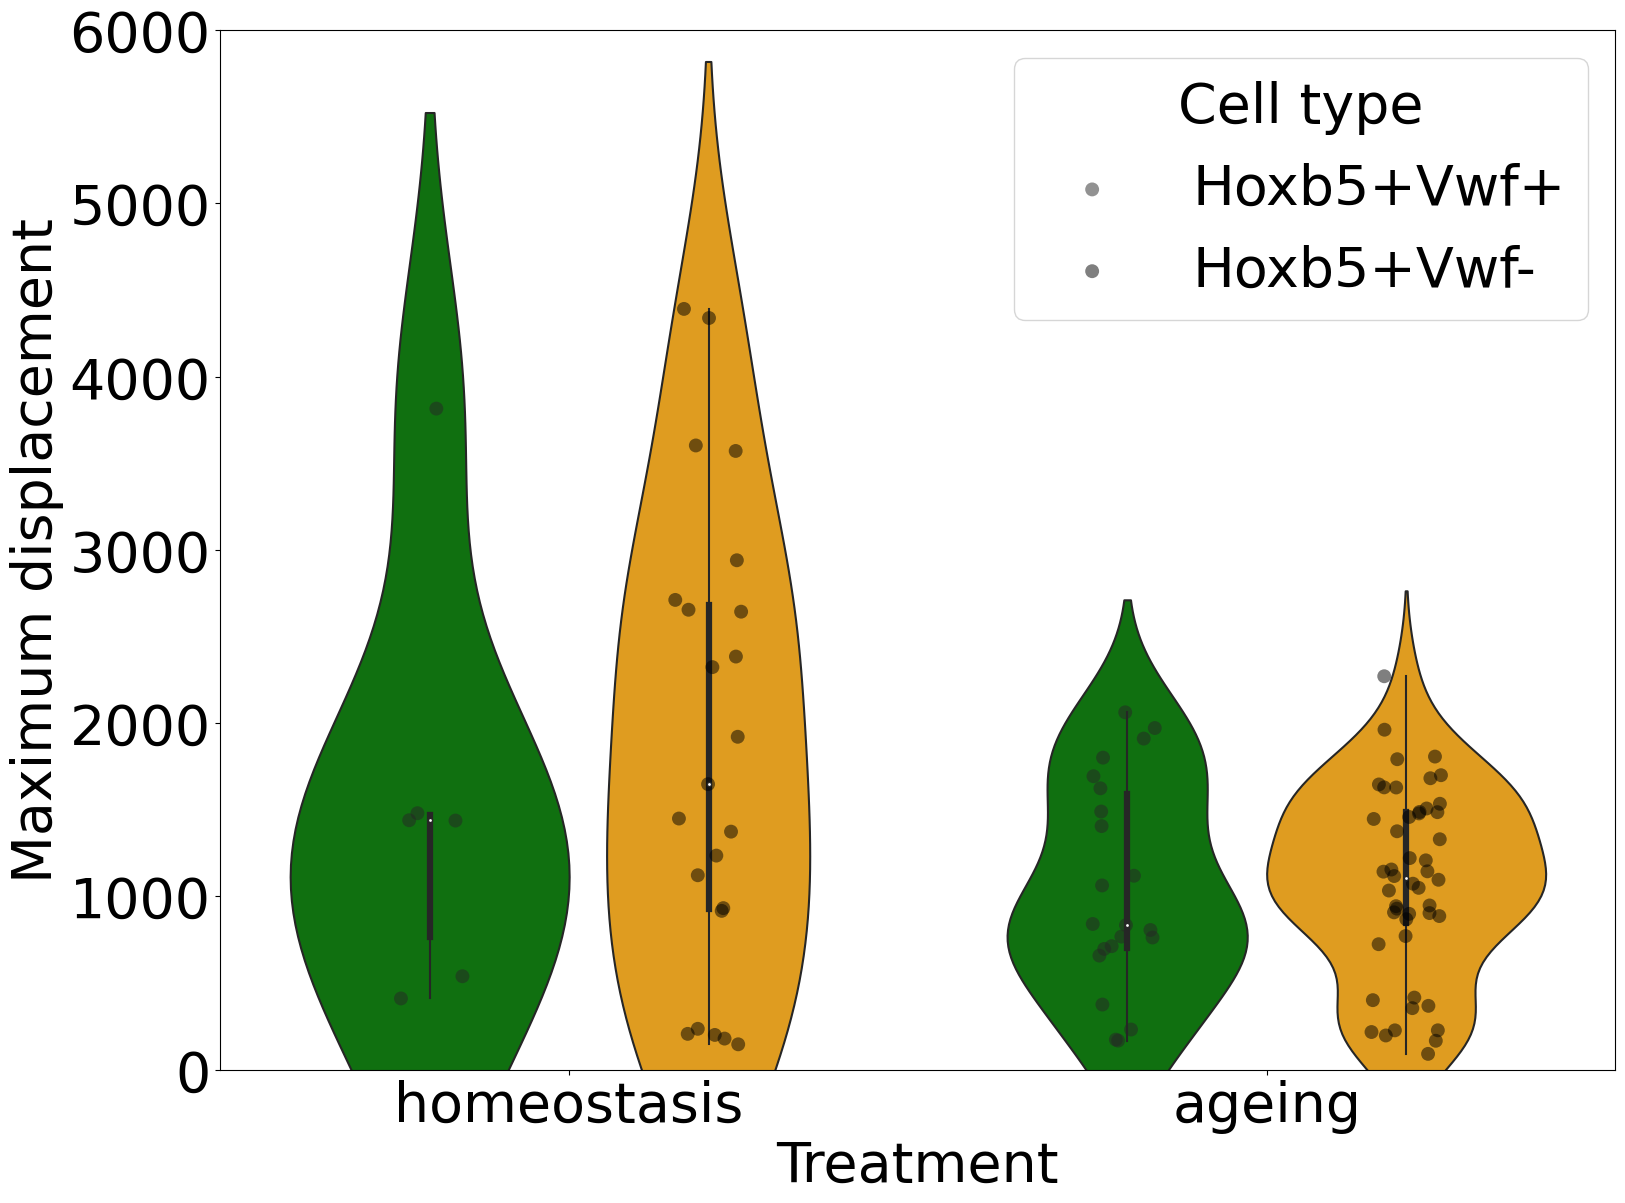

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


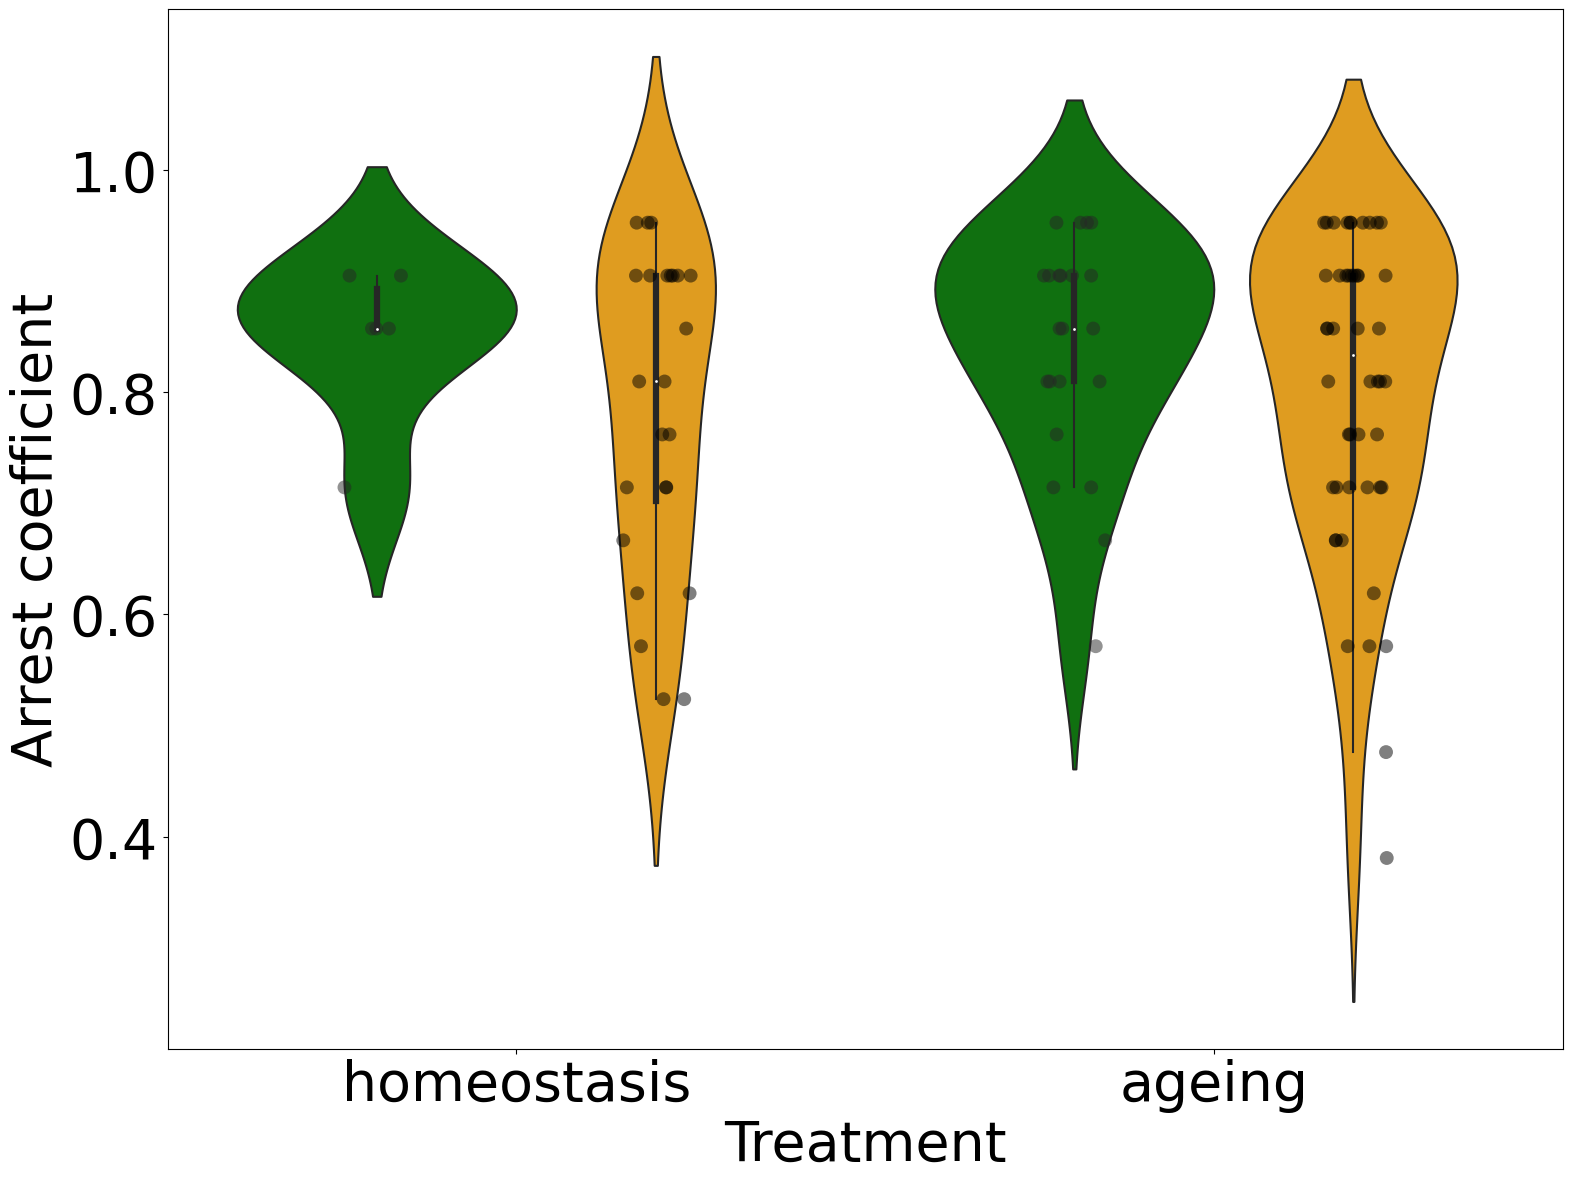

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_26476/1742483659.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx['mean_speed']=dx['mean_speed']*60
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


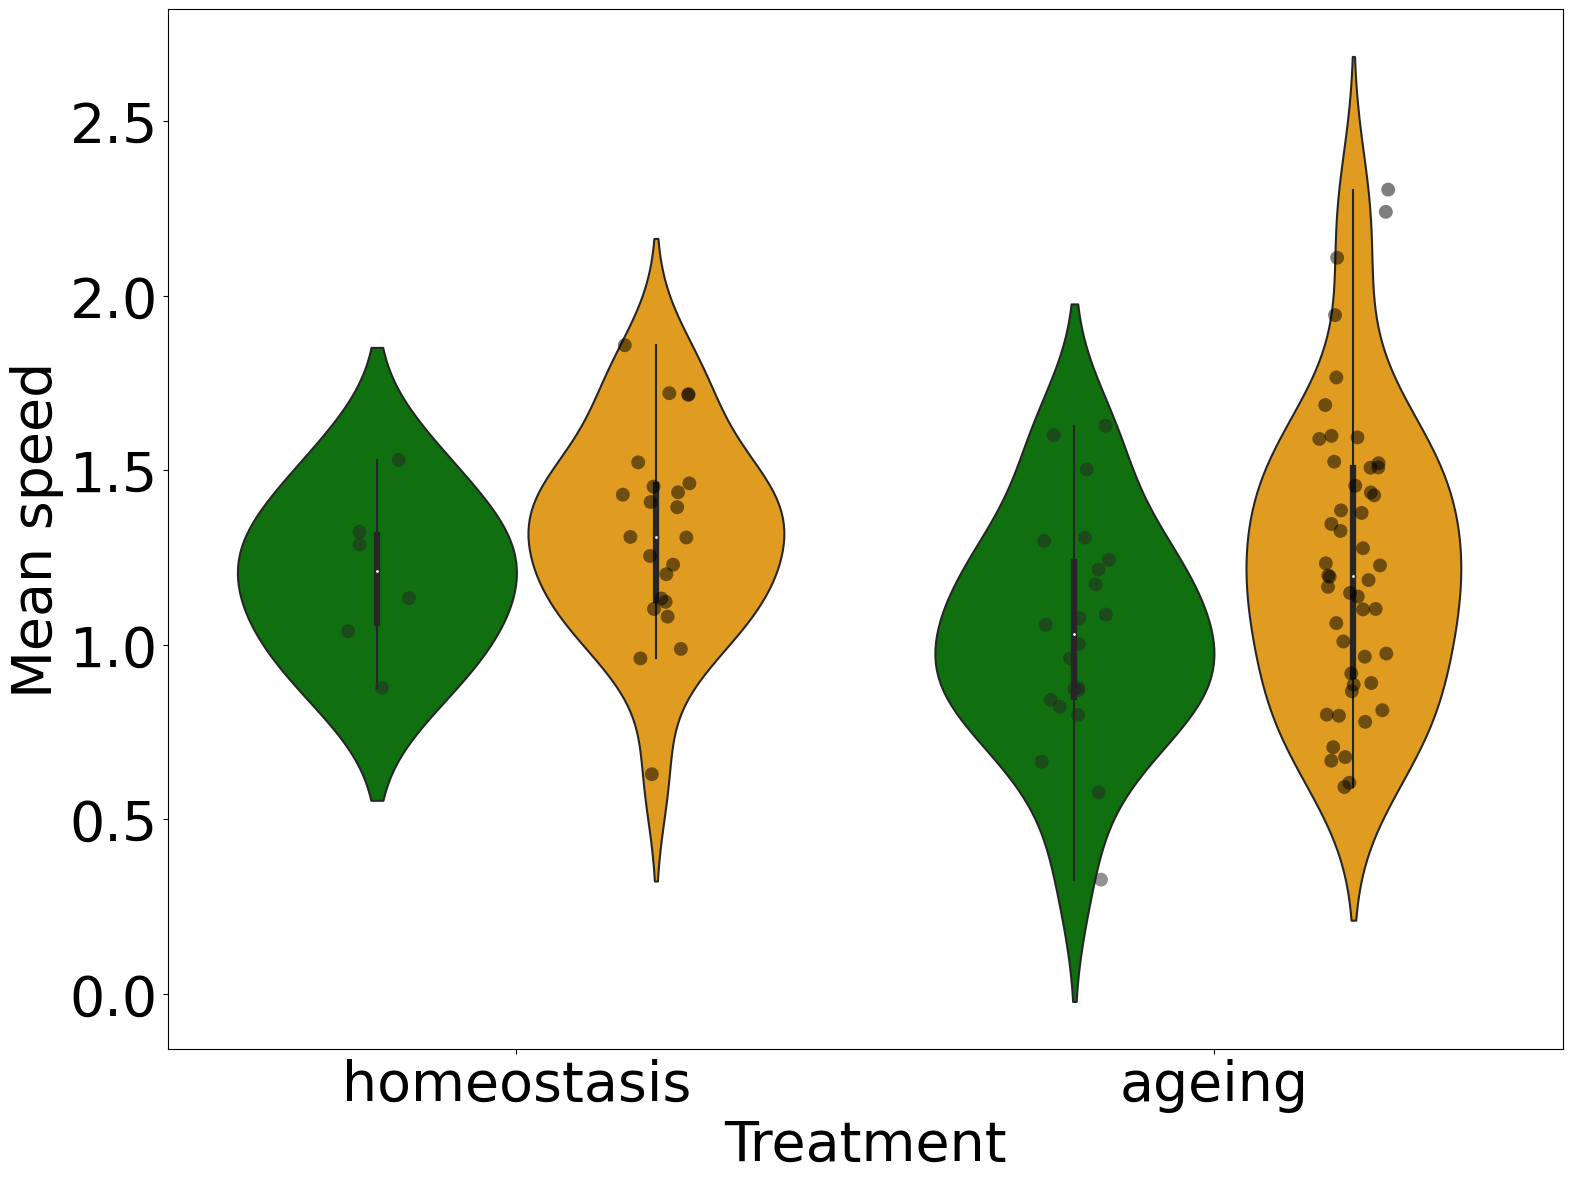

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


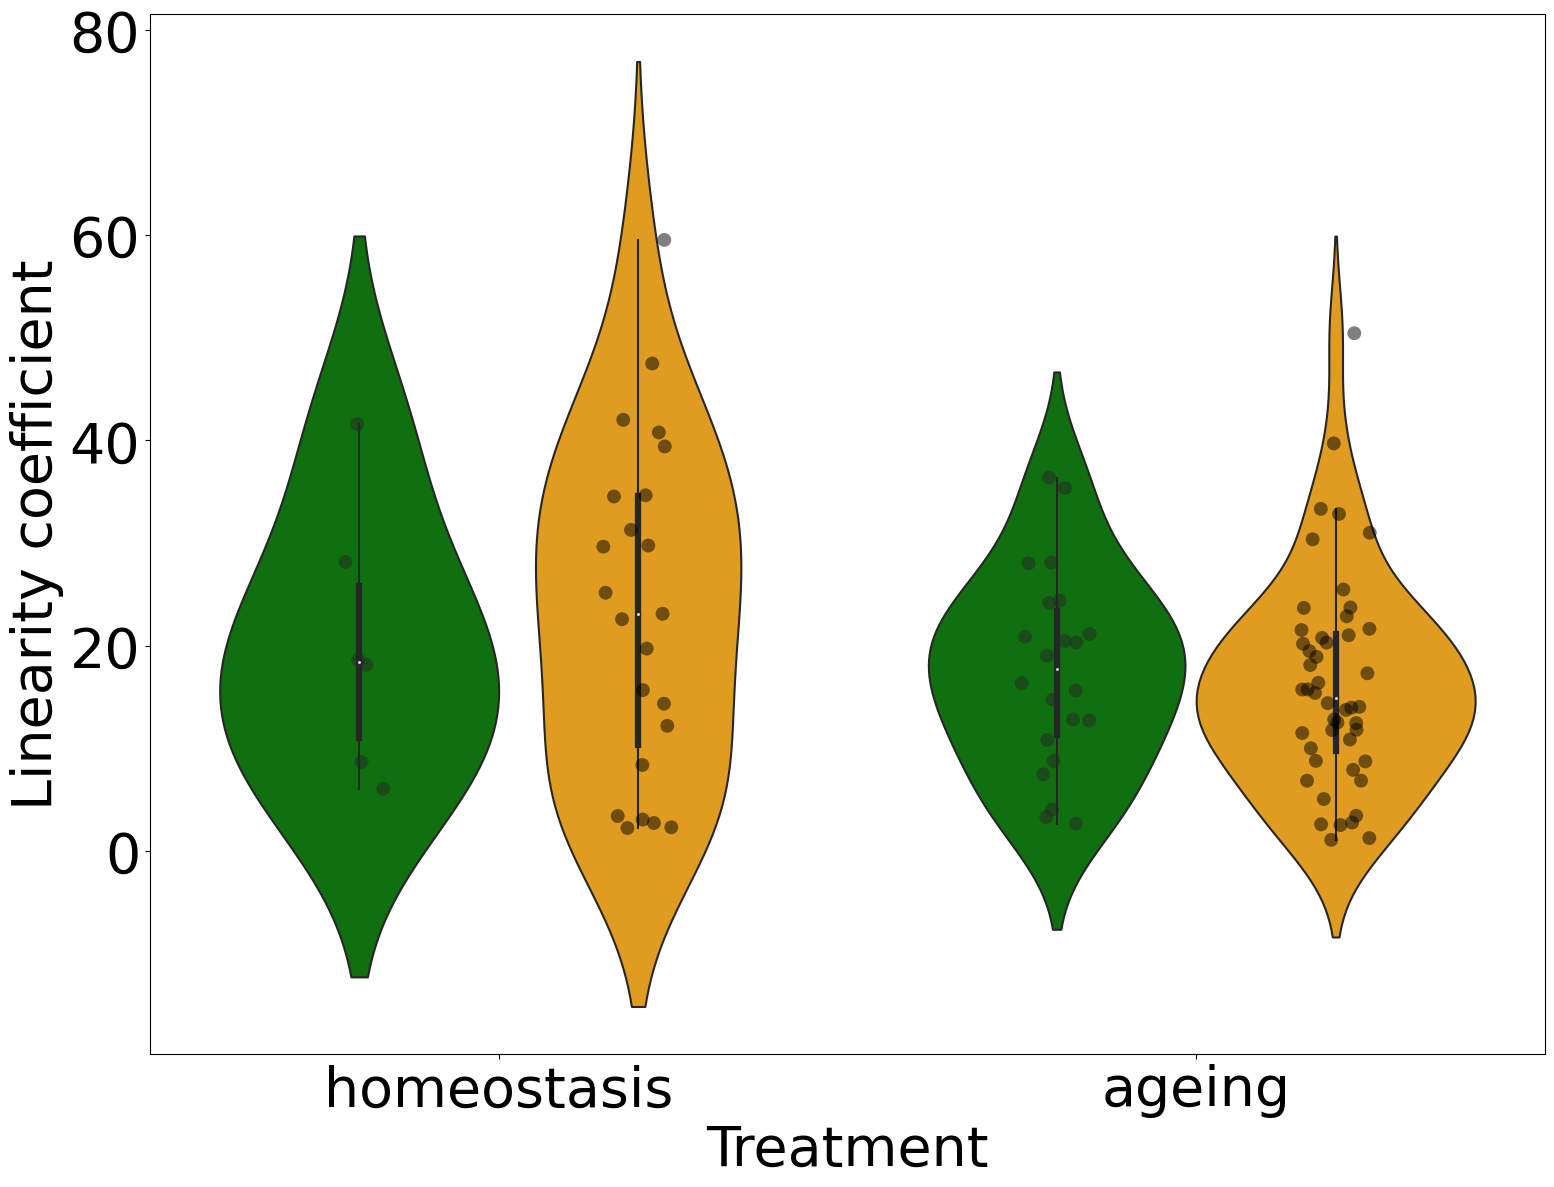

In [25]:
#PLOTTING HOMEOSTASIS AND AGEING 

##TRACK LENGTH

datax=data[data['Treatment']!='depletion']
datax=datax[datax['Treatment']!='24hdepletion']
datax['Group']=datax['Hoxb5_status_corrected']+datax['Treatment']

# # Full dataset
# dx=datax[['Treatment', 'Hoxb5_status_corrected', 'max_displacement','Group']]
# dx=dx.drop_duplicates()
# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="max_displacement", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="max_displacement", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing')))
# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # plt.legend([], [], frameon=False)
# g[1].set(ylabel='Maximum displacement (um)')
# plt.show(g)
# model = ols('max_displacement ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Group'], alpha=0.05).summary()

dx=datax[['Treatment', 'Hoxb5_status_corrected', 'track_length','Group']]
dx=dx.drop_duplicates()
g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="track_length", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing')))
plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Track length (um)')
plt.show(g)
model = ols('track_length ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Group'], alpha=0.05).summary()

## MAXIMUM DISPLACEMENT
datax=data[data['Treatment']!='depletion']
datax=datax[datax['Treatment']!='24hdepletion']
datax['Group']=datax['Hoxb5_status_corrected']+datax['Treatment']

# Full dataset
dx=datax[['Treatment', 'Hoxb5_status_corrected', 'max_displacement','Group']]
dx=dx.drop_duplicates()
g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="max_displacement", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="max_displacement", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5')))
plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
g[1].set(ylabel='Maximum displacement')
g[1].set(ylim=(0,6000))
plt.show(g)
model = ols('max_displacement ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
sm.stats.anova_lm(model, typ=2)
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Group'], alpha=0.05).summary()

##ARREST COEFFICIENT
#Full dataset
datax=data[data['Treatment']!='depletion']
datax=datax[datax['Treatment']!='24hdepletion']
datax['Group']=datax['Hoxb5_status_corrected']+datax['Treatment']
dx=datax[['Treatment', 'Hoxb5_status_corrected', 'arrest_coefficient','Final_Cell_ID','Group']]
dx=dx.drop_duplicates()

g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="arrest_coefficient", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5')))
# plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Arrest coefficient')
plt.show(g)

# model = ols('arrest_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Treatment'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['arrest_coefficient'], dx['Group'], alpha=0.05).summary()

#Full dataset
datax=data[data['Treatment']!='depletion']
datax=datax[datax['Treatment']!='24hdepletion']
datax['Group']=datax['Hoxb5_status_corrected']+datax['Treatment']
dx=datax[['Treatment', 'Hoxb5_status_corrected', 'mean_speed','Group']]
dx['mean_speed']=dx['mean_speed']*60
dx=dx.drop_duplicates()

g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="mean_speed", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="mean_speed", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5')))
# plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Mean speed')
plt.show(g)

# model = ols('mean_speed ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['mean_speed'], dx['Group'], alpha=0.05).summary()

##LINEARITY COEFFICIENT
# #Only cells that moved
datax=data[data['Treatment']!='depletion']
datax=datax[datax['Treatment']!='24hdepletion']
datax['Group']=datax['Hoxb5_status_corrected']+datax['Treatment']
datax=datax[datax['max_displacement']>10]
dx=datax[['Treatment', 'Hoxb5_status_corrected', 'linearity_coefficient']]
dx=dx.drop_duplicates()
g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5')))
# plt.legend(title='Cell type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
plt.legend([], [], frameon=False)
g[1].set(ylabel='Linearity coefficient')
plt.show(g)
# model = ols('linearity_coefficient ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(dx['linearity_coefficient'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/4030020334.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/4030020334.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['FileID']=datab['file'].str[0:52]
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/4030020334.py:22: FutureWarning: In a future version of pandas, a length 1 tuple w

92


/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


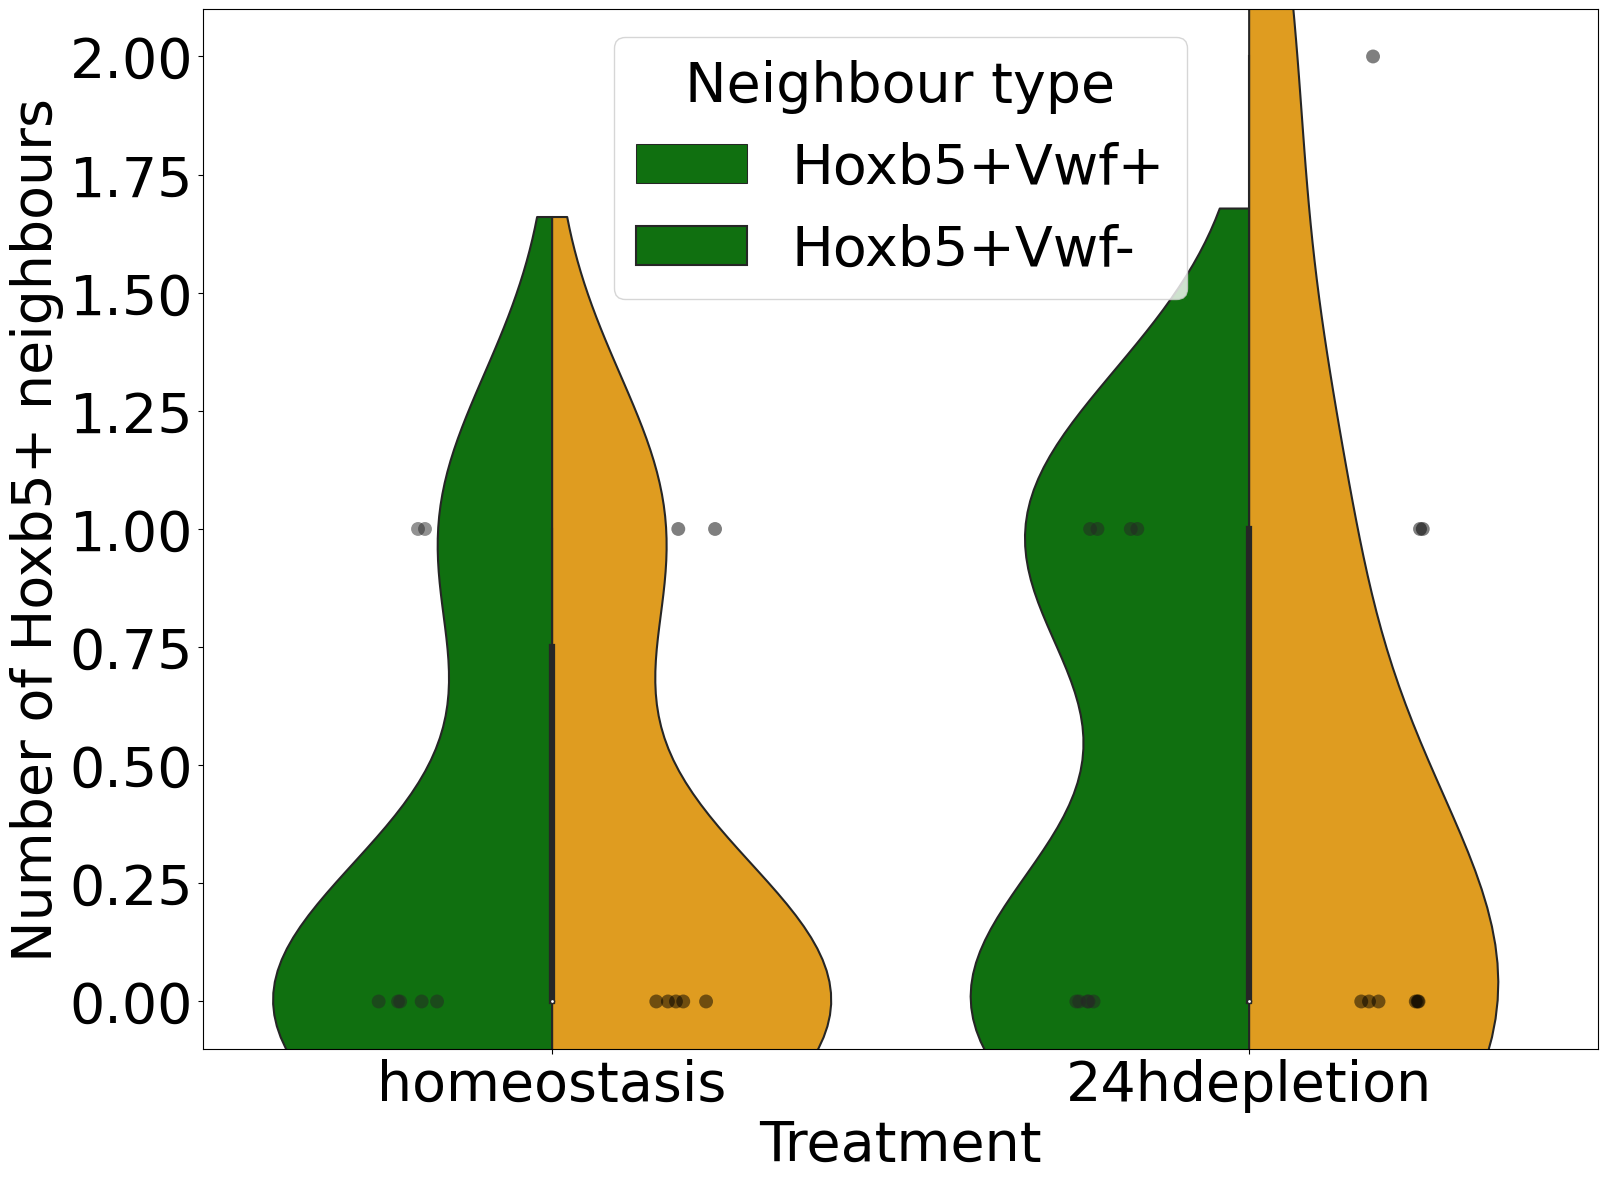

In [65]:
#calculating number of neighbours from the manual tracks

# Set figure width to 12 and height to 9
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 18
# fig_size[1] = 13.5
# plt.rcParams["figure.figsize"] = fig_size
# plt.rcParams["font.size"]=40
# print ("New size:", fig_size)
data=pd.read_csv('/Users/secchim/Downloads/manual_small_tracks230805.csv', header=0)

# datax=data[data['track_length']!=0]
datax=datax[datax['Treatment']!='ageing']
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'track_length','file']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

datab['FileID']=datab['file'].str[0:52]
print(len(datab['FileID'].unique()))

grouped=datab.groupby(['FileID'])
dflist=[]
for i, newdf in grouped:
    newdf['KuO']=(len(newdf['Final_Cell_ID'].unique())-1)
    for i, r in newdf.iterrows():
        if 'hoxb5' in newdf.loc[i,'Hoxb5_status_corrected']:
            newdf.loc[i,'KuO_vwf-']=(len(newdf[newdf['Hoxb5_status_corrected']=='hoxb5']['Final_Cell_ID'].unique()))-1
            newdf.loc[i,'KuO_vwf']=(len(newdf[newdf['Hoxb5_status_corrected']=='Hoxb5_vwf']['Final_Cell_ID'].unique()))
        elif 'Hoxb5_vwf' in newdf.loc[i,'Hoxb5_status_corrected']:
            newdf.loc[i,'KuO_vwf-']=(len(newdf[newdf['Hoxb5_status_corrected']=='hoxb5']['Final_Cell_ID'].unique()))
            newdf.loc[i,'KuO_vwf']=(len(newdf[newdf['Hoxb5_status_corrected']=='Hoxb5_vwf']['Final_Cell_ID'].unique()))-1
    dflist.append(newdf)
datab=pd.concat(dflist)


# dx=datab[['Treatment', 'Hoxb5_status_corrected', 'KuO','Group','Final_Cell_ID']]
# dx=dx.drop_duplicates()
# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="KuO", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="KuO", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Number of Hoxb5+Vwf- neighbours')
# plt.show(g)
# # model = ols('track_length ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# # sm.stats.anova_lm(model, typ=2)
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Group'], alpha=0.05).summary()

# dx=datab[['Treatment', 'Hoxb5_status_corrected', 'KuO_vwf','Group','Final_Cell_ID']]
# dx=dx.drop_duplicates()
# g=(sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="KuO_vwf", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="KuO_vwf", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Number of Hoxb5+Vwf+ neighbours')
# plt.show(g)

dx=datab[['Treatment', 'Hoxb5_status_corrected', 'KuO_vwf-','KuO','KuO_vwf','Group','Final_Cell_ID']]
dx=dx.drop_duplicates()
# dx.to_csv('/Users/secchim/Downloads/KUOneighbours.csv')

dx=pd.read_csv('/Users/secchim/Downloads/KUOneighbours.csv', header=0)

# g=(sns.catplot(x=("Treatment"),col='Hoxb5_status_corrected', hue='status', y=('KuO'), data=dx, dodge=True, alpha=0.5, s=10, col_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
#    , sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="KuO_vwf", data=dx, dodge=True, color='green', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')), sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="KuO_vwf", data=dx, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion')))
# plt.legend(title='Cell type', loc='upper right', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# plt.legend([], [], frameon=False)
# g[1].set(ylabel='Number of Hoxb5+ neighbours')
# dx=dx[dx['Treatment']!='depletion']
# dx=dx[dx['Treatment']!='24hdepletion']
# g=(sns.violinplot(x=("Hoxb5_status_corrected"), hue='status', y="KuO", data=dx, showfliers = False, palette=['green','orange'], hue_order=('KuO_vwf','KuO_vwf-'), order=('Hoxb5_vwf','hoxb5'), split=True), sns.stripplot(x=("Hoxb5_status_corrected"),hue='status', y="KuO", data=dx, dodge=False, palette= ['green','orange'], alpha=0.5, s=10, hue_order=('KuO_vwf','KuO_vwf-'), order=('Hoxb5_vwf','hoxb5')))
# plt.legend(title='Cell type', loc='upper left', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # # plt.legend([], [], frameon=False)
# g[1].set(ylabel='Number of Hoxb5+ neighbours')
# plt.show(g)

# # model = ols('KuO ~  C(Hoxb5_status_corrected) + C(Treatment)', data=dx).fit()
# # sm.stats.anova_lm(model, typ=2)
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Treatment'], alpha=0.05).summary()
# # # sm.stats.multicomp.pairwise_tukeyhsd(dx['max_displacement'], dx['Hoxb5_status_corrected'], alpha=0.05).summary()
# # sm.stats.multicomp.pairwise_tukeyhsd(dx['track_length'], dx['Group'], alpha=0.05).summary()

dx=dx[dx['Hoxb5_status_corrected']!='hoxb5']
dx=dx[dx['Treatment']!='depletion']
g=(sns.violinplot(x=("Treatment"), hue='status', y="KuO", data=dx, showfliers = False, palette=['green','orange'], hue_order=('KuO_vwf','KuO_vwf-'), order=('homeostasis','24hdepletion'), split=True), sns.stripplot(x=("Treatment"),hue='status', y="KuO", data=dx, dodge=True, color='black', alpha=0.5, s=10, hue_order=('KuO_vwf','KuO_vwf-'), order=('homeostasis','24hdepletion')))
plt.legend(title='Neighbour type', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # plt.legend([], [], frameon=False)
g[1].set(ylabel='Number of Hoxb5+ neighbours')
plt.show(g)



/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/491285877.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/491285877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['FileID']=datab['file'].str[0:52]
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_46025/491285877.py:26: FutureWarning: In a future version of pandas, a length 1 tuple w

['VWF_049_MS220201_M1_Snap_movie4homeostasis_[ii1_VWF_'
 'VWF_049_MS220201_M1_Snap_movie4homeostasis_[ii2_VWF_'
 'VWF_053_MS220209_M1_movie3depletion_[ii2_VWF_053_MS2'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii0_VWF_053_M'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii1_VWF_053_M'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii2_VWF_053_M'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii3_VWF_053_M'
 'VWF_053_MS220209_M1_movie2homeostasis_[ii4_VWF_053_M'
 'VWF_048_MS220119_M1_homeostasis_movie_3_[ii1_VWF_048'
 'VWF_048_MS220118_M3_movie2homeostasis_[ii2_VWF_048_M'
 'VWF_048_MS220118_M3_movie1plt_[ii0_VWF_048_MS220118_'
 'VWF_048_MS220118_M2_movie3_homeostasis_[ii1_VWF_048_'
 'VWF_048_MS220118_M2_movie3_homeostasis_[ii0_VWF_048_'
 'VWF_048_MS220118_M2_movie3_homeostasis_[ii2_VWF_048_'
 'VWF_043_MS211125_m4-homeostasismovie_2_[ii1_VWF_043_'
 'VWF_043_MS211125_m4-pltdepletionmovie2_[ii0_VWF_043_'
 'VWF_043_MS211125_m4-pltdepletionmovie3_[ii0_VWF_043_'
 'VWF_043_MS211125_m4-pltdepletionmovie2_[ii1_VW

<AxesSubplot: xlabel='min_distance_to_kuo', ylabel='Count'>

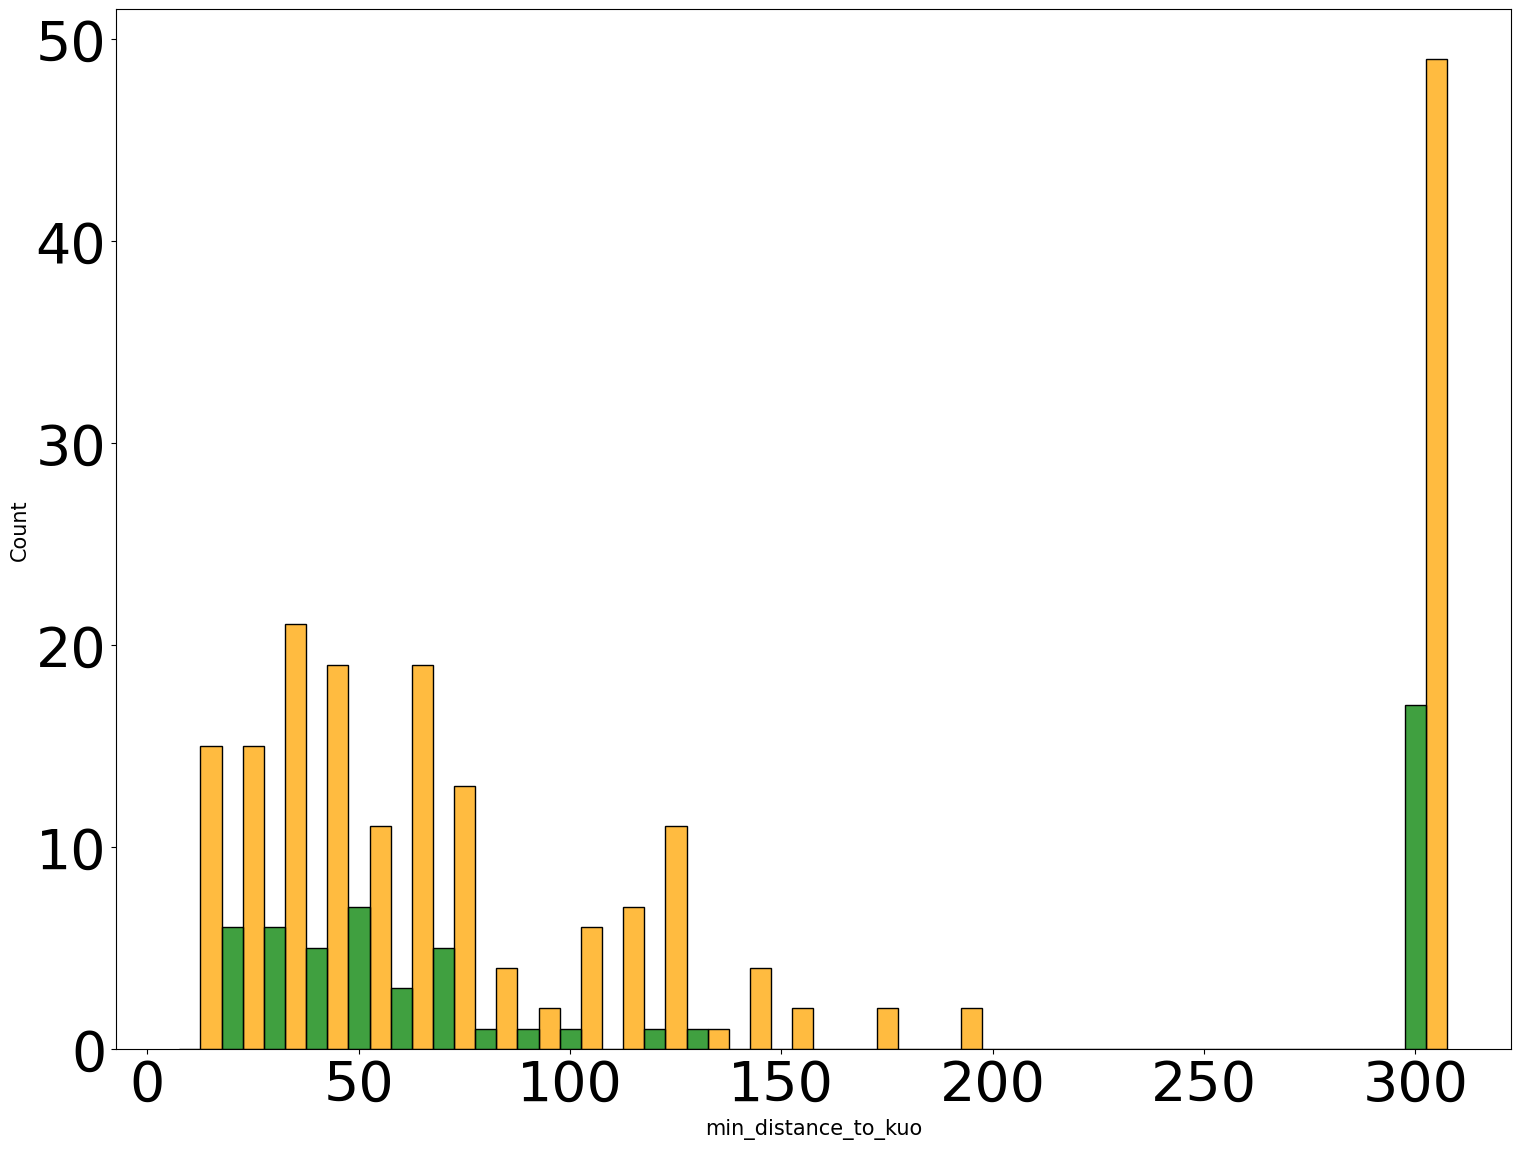

In [222]:
#attempt to calculate distances between KuO
# data=pd.read_csv('/Users/secchim/Downloads/manual_small_tracks230805.csv', header=0)
datax=pd.read_csv('/Users/secchim/Downloads/neighbour_tracks230905.csv', header=0)

# datax=data[data['track_length']!=0]
# datax=datax[datax['Treatment']!='ageing']
# datax=datax[datax['Treatment']!='depletion']
# datax=datax[datax['Treatment']!='24hdepletion']
# datax=datax[datax['Treatment']!='homeostasis']
# datax=datax[datax['Metadata_Timepoint']!='1']
datab=datax[['Final_Cell_ID', 'file','Treatment', 'Hoxb5_status_corrected', 'x', 'y','z','Metadata_Timepoint']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

datab['FileID']=datab['file'].str[0:52]
print((datab['FileID'].unique()))

dict={}
dict=dict.fromkeys(datab['Final_Cell_ID'].unique())
# print(dict, type(dict))


df_list=[]
# datab['min_distance_to_kuo']=10000000
grouped=datab.groupby(['FileID'])
dflist=[]
for i, newdf in grouped:
    if len(newdf['Final_Cell_ID'].unique())>1:
        for a in newdf['Final_Cell_ID'].unique():
            for b in newdf['Final_Cell_ID'].unique():
                if a!=b:
                    a_coordinates=newdf[newdf['Final_Cell_ID']==a]
                    tmpta=min(a_coordinates['Metadata_Timepoint'])
                    b_coordinates=newdf[newdf['Final_Cell_ID']==b]
                    tmptb=min(b_coordinates['Metadata_Timepoint'])
                    print(tmpta, tmptb)
                    if tmpta!=tmptb and tmptb in a_coordinates['Metadata_Timepoint'].unique():
                        tmpta=max(tmpta,tmptb)
                        print(tmpta, tmptb)
                        a_coordinates=a_coordinates[a_coordinates['Metadata_Timepoint']==tmpta]
                        b_coordinates=b_coordinates[b_coordinates['Metadata_Timepoint']==tmpta]
                        min_distance_to_kuo=mt.sqrt((a_coordinates.iloc[0,4]-b_coordinates.iloc[0,4])**2+(a_coordinates.iloc[0,5]-b_coordinates.iloc[0,5])**2+(a_coordinates.iloc[0,6]-b_coordinates.iloc[0,6])**2)
                        # print(dict[a])
                        if dict[a]==None: 
                            dict[a]=min_distance_to_kuo
                        elif dict[a]>min_distance_to_kuo:
                            dict[a]=min_distance_to_kuo
                    elif tmpta==tmptb:
                        print("tmpta==tmptb")
                    
                        a_coordinates=a_coordinates[a_coordinates['Metadata_Timepoint']==tmpta]
                        b_coordinates=b_coordinates[b_coordinates['Metadata_Timepoint']==tmpta]
                        min_distance_to_kuo=mt.sqrt((a_coordinates.iloc[0,4]-b_coordinates.iloc[0,4])**2+(a_coordinates.iloc[0,5]-b_coordinates.iloc[0,5])**2+(a_coordinates.iloc[0,6]-b_coordinates.iloc[0,6])**2)
                        # print(dict[a])
                        if dict[a]==None: 
                            dict[a]=min_distance_to_kuo
                        elif dict[a]>min_distance_to_kuo:
                            dict[a]=min_distance_to_kuo
                    else:
                        print("else occured")
                    # if newdf.iloc[1,'min_distance_to_kuo']>min_distance_to_kuo:
                        # newdf['min_distance_to_kuo']=min_distance_to_kuo
                    # dflist.append(newdf)
# datab=pd.concat(dflist)    
# print(datab['min_distance to kuo'])
print(dict)
addup=pd.DataFrame.from_dict(dict, orient='index', columns=['min_distance_to_kuo'])
addup=addup.fillna(300) #gives a value of 300 to cells that don't have a KuO neighbour
addup['Final_Cell_ID']=addup.index
# for i,r in datab.iterrows():
#     if datab.iloc[i,'Final_Cell_ID'] in dict.keys():
#         datab.iloc[i,'min_distance_to_kuo']=dict[(datab.iloc[i,'Final_Cell_ID'])].values()
# print(datab['min_distance_to_kuo'])

# print(addup[:])


data=pd.merge(datab, addup[:], on = 'Final_Cell_ID')
print(data['min_distance_to_kuo'])
data=data[[ 'Final_Cell_ID','Treatment', 'Hoxb5_status_corrected', 'min_distance_to_kuo','Group']]
data=data.drop_duplicates()
data.to_csv('/Users/secchim/Downloads/min_kuo_distances.csv', index=False)

##plotting one cell type and condition at a time 
# sns.scatterplot(x='FileID',y="min_distance_to_kuo", style='Treatment', hue='Hoxb5_status_corrected', data=data, legend=False)
# data=data[data['Treatment']=='ageing']
# sns.displot(data, x="min_distance_to_kuo", hue="Hoxb5_status_corrected", kind="kde", palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'))
# data=data[data['Hoxb5_status_corrected']=='hoxb5']
#histplot best to represent this data
sns.histplot(data, x="min_distance_to_kuo", hue="Hoxb5_status_corrected", palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), legend=False, binwidth=10, multiple="dodge")

##these first few lines not good
# g=(sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion'), split=True, legend=False), sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','depletion','24hdepletion'), legend=False))
# g=(sns.violinplot(x=("Treatment"), hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, showfliers = False, palette=['green','orange'], hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing'), split=True, legend=False), sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, dodge=True, color='black', alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'), order=('homeostasis','ageing'), legend=False))
# plt.legend(title='Mininum distance to other KuO+', loc='upper center', labels=['Hoxb5+Vwf+', 'Hoxb5+Vwf-'])
# # plt.legend([], [], frameon=False)
# g[1].set(ylabel='Minimum distance to other KuO+ cells (µm)')
# plt.ylim(0,500)
# plt.show(g)
##this one works fine, plotting all conditions and cell groups at once
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, dodge=True, alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'),  palette=['green','orange'], order=('homeostasis','depletion','24hdepletion'), legend=False)
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="min_distance_to_kuo", data=data, dodge=True, alpha=0.5, s=10, hue_order=('Hoxb5_vwf','hoxb5'),  palette=['green','orange'], order=('homeostasis','ageing'), legend=False)


##STATS
# data=data[data['Treatment']!='depletion']###When excluding na, compare only homeostasis and 24hdepletion
# model = ols('min_distance_to_kuo ~  C(Hoxb5_status_corrected) + C(Treatment)', data=data).fit()
# sm.stats.anova_lm(model, typ=2)
# sm.stats.multicomp.pairwise_tukeyhsd(data['min_distance_to_kuo'], data['Treatment'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(data['min_distance_to_kuo'], data['Hoxb5_status_corrected'], alpha=0.05).summary()
# sm.stats.multicomp.pairwise_tukeyhsd(data['min_distance_to_kuo'], data['Group'], alpha=0.05).summary()

In [104]:
#calculating proportion of cells moving more than 20um from the manual tracks (regardless of track length)
list2=[]
data=pd.read_csv('/Users/secchim/Downloads/manual_tracks230711.csv', header=0)
datax=data[data['Treatment']!='ageing']
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'track_length','file']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

for i in datab['Group'].unique():
    d=datab[datab['Group']==i]
    d=d[['Group', 'max_displacement','Final_Cell_ID']]
    d=d.drop_duplicates()
    print(d)
    list2.append(d['Final_Cell_ID'].unique())
print(list2)


data=pd.read_csv('/Users/secchim/Downloads/manual_small_tracks230805.csv', header=0)

# datax=data[data['track_length']!=0]
datax=data[data['Treatment']!='ageing']
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'track_length','file']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

list=[]
for i in datab['Group'].unique():
    d=datab[datab['Group']==i]
    d=d[['Group', 'max_displacement','Final_Cell_ID']]
    d=d.drop_duplicates()
    print(d)
    list.append(d['Final_Cell_ID'].unique())
    print(list)
    # over20=(len(d[d['max_displacement']>20])/len(d['max_displacement']))*100
    # print(i, over20)
    # topl=[over20, (100-over20)]
    # plt.pie(topl, labels =['track length over20um', 'track length under 20um'], colors=('blue','pink'), autopct='%1.1f%%')
    # plt.show()


# for i in d['Final_Cell_ID'].unique():
#         if i not in list2:
#             list.append(i)

# print('this is the list', list)

                  Group  max_displacement  Final_Cell_ID
0     homeostasis_hoxb5          6.498524           1.10
84    homeostasis_hoxb5          6.755369           1.40
126   homeostasis_hoxb5         17.671498           3.10
147   homeostasis_hoxb5         14.782966           3.11
189   homeostasis_hoxb5         22.167284           3.40
210   homeostasis_hoxb5         38.826460           3.50
231   homeostasis_hoxb5         20.548757           3.60
315   homeostasis_hoxb5          5.912754           7.10
336   homeostasis_hoxb5         13.572396           8.10
357   homeostasis_hoxb5         18.203331           8.20
399   homeostasis_hoxb5         61.004430          10.10
1176  homeostasis_hoxb5         43.429721          24.40
1197  homeostasis_hoxb5         20.088812          24.50
1218  homeostasis_hoxb5         17.376877          24.60
1239  homeostasis_hoxb5         13.494984          24.70
1869  homeostasis_hoxb5          8.311973          31.10
1890  homeostasis_hoxb5        

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/3978246686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/3978246686.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']


In [109]:
data=pd.read_csv('/Users/secchim/Downloads/manual_small_tracks230805.csv', header=0)

# datax=data[data['track_length']!=0]
datax=datax[datax['Treatment']!='ageing']
datab=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'max_displacement', 'track_length','file','Metadata_Timepoint','x','y','z']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']

datab['FileID']=datab['file'].str[0:52]
print(len(datab['FileID'].unique()))

grouped=datab.groupby(['FileID'])
dflist=[]
for i, newdf in grouped:
    if len(newdf['Final_Cell_ID'].unique())>2:
        newdf=newdf[newdf['Metadata_Timepoint']==1]
        newdf["x_next"] = newdf["x"].shift(-1)
        newdf["y_next"] = newdf["y"].shift(-1)
        newdf["z_next"] = newdf["z"].shift(-1)
        for b, r in newdf.iterrows():
            # if (newdf.loc[b, 'Last_timepoint'])== False: 
            # try:#will it work for the last cell?
            newdf.loc[b, "KuOdistance"]=(math.sqrt((newdf.loc[b, "x"]-newdf.loc[b, "x_next"])**2+(newdf.loc[b, "y"]-newdf.loc[b, "y_next"])**2+(newdf.loc[b, "z"]-newdf.loc[b, "z_next"])**2))
        newdf['minKuOdistance']=newdf['KuOdistance'].min()# is not right
        dflist.append(newdf)
d=pd.concat(dflist)
print(d[['minKuOdistance','Final_Cell_ID']].drop_duplicates())        
        # for i in newdf['Final_Cell_ID'].unique():
            # storedX=newdf[newdf['Final_Cell_ID']==i]['x'].values
# d=d[d['Treatment']!='ageing']
d.to_csv('/Users/secchim/Downloads/KUOdistance.csv')

92
      minKuOdistance  Final_Cell_ID
21         43.257896            1.2
63         43.257896            1.3
84         43.257896            1.4
677        26.340818           15.3
691        26.340818           15.4
705        26.340818           15.5
1954       24.429530           28.3
1975       24.429530           28.4
1996       24.429530           28.5
2017       66.808712           28.6
2038       66.808712           28.7
2059       66.808712           28.8
2465       45.427871           31.4
2486       45.427871           31.5
2498       45.427871           31.6
2510       45.427871           31.7
2568      120.172899           32.1
2589      120.172899           32.2
2673      120.172899           32.6
2631       58.762153           32.4
2652       58.762153           32.5
2694       58.762153           32.7


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/3170073785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/3170073785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['FileID']=datab['file'].str[0:52]
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_4074/3170073785.py:13: FutureWarning: In a future version of pandas, a length 1 tuple wil